Potential Independent Variables:
BENE_ID: The beneficiary (patient) ID. This helps to uniquely identify the patient, though it might not directly predict the target variable.

CLM_ID: Claim ID that uniquely identifies the claim.

CLM_FROM_DT, CLM_THRU_DT: The start and end dates of the claim. These could be useful in deriving features related to the time duration of the visit.

CLM_FAC_TYPE_CD: The Facility Type Code, which indicates the type of facility where the service was provided (e.g., inpatient, outpatient, etc.). This is a key feature for identifying whether the service could be ER-related.

PRVDR_NUM: The provider number (could indicate the facility or physician).

ICD Diagnosis Codes: Any of the ICD diagnosis codes (e.g., ICD_DGNS_CD1, ICD_DGNS_CD2, etc.). These codes describe the condition for which the service was provided, which might be indicative of an emergency situation.

HCPCS Code: Healthcare Common Procedure Coding System (HCPCS) codes might describe specific procedures or services rendered during the visit. These could be valuable for distinguishing ER services from other types of services.

DAW_PROD_SLCTN_CD: This code indicates whether the prescription was dispensed as prescribed, which could be relevant for outpatient settings.

QTY_DSPNSD_NUM: Quantity dispensed. This may be relevant when considering medication use in an ER visit.

PTNT_DSCHRG_STUS_CD: Patient discharge status, which could give insight into the severity or nature of the visit (e.g., was the patient discharged after the ER visit?).

RSN_VISIT_CD: Reason for visit code, which could help to explain the cause of the visit and help determine if it is an ER visit (emergency-related reasons).



1. Predictive Modeling
Predict ER Visit (ER_VISIT)
Use the ICD codes + demographics as features. You’ve already started this.

Predict Length of Stay (LENGTH_OF_STAY)
Regression model: Which factors (ICD, age, sex, etc.) lead to longer stays?

2. Feature Importance / Explainability
Logistic Regression Coefficients
Already done — tells you direction and magnitude of influence.

SHAP Values / Permutation Importance - Not doneyet
To understand individual and global feature impacts on predictions.


Seasonality / Trends
Analyze how ER visits vary across time — by year, month, or even during flu season



Introduction:
    This study aims to analyze and predict emergency room (ER) visits among Medicare beneficiaries using claims data. By examining patient demographics (age, sex, race), entitlement reasons, and a wide range of chronic conditions (ICD codes), the goal is to identify key predictors that influence ER utilization. Through exploratory data analysis (EDA) and machine learning models—including logistic regression, XGBoost, and random forest—we assess the relative impact of clinical and demographic factors. Hypotheses tested include whether chronic illnesses, older age, and length of stay contribute significantly to ER visits. The findings can help healthcare providers target high-risk populations and reduce unnecessary ER utilization through preventive care

#Research questions:
Which ICD chronic conditions (e.g., asthma, CKD, COPD) are most strongly associated with ER visits?
Does age group, Entitlement reasonsor and sex significantly influence the likelihood of an ER visit?


H1: Patients with chronic conditions such as CICD_Chronic Kidney Disease (CKD) , heart failure, or diabetes have a higher likelihood of ER visits.
H2: Older age groups (75+) are more likely to visit the ER compared to younger age groups (31–64).
H3: There is a significant association between sex and ER visit rates.
H5: A longer length of stay during hospitalization is predictive of an increased risk of subsequent ER visits

# Null Hypothesis (H₀):
There is no statistically significant association on iCD chronic conditions (such as COPD, heart failure, or diabetes) and the likelihood of an ER visit

# Alternative Hypothesis (H₁):
There is a statistically significant association on  iCD chronic conditions (such as COPD, heart failure, or diabetes) and the likelihood of an ER visit

In [ ]:
https://www.kaggle.com/code/shivamb/deep-healthcare-analysis-using-bigquery

## Data link: https://data.cms.gov/collection/synthetic-medicare-enrollment-fee-for-service-claims-and-prescription-drug-event

In [539]:
#load libraries
#pip install pandas
import pandas as pd
#pip install openpyxl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Load claims Inpatient data from CMS website https://data.cms.gov/collection/synthetic-medicare-enrollment-fee-for-service-claims-and-prescription-drug-event

In [573]:
df_claims_IP = pd.read_csv("C:/Users/sarad/Desktop/Inpatient-data/inpatient.csv",
 usecols=['BENE_ID','CLM_ID','CLM_ADMSN_DT','NCH_BENE_DSCHRG_DT','ICD_DGNS_CD1','ICD_DGNS_CD2','ICD_DGNS_CD3','ICD_DGNS_CD4',
 'ICD_DGNS_CD5','ICD_DGNS_CD6','ICD_DGNS_CD7','ICD_DGNS_CD8','ICD_DGNS_CD9','ICD_DGNS_CD10','ICD_DGNS_CD11','ICD_DGNS_CD12',
 'ICD_DGNS_CD13','ICD_DGNS_CD14','ICD_DGNS_CD15','ICD_DGNS_CD16','ICD_DGNS_CD17','ICD_DGNS_CD18','ICD_DGNS_CD19','ICD_DGNS_CD20',
 'ICD_DGNS_CD21','ICD_DGNS_CD22','ICD_DGNS_CD23','ICD_DGNS_CD24','ICD_DGNS_CD25','REV_CNTR'], 
dtype={"BENE_ID":"str","BENE_RACE_CD":"str","CLM_ID":"str","CLM_ADMSN_DT":"str","NCH_BENE_DSCHRG_DT":"str","REV_CNTR":"str"},                          
                           
sep='|',low_memory =False)
df_claims_IP.head()


BENE_ID           CLM_ID CLM_ADMSN_DT NCH_BENE_DSCHRG_DT  \
0  -10000010254618  -10000930037831  25-Mar-2015        25-Mar-2015   
1  -10000010254653  -10000930038030  24-Sep-2015        24-Sep-2015   
2  -10000010254653  -10000930038031  09-May-2017        10-May-2017   
3  -10000010254656  -10000930038162  14-Jan-2017        14-Jan-2017   
4  -10000010254656  -10000930038162  14-Jan-2017        14-Jan-2017   

  ICD_DGNS_CD1 ICD_DGNS_CD2 ICD_DGNS_CD3 ICD_DGNS_CD4 ICD_DGNS_CD5  \
0       S134XX        R4689         E781         J329         E119   
1       T7432X         E669       C50919          NaN          NaN   
2       T7432X         E669       C50929          NaN          NaN   
3       S8290X       G40909         R569        Z8669          NaN   
4       S8290X       G40909         R569        Z8669          NaN   

  ICD_DGNS_CD6  ... ICD_DGNS_CD17 ICD_DGNS_CD18 ICD_DGNS_CD19 ICD_DGNS_CD20  \
0         D649  ...           NaN           NaN           NaN           NaN   
1          NaN  ...           NaN           NaN           NaN           NaN   
2          NaN  ...           NaN           NaN           NaN           NaN   
3          NaN  ...           NaN           NaN           NaN           NaN   
4          NaN  ...           NaN           NaN           NaN           NaN   

  ICD_DGNS_CD21 ICD_DGNS_CD22 ICD_DGNS_CD23 ICD_DGNS_CD24 ICD_DGNS_CD25  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

  REV_CNTR  
0     0450  
1     0450  
2     0001  
3     0450  
4     0450  

[5 rows x 30 columns]

In [574]:
df_claims_IP.shape

(58066, 30)

In [578]:
df_claims_IP.to_excel("C:/Users/sarad/Desktop/data698reseach/df_claims_IP.xlsx", index=False)

# Upload Beneficiary data from CMS website for beneciary year 2021. Data link here: https://data.cms.gov/collection/synthetic-medicare-enrollment-fee-for-service-claims-and-prescription-drug-event

In [575]:
# only loading demographic data for 2021
# Let's load just one demographic file to see its structure
url = 'https://github.com/Deepasharma83/pde-data/raw/main/beneficiary_2021.csv'
df_demographic_21 = pd.read_csv(url,
usecols=['BENE_ID','BENE_RACE_CD','AGE_AT_END_REF_YR','SEX_IDENT_CD','STATE_CNTY_FIPS_CD_01','STATE_CNTY_FIPS_CD_02','ENTLMT_RSN_CURR'], 
dtype={"BENE_ID":"str","BENE_RACE_CD":"str","AGE_AT_END_REF_YR":"str","SEX_IDENT_CD":"str","STATE_CNTY_FIPS_CD_01":"str","STATE_CNTY_FIPS_CD_02":"str","ENTLMT_RSN_CURR":"str"}, 
sep="|", 
low_memory=False)                          
df_demographic_21.head()



BENE_ID SEX_IDENT_CD BENE_RACE_CD ENTLMT_RSN_CURR  \
0  -10000010254618            1            1               1   
1  -10000010254647            1            2               1   
2  -10000010254653            2            1               1   
3  -10000010254656            2            1               1   
4  -10000010254666            2            4               1   

  AGE_AT_END_REF_YR STATE_CNTY_FIPS_CD_01 STATE_CNTY_FIPS_CD_02  
0                22                  1101                  1101  
1                31                  1083                  1083  
2                39                  1081                  1081  
3                22                  1073                  1073  
4                12                  1089                  1089

In [579]:
df_demographic_21.to_excel("C:/Users/sarad/Desktop/data698reseach/df_demographic_21.xlsx",index = False)

In [576]:
# Column name 
df_demographic_21.columns.tolist()
# shape
df_demographic_21.shape

(8246, 7)

In [580]:
merged_df =pd.merge(df_claims_IP, df_demographic_21, on='BENE_ID', how='left')
merged_df.head()

BENE_ID           CLM_ID CLM_ADMSN_DT NCH_BENE_DSCHRG_DT  \
0  -10000010254618  -10000930037831  25-Mar-2015        25-Mar-2015   
1  -10000010254653  -10000930038030  24-Sep-2015        24-Sep-2015   
2  -10000010254653  -10000930038031  09-May-2017        10-May-2017   
3  -10000010254656  -10000930038162  14-Jan-2017        14-Jan-2017   
4  -10000010254656  -10000930038162  14-Jan-2017        14-Jan-2017   

  ICD_DGNS_CD1 ICD_DGNS_CD2 ICD_DGNS_CD3 ICD_DGNS_CD4 ICD_DGNS_CD5  \
0       S134XX        R4689         E781         J329         E119   
1       T7432X         E669       C50919          NaN          NaN   
2       T7432X         E669       C50929          NaN          NaN   
3       S8290X       G40909         R569        Z8669          NaN   
4       S8290X       G40909         R569        Z8669          NaN   

  ICD_DGNS_CD6  ... ICD_DGNS_CD23 ICD_DGNS_CD24 ICD_DGNS_CD25 REV_CNTR  \
0         D649  ...           NaN           NaN           NaN     0450   
1          NaN  ...           NaN           NaN           NaN     0450   
2          NaN  ...           NaN           NaN           NaN     0001   
3          NaN  ...           NaN           NaN           NaN     0450   
4          NaN  ...           NaN           NaN           NaN     0450   

  SEX_IDENT_CD BENE_RACE_CD ENTLMT_RSN_CURR AGE_AT_END_REF_YR  \
0            1            1               1                22   
1            2            1               1                39   
2            2            1               1                39   
3            2            1               1                22   
4            2            1               1                22   

  STATE_CNTY_FIPS_CD_01 STATE_CNTY_FIPS_CD_02  
0                  1101                  1101  
1                  1081                  1081  
2                  1081                  1081  
3                  1073                  1073  
4                  1073                  1073  

[5 rows x 36 columns]

In [581]:
merged_df.shape

(58066, 36)

In [ ]:
merged_df.columns.tolist()
merged_df.isnull().sum()
#merged_df.shape

# Limit dataframe to chronic conditions link here : 30 CCW Chronic Conditions Algorithms


# Do some writeup here regarding chronic condition code 

In [582]:

valid_icds =['I230','I231','I232','I233','I234','I235','I236','I237','I238','I2101','I2102','I2109','I2111','I2119','I2121','I2129','I213','I214','I219','I21A1','I21A9','I220','I221','I222','I228','I229','G300','G301','G308','G309','C946','D460','D461','D4620','D4621','D4622','D464','D469','D46A','D46B','D46C','D46Z','D474','D500','D501','D508','D509','D510','D511','D512','D513','D518','D519','D520','D521','D528','D529','D530','D531','D532','D538','D539','D550','D551','D552','D5521','D5529','D553','D558','D559','D560','D561','D562','D563','D564','D565','D568','D569','D5700','D5701','D5702','D571','D5720','D57211','D57212','D57219','D573','D5740','D57411','D57412','D57413','D57418','D57419','D5742','D57431','D57432','D57433','D57438','D57439','D5744','D57451','D57452','D57453','D57458','D57459','D5780','D57811','D57812','D57813','D57818','D57819','D580','D581','D582','D588','D589','D590','D591','D5910','D5911','D5912','D5913','D5919','D592','D593','D594','D595','D596','D598','D599','D600','D601','D608','D609','D6101','D6109','D611','D612','D613','D61810','D61811','D61818','D6182','D6189','D619','D630','D631','D638','D640','D641','D642','D643','D644','D6481','D6489','D649','D7581','J4520','J4521','J4522','J4530','J4531','J4532','J4540','J4541','J4542','J4550','J4551','J4552','J45901','J45902','J45909','J45990','J45991','J45998','I480','I481','I4811','I4819','I482','I4820','I4821','I483','I484','I4891','N400','N401','N402','N403','C50011','C50012','C50019','C50021','C50022','C50029','C50111','C50112','C50119','C50121','C50122','C50129','C50211','C50212','C50219','C50221','C50222','C50229','C50311','C50312','C50319','C50321','C50322','C50329','C50411','C50412','C50419','C50421','C50422','C50429','C50511','C50512','C50519','C50521','C50522','C50529','C50611','C50612','C50619','C50621','C50622','C50629','C50811','C50812','C50819','C50821','C50822','C50829','C50911','C50912','C50919','C50921','C50922','C50929','D0500','D0501','D0502','D0510','D0511','D0512','D0580','D0581','D0582','D0590','D0591','D0592','Z170','Z171','Z191','Z192','Z853','Z86000','C180','C181','C182','C183','C184','C185','C186','C187','C188','C189','C19','C20','C49A4','C49A5','D010','D011','D012','Z85030','Z85038','Z85040','Z85048','C540','C541','C542','C543','C548','C549','D070','Z8542','C3400','C3401','C3402','C3410','C3411','C3412','C342','C3430','C3431','C3432','C3480','C3481','C3482','C3490','C3491','C3492','D0220','D0221','D0222','Z85110','Z85118','C61','D075','Z8546','C641','C642','C649','C651','C652','C659','C661','C662','C669','C688','C689','D0910','D0919','Z85520','Z85528','Z8553','Z8554','Z8559','E0836','E0936','E1036','E1136','E1336','H25011','H25012','H25013','H25019','H25031','H25032','H25033','H25039','H25041','H25042','H25043','H25049','H25091','H25092','H25093','H25099','H2510','H2511','H2512','H2513','H2520','H2521','H2522','H2523','H25811','H25812','H25813','H25819','H2589','H259','H26001','H26002','H26003','H26009','H26011','H26012','H26013','H26019','H26031','H26032','H26033','H26039','H26041','H26042','H26043','H26049','H26051','H26052','H26053','H26059','H26061','H26062','H26063','H26069','H2609','H26101','H26102','H26103','H26109','H26111','H26112','H26113','H26119','H26121','H26122','H26123','H26129','H26131','H26132','H26133','H26139','H2620','H26211','H26212','H26213','H26219','H26221','H26222','H26223','H26229','H2630','H2631','H2632','H2633','H2640','H26411','H26412','H26413','H26419','H26491','H26492','H26493','H26499','H268','H269','Q120','A1811','A5275','B520','E0821','E0822','E0829','E0921','E0922','E0929','E1021','E1022','E1029','E1121','E1122','E1129','E1321','E1322','E1329','I120','I129','I130','I1310','I1311','I132','K767','M1030','M10311','M10312','M10319','M10321','M10322','M10329','M10331','M10332','M10339','M10341','M10342','M10349','M10351','M10352','M10359','M10361','M10362','M10369','M10371','M10372','M10379','M1038','M1039','M3214','M3215','M3504','M350A','N010','N011','N012','N013','N014','N015','N016','N017','N018','N019','N01A','N020','N021','N022','N023','N024','N025','N026','N027','N028','N029','N02A','N030','N031','N032','N033','N034','N035','N036','N037','N038','N039','N03A','N040','N041','N042','N043','N044','N045','N046','N047','N048','N049','N04A','N050','N051','N052','N053','N054','N055','N056','N057','N058','N059','N05A','N060','N061','N062','N063','N064','N065','N066','N067','N068','N069','N06A','N070','N071','N072','N073','N074','N075','N076','N077','N078','N079','N07A','N08','N140','N141','N142','N143','N144','N150','N158','N159','N16','N181','N182','N183','N1830','N1831','N1832','N184','N185','N186','N189','N251','N2589','N259','N261','N269','N990','Q6102','Q6111','Q6119','Q612','Q613','Q614','Q615','Q618','J40','J410','J411','J418','J42','J430','J431','J432','J439','J440','J441','J449','J470','J471','J479','J982','J983','F0631','F0632','F310','F3110','F3111','F3112','F3113','F312','F3130','F3131','F3132','F314','F315','F3160','F3161','F3162','F3163','F3164','F3171','F3173','F3175','F3176','F3177','F3178','F3181','F3189','F319','F320','F321','F322','F323','F324','F325','F328','F3289','F329','F32A','F330','F331','F332','F333','F3340','F3341','F3342','F338','F339','F340','F341','F4321','F4323','E0800','E0801','E0810','E0811','E0821','E0822','E0829','E08311','E08319','E08321','E083211','E083212','E083213','E083219','E08329','E083291','E083292','E083293','E083299','E08331','E083311','E083312','E083313','E083319','E08339','E083391','E083392','E083393','E083399','E08341','E083411','E083412','E083413','E083419','E08349','E083491','E083492','E083493','E083499','E08351','E083511','E083512','E083513','E083519','E083521','E083522','E083523','E083529','E083531','E083532','E083533','E083539','E083541','E083542','E083543','E083549','E083551','E083552','E083553','E083559','E08359','E083591','E083592','E083593','E083599','E0836','E0837X1','E0837X2','E0837X3','E0837X9','E0839','E0840','E0841','E0842','E0843','E0844','E0849','E0851','E0852','E0859','E08610','E08618','E08620','E08621','E08622','E08628','E08630','E08638','E08641','E08649','E0865','E0869','E088','E089','E0900','E0901','E0910','E0911','E0921','E0922','E0929','E09311','E09319','E09321','E093211','E093212','E093213','E093219','E09329','E093291','E093292','E093293','E093299','E09331','E093311','E093312','E093313','E093319','E09339','E093391','E093392','E093393','E093399','E09341','E093411','E093412','E093413','E093419','E09349','E093491','E093492','E093493','E093499','E09351','E093511','E093512','E093513','E093519','E093521','E093522','E093523','E093529','E093531','E093532','E093533','E093539','E093541','E093542','E093543','E093549','E093551','E093552','E093553','E093559','E09359','E093591','E093592','E093593','E093599','E0936','E0937X1','E0937X2','E0937X3','E0937X9','E0939','E0940','E0941','E0942','E0943','E0944','E0949','E0951','E0952','E0959','E09610','E09618','E09620','E09621','E09622','E09628','E09630','E09638','E09641','E09649','E0965','E0969','E098','E099','E1010','E1011','E1021','E1022','E1029','E10311','E10319','E10321','E103211','E103212','E103213','E103219','E10329','E103291','E103292','E103293','E103299','E10331','E103311','E103312','E103313','E103319','E10339','E103391','E103392','E103393','E103399','E10341','E103411','E103412','E103413','E103419','E10349','E103491','E103492','E103493','E103499','E10351','E103511','E103512','E103513','E103519','E10359','E1036','E1037X1','E1037X2','E1037X3','E1037X9','E1039','E1040','E1041','E1042','E1043','E1044','E1049','E1051','E1052','E1059','E10610','E10618','E10620','E10621','E10622','E10628','E10630','E10638','E10641','E10649','E1065','E1069','E108','E109','E1100','E1101','E1110','E1111','E1121','E1122','E1129','E11311','E11319','E11321','E113211','E113212','E113213','E113219','E11329','E113291','E113292','E113293','E113299','E11331','E113311','E113312','E113313','E113319','E11339','E113391','E113392','E113393','E113399','E11341','E113411','E113412','E113413','E113419','E11349','E113491','E113492','E113493','E113499','E11351','E113511','E113512','E113513','E113519','E113521','E113522','E113523','E113529','E113531','E113532','E113533','E113539','E113541','E113542','E113543','E113549','E113551','E113552','E113553','E113559','E11359','E113591','E113592','E113593','E113599','E1136','E1137X1','E1137X2','E1137X3','E1137X9','E1139','E1140','E1141','E1142','E1143','E1144','E1149','E1151','E1152','E1159','E11610','E11618','E11620','E11621','E11622','E11628','E11630','E11638','E11641','E11649','E1165','E1169','E118','E119','E1300','E1301','E1310','E1311','E1321','E1322','E1329','E13311','E13319','E13321','E133211','E133212','E133213','E133219','E13329','E133291','E133292','E133293','E133299','E13331','E133311','E133312','E133313','E133319','E13339','E133391','E133392','E133393','E133399','E13341','E133411','E133412','E133413','E133419','E13349','E133491','E133492','E133493','E133499','E13351','E133511','E133512','E133513','E133519','E133521','E133522','E133523','E133529','E133531','E133532','E133533','E133539','E133541','E133542','E133543','E133549','E133551','E133552','E133553','E133559','E13359','E1336','E1339','E1340','E1341','E1342','E1343','E1344','E1349','E1351','E1352','E1359','E13610','E13618','E13620','E13621','E13622','E13628','E13630','E13638','E13641','E13649','E1365','E1369','E138','E139','H40011','H40012','H40013','H40019','H40021','H40022','H40023','H40029','H40041','H40042','H40043','H40049','H40051','H40052','H40053','H40059','H4010X0','H4010X1','H4010X2','H4010X3','H4010X4','H401110','H401111','H401112','H401113','H401114','H401120','H401121','H401122','H401123','H401124','H401130','H401131','H401132','H401133','H401134','H401190','H401191','H401192','H401193','H401194','H4011X0','H4011X1','H4011X2','H4011X3','H4011X4','H401210','H401211','H401212','H401213','H401214','H401220','H401221','H401222','H401223','H401224','H401230','H401231','H401232','H401233','H401234','H401290','H401291','H401292','H401293','H401294','H401310','H401311','H401312','H401313','H401314','H401320','H401321','H401322',
'H401323','H401324','H401330','H401331','H401332','H401333','H401334','H401390','H401391','H401392','H401393','H401394','H401410','H401411','H401412','H401413','H401414','H401420','H401421','H401422','H401423','H401424','H401430','H401431','H401432','H401433','H401434','H401490','H401491','H401492','H401493','H401494','H40151','H40152','H40153','H40159','H4020X0','H4020X1','H4020X2','H4020X3','H4020X4','H40211','H40212','H40213','H40219','H402210','H402211','H402212','H402213','H402214','H402220','H402221','H402222','H402223','H402224','H402230','H402231','H402232','H402233','H402234','H402290','H402291','H402292','H402293','H402294','H40231','H40232','H40233','H40239','H40241','H40242','H40243','H40249','H4030X0','H4030X1','H4030X2','H4030X3','H4030X4','H4031X0','H4031X1','H4031X2','H4031X3','H4031X4','H4032X0','H4032X1','H4032X2','H4032X3','H4032X4','H4033X0','H4033X1','H4033X2','H4033X3','H4033X4','H4040X0','H4040X1','H4040X2','H4040X3','H4040X4','H4041X0','H4041X1','H4041X2','H4041X3','H4041X4','H4042X0','H4042X1','H4042X2','H4042X3','H4042X4','H4043X0','H4043X1','H4043X2','H4043X3','H4043X4','H4050X0','H4050X1','H4050X2','H4050X3','H4050X4','H4051X0','H4051X1','H4051X2','H4051X3','H4051X4','H4052X0','H4052X1','H4052X2','H4052X3','H4052X4','H4053X0','H4053X1','H4053X2','H4053X3','H4053X4','H4060X0','H4060X1','H4060X2','H4060X3','H4060X4','H4061X0','H4061X1','H4061X2','H4061X3','H4061X4','H4062X0','H4062X1','H4062X2','H4062X3','H4062X4','H4063X0','H4063X1','H4063X2','H4063X3','H4063X4','H40811','H40812','H40813','H40819','H40821','H40822','H40823','H40829','H40831','H40832','H40833','H40839','H4089','H409','H42','H44511','H44512','H44513','H44519','H47231','H47232','H47233','H47239','Q150','I0981','I110','I130','I132','I420','I425','I426','I427','I428','I43','I501','I5020','I5021','I5022','I5023','I5030','I5031','I5032','I5033','I5040','I5041','I5042','I5043','I50810','I50811','I50812','I50813','I50814','I5082','I5083','I5084','I5089','I509','P290','M80051A','M80052A','M80059A','M80851A','M80852A','M80859A','M84350A','M84351A','M84352A','M84353A','M84359A','M84451A','M84452A','M84453A','M84459A','M84550A','M84551A','M84552A','M84553A','M84559A','M84650A','M84651A','M84652A','M84653A','M84659A','M9701XA','M9702XA','S32301A','S32301B','S32302A','S32302B','S32309A','S32309B','S32311A','S32311B','S32312A','S32312B','S32313A','S32313B','S32314A','S32314B','S32315A','S32315B','S32316A','S32316B','S32391A','S32391B','S32392A','S32392B','S32399A','S32399B','S32401A','S32401B','S32402A','S32402B','S32409A','S32409B','S32411A','S32411B','S32412A','S32412B','S32413A','S32413B','S32414A','S32414B','S32415A','S32415B','S32416A','S32416B','S32421A','S32421B','S32422A','S32422B','S32423A','S32423B','S32424A','S32424B','S32425A','S32425B','S32426A','S32426B','S32431A','S32431B','S32432A','S32432B','S32433A','S32433B','S32434A','S32434B','S32435A','S32435B','S32436A','S32436B','S32441A','S32441B','S32442A','S32442B','S32443A','S32443B','S32444A','S32444B','S32445A','S32445B','S32446A','S32446B','S32451A','S32451B','S32452A','S32452B','S32453A','S32453B','S32454A','S32454B','S32455A','S32455B','S32456A','S32456B','S32461A','S32461B','S32462A','S32462B','S32463A','S32463B','S32464A','S32464B','S32465A','S32465B','S32466A','S32466B','S32471A','S32471B','S32472A','S32472B','S32473A','S32473B','S32474A','S32474B','S32475A','S32475B','S32476A','S32476B','S32481A','S32481B','S32482A','S32482B','S32483A','S32483B','S32484A','S32484B','S32485A','S32485B','S32486A','S32486B','S32491A','S32491B','S32492A','S32492B','S32499A','S32499B','S32501A','S32501B','S32502A','S32502B','S32509A','S32509B','S32511A','S32511B','S32512A','S32512B','S32519A','S32519B','S32591A','S32591B','S32592A','S32592B','S32599A','S32599B','S32601A','S32601B','S32602A','S32602B','S32609A','S32609B','S32611A','S32611B','S32612A','S32612B','S32613A','S32613B','S32614A','S32614B','S32615A','S32615B','S32616A','S32616B','S32691A','S32691B','S32692A','S32692B','S32699A','S32699B','S32810A','S32810B','S32811A','S32811B','S3282XA','S3282XB','S3289XA','S3289XB','S329XXA','S329XXB','S72001A','S72001B','S72001C','S72002A','S72002B','S72002C','S72009A','S72009B','S72009C','S72011A','S72011B','S72011C','S72012A','S72012B','S72012C','S72019A','S72019B','S72019C','S72021A','S72021B','S72021C','S72022A','S72022B','S72022C','S72023A','S72023B','S72023C','S72024A','S72024B','S72024C','S72025A','S72025B','S72025C','S72026A','S72026B','S72026C','S72031A','S72031B','S72031C','S72032A','S72032B','S72032C','S72033A','S72033B','S72033C','S72034A','S72034B','S72034C','S72035A','S72035B','S72035C','S72036A','S72036B','S72036C','S72041A','S72041B','S72041C','S72042A','S72042B','S72042C','S72043A','S72043B','S72043C','S72044A','S72044B','S72044C','S72045A','S72045B','S72045C','S72046A','S72046B','S72046C','S72051A','S72051B','S72051C','S72052A','S72052B','S72052C','S72059A','S72059B','S72059C','S72061A','S72061B','S72061C','S72062A','S72062B','S72062C','S72063A','S72063B','S72063C','S72064A','S72064B','S72064C','S72065A','S72065B','S72065C','S72066A','S72066B','S72066C','S72091A','S72091B','S72091C','S72092A','S72092B','S72092C','S72099A','S72099B','S72099C','S72101A','S72101B','S72101C','S72102A','S72102B','S72102C','S72109A','S72109B','S72109C','S72111A','S72111B','S72111C','S72112A','S72112B','S72112C','S72113A','S72113B','S72113C','S72114A','S72114B','S72114C','S72115A','S72115B','S72115C','S72116A','S72116B','S72116C','S72121A','S72121B','S72121C','S72122A','S72122B','S72122C','S72123A','S72123B','S72123C','S72124A','S72124B','S72124C','S72125A','S72125B','S72125C','S72126A','S72126B','S72126C','S72131A','S72131B','S72131C','S72132A','S72132B','S72132C','S72133A','S72133B','S72133C','S72134A','S72134B','S72134C','S72135A','S72135B','S72135C','S72136A','S72136B','S72136C','S72141A','S72141B','S72141C','S72142A','S72142B','S72142C','S72143A','S72143B','S72143C','S72144A','S72144B','S72144C','S72145A','S72145B','S72145C','S72146A','S72146B','S72146C','S7221XA','S7221XB','S7221XC','S7222XA','S7222XB','S7222XC','S7223XA','S7223XB','S7223XC','S7224XA','S7224XB','S7224XC','S7225XA','S7225XB','S7225XC','S7226XA','S7226XB','S7226XC','S79001A','S79002A','S79009A','S79011A','S79012A','S79019A','S79091A','S79092A','S79099A','E780','E7800','E7801','E781','E782','E783','E784','E7841','E7849','E785','H35031','H35032','H35033','H35039','I10','I110','I119','I120','I129','I130','I1310','I1311','I132','I150','I151','I152','I158','I159','I674','N262','E000','E001','E002','E009','E018','E02','E030','E031','E032','E033','E034','E038','E039','E890','I200','I201','I208','I240','I241','I248','I2510','I25110','I25111','I25118','I25119','I253','I2541','I2542','I255','I256','I25700','I25701','I25708','I25710','I25711','I25718','I25719','I25720','I25721','I25728','I25729','I25730','I25731','I25738','I25739','I25750','I25751','I25758','I25759','I25760','I25761','I25768','I25769','I25790','I25791','I25798','I25799','I25810','I25811','I25812','I2582','I2583','I2584','I2589','I259','F0150','F0151','F0280','F0281','F0390','F0391','F05','G138','G3101','G3109','G311','G312','G3183','G94','R4181','M8000XA','M80011A','M80012A','M80019A','M80021A','M80022A','M80029A','M80031A','M80032A','M80039A','M80041A','M80042A','M80049A','M80051A','M80052A','M80059A','M80061A','M80062A','M80069A','M80071A','M80072A','M80079A','M8008XA','M800AXA','M8080XA','M80811A','M80812A','M80819A','M80821A','M80822A','M80829A','M80831A','M80832A','M80839A','M80841A','M80842A','M80849A','M80851A','M80852A','M80859A','M80861A','M80862A','M80869A','M80871A','M80872A','M80879A','M8088XA','M808AXA','M810','M816','M818','G20','G2111','G2119','G213','G214','G218','G219','G3183','A0103','A0222','A065','A202','A212','A221','A310','A3701','A3711','A3781','A3791','A403','A420','A430','A481','A5004','A5484','B012','B052','B0681','B371','B380','B382','B390','B392','B400','B402','B410','B583','B59','B664','B671','B7781','B953','B960','B961','J09X1','J1000','J1001','J1008','J1100','J1108','J120','J121','J122','J123','J1281','J1282','J1289','J129','J13','J14','J150','J151','J1520','J15211','J15212','J1529','J153','J154','J155','J156','J157','J158','J159','J160','J168','J17','J180','J181','J182','J188','J189','J200','J84111','J84116','J84117','J84178','J842','J851','J95851','P230','P231','P232','P233','P234','P235','P236','P238','P239','Z8701','L4050','L4051','L4054','L4059','M0500','M05011','M05012','M05019','M05021','M05022','M05029','M05031','M05032','M05039','M05041','M05042','M05049','M05051','M05052','M05059','M05061','M05062','M05069','M05071','M05072','M05079','M0509','M0510','M05111','M05112','M05119','M05121','M05122','M05129','M05131','M05132','M05139','M05141','M05142','M05149','M05151','M05152','M05159','M05161','M05162','M05169','M05171','M05172','M05179','M0519','M0520','M05211','M05212','M05219','M05221','M05222','M05229','M05231','M05232','M05239','M05241','M05242','M05249','M05251','M05252','M05259','M05261','M05262','M05269','M05271','M05272','M05279','M0529','M0530','M05311','M05312','M05319','M05321','M05322','M05329','M05331','M05332','M05339','M05341','M05342','M05349','M05351','M05352','M05359','M05361','M05362','M05369','M05371','M05372','M05379','M0539','M0540','M05411','M05412','M05419','M05421','M05422','M05429','M05431','M05432','M05439','M05441','M05442','M05449','M05451','M05452','M05459','M05461','M05462','M05469','M05471','M05472','M05479','M0549','M0550','M05511','M05512','M05519','M05521','M05522','M05529','M05531','M05532','M05539','M05541','M05542','M05549','M05551','M05552','M05559','M05561','M05562','M05569','M05571','M05572','M05579','M0559','M0560','M05611','M05612','M05619','M05621','M05622','M05629','M05631','M05632','M05639','M05641','M05642','M05649','M05651','M05652','M05659','M05661','M05662','M05669','M05671','M05672','M05679','M0569','M0570','M05711','M05712','M05719','M05721','M05722','M05729','M05731','M05732','M05739','M05741','M05742','M05749','M05751','M05752','M05759','M05761','M05762','M05769','M05771',
'M05772','M05779','M0579','M057A','M0580','M05811','M05812','M05819','M05821','M05822','M05829','M05831','M05832','M05839','M05841','M05842','M05849','M05851','M05852','M05859','M05861','M05862','M05869','M05871','M05872','M05879','M0589','M058A','M059','M0600','M06011','M06012','M06019','M06021','M06022','M06029','M06031','M06032','M06039','M06041','M06042','M06049','M06051','M06052','M06059','M06061','M06062','M06069','M06071','M06072','M06079','M0608','M0609','M060A','M061','M0620','M06211','M06212','M06219','M06221','M06222','M06229','M06231','M06232','M06239','M06241','M06242','M06249','M06251','M06252','M06259','M06261','M06262','M06269','M06271','M06272','M06279','M0628','M0629','M0630','M06311','M06312','M06319','M06321','M06322','M06329','M06331','M06332','M06339','M06341','M06342','M06349','M06351','M06352','M06359','M06361','M06362','M06369','M06371','M06372','M06379','M0638','M0639','M0680','M06811','M06812','M06819','M06821','M06822','M06829','M06831','M06832','M06839','M06841','M06842','M06849','M06851','M06852','M06859','M06861','M06862','M06869','M06871','M06872','M06879','M0688','M0689','M068A','M069','M0800','M08011','M08012','M08019','M08021','M08022','M08029','M08031','M08032','M08039','M08041','M08042','M08049','M08051','M08052','M08059','M08061','M08062','M08069','M08071','M08072','M08079','M0808','M0809','M080A','M081','M0820','M08211','M08212','M08219','M08221','M08222','M08229','M08231','M08232','M08239','M08241','M08242','M08249','M08251','M08252','M08259','M08261','M08262','M08269','M08271','M08272','M08279','M0828','M0829','M082A','M083','M0840','M08411','M08412','M08419','M08421','M08422','M08429','M08431','M08432','M08439','M08441','M08442','M08449','M08451','M08452','M08459','M08461','M08462','M08469','M08471','M08472','M08479','M0848','M084A','M0880','M08811','M08812','M08819','M08821','M08822','M08829','M08831','M08832','M08839','M08841','M08842','M08849','M08851','M08852','M08859','M08861','M08862','M08869','M08871','M08872','M08879','M0888','M0889','M0890','M08911','M08912','M08919','M08921','M08922','M08929','M08931','M08932','M08939','M08941','M08942','M08949','M08951','M08952','M08959','M08961','M08962','M08969','M08971','M08972','M08979','M0898','M0899','M089A','M150','M151','M152','M153','M154','M158','M159','M160','M1610','M1611','M1612','M162','M1630','M1631','M1632','M164','M1650','M1651','M1652','M166','M167','M169','M170','M1710','M1711','M1712','M172','M1730','M1731','M1732','M174','M175','M179','M180','M1810','M1811','M1812','M182','M1830','M1831','M1832','M184','M1850','M1851','M1852','M189','M19011','M19012','M19019','M19021','M19022','M19029','M19031','M19032','M19039','M19041','M19042','M19049','M19071','M19072','M19079','M1909','M19111','M19112','M19119','M19121','M19122','M19129','M19131','M19132','M19139','M19141','M19142','M19149','M19171','M19172','M19179','M19211','M19212','M19219','M19221','M19222','M19229','M19231','M19232','M19239','M19241','M19242','M19249','M19271','M19272','M19279','M1929','M1990','M1991','M1992','M1993','M450','M451','M452','M453','M454','M455','M456','M457','M458','M459','M45A0','M45A1','M45A2','M45A3','M45A4','M45A5','M45A6','M45A7','M45A8','M45AB','M4680','M4681','M4682','M4683','M4684','M4685','M4686','M4687','M4688','M4689','M4690','M4691','M4692','M4693','M4694','M4695','M4696','M4697','M4698','M4699','M47011','M47012','M47013','M47014','M47015','M47016','M47019','M47021','M47022','M47029','M4710','M4711','M4712','M4713','M4714','M4715','M4716','M4720','M4721','M4722','M4723','M4724','M4725','M4726','M4727','M4728','M47811','M47812','M47813','M47814','M47815','M47816','M47817','M47818','M47819','M47891','M47892','M47893','M47894','M47895','M47896','M47897','M47898','M47899','M479','M488X1','M488X2','M488X3','M488X4','M488X5','M488X6','M488X7','M488X8','M488X9','G450','G451','G452','G453','G458','G459','G460','G461','G462','G463','G464','G465','G466','G467','G468','G9731','G9732','I6000','I6001','I6002','I6010','I6011','I6012','I602','I6020','I6021','I6022','I6030','I6031','I6032','I604','I6050','I6051','I6052','I606','I607','I608','I609','I610','I611','I612','I613','I614','I615','I616','I618','I619','I6200','I6201','I6202','I629','I6300','I63011','I63012','I63013','I63019','I6302','I63031','I63032','I63033','I63039','I6309','I6310','I63111','I63112','I63113','I63119','I6312','I63131','I63132','I63133','I63139','I6319','I6320','I63211','I63212','I63213','I63219','I6322','I63231','I63232','I63233','I63239','I6329','I6330','I63311','I63312','I63313','I63319','I63321','I63322','I63323','I63329','I63331','I63332','I63333','I63339','I63341','I63342','I63343','I63349','I6339','I6340','I63411','I63412','I63413','I63419','I63421','I63422','I63423','I63429','I63431','I63432','I63433','I63439','I63441','I63442','I63443','I63449','I6349','I6350','I63511','I63512','I63513','I63519','I63521','I63522','I63523','I63529','I63531','I63532','I63533','I63539','I63541','I63542','I63543','I63549','I6359','I636','I638','I6381','I6389','I639','I67841','I67848','I6789','I97810','I97811','I97820','I97821']

In [583]:
# update merged_df dataframe to only contain icds from the valid_icds list
merged_df.loc[~merged_df["ICD_DGNS_CD1"].isin(valid_icds), "ICD_DGNS_CD1"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD2"].isin(valid_icds), "ICD_DGNS_CD2"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD3"].isin(valid_icds), "ICD_DGNS_CD3"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD4"].isin(valid_icds), "ICD_DGNS_CD4"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD5"].isin(valid_icds), "ICD_DGNS_CD5"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD6"].isin(valid_icds), "ICD_DGNS_CD6"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD7"].isin(valid_icds), "ICD_DGNS_CD7"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD8"].isin(valid_icds), "ICD_DGNS_CD8"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD9"].isin(valid_icds), "ICD_DGNS_CD9"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD10"].isin(valid_icds), "ICD_DGNS_CD10"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD11"].isin(valid_icds), "ICD_DGNS_CD11"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD12"].isin(valid_icds), "ICD_DGNS_CD12"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD13"].isin(valid_icds), "ICD_DGNS_CD13"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD14"].isin(valid_icds), "ICD_DGNS_CD14"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD15"].isin(valid_icds), "ICD_DGNS_CD15"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD16"].isin(valid_icds), "ICD_DGNS_CD16"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD17"].isin(valid_icds), "ICD_DGNS_CD17"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD18"].isin(valid_icds), "ICD_DGNS_CD18"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD19"].isin(valid_icds), "ICD_DGNS_CD19"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD20"].isin(valid_icds), "ICD_DGNS_CD20"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD21"].isin(valid_icds), "ICD_DGNS_CD21"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD22"].isin(valid_icds), "ICD_DGNS_CD22"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD23"].isin(valid_icds), "ICD_DGNS_CD23"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD24"].isin(valid_icds), "ICD_DGNS_CD24"] = "NonCronic"
merged_df.loc[~merged_df["ICD_DGNS_CD25"].isin(valid_icds), "ICD_DGNS_CD25"] = "NonCronic"

In [584]:
merged_df.head(10)

BENE_ID           CLM_ID CLM_ADMSN_DT NCH_BENE_DSCHRG_DT  \
0  -10000010254618  -10000930037831  25-Mar-2015        25-Mar-2015   
1  -10000010254653  -10000930038030  24-Sep-2015        24-Sep-2015   
2  -10000010254653  -10000930038031  09-May-2017        10-May-2017   
3  -10000010254656  -10000930038162  14-Jan-2017        14-Jan-2017   
4  -10000010254656  -10000930038162  14-Jan-2017        14-Jan-2017   
5  -10000010254656  -10000930038163  17-Mar-2018        17-Mar-2018   
6  -10000010254656  -10000930038164  12-Mar-2022        12-Mar-2022   
7  -10000010254666  -10000930038283  21-Mar-2015        21-Mar-2015   
8  -10000010254682  -10000930038442  30-Apr-2021        30-Apr-2021   
9  -10000010254682  -10000930038442  30-Apr-2021        30-Apr-2021   

  ICD_DGNS_CD1 ICD_DGNS_CD2 ICD_DGNS_CD3 ICD_DGNS_CD4 ICD_DGNS_CD5  \
0    NonCronic    NonCronic         E781    NonCronic         E119   
1    NonCronic    NonCronic       C50919    NonCronic    NonCronic   
2    NonCronic    NonCronic       C50929    NonCronic    NonCronic   
3    NonCronic    NonCronic    NonCronic    NonCronic    NonCronic   
4    NonCronic    NonCronic    NonCronic    NonCronic    NonCronic   
5    NonCronic    NonCronic    NonCronic    NonCronic    NonCronic   
6    NonCronic    NonCronic    NonCronic    NonCronic    NonCronic   
7    NonCronic    NonCronic    NonCronic    NonCronic    NonCronic   
8    NonCronic    NonCronic    NonCronic         I214    NonCronic   
9    NonCronic    NonCronic    NonCronic         I214    NonCronic   

  ICD_DGNS_CD6  ... ICD_DGNS_CD23 ICD_DGNS_CD24 ICD_DGNS_CD25 REV_CNTR  \
0         D649  ...     NonCronic     NonCronic     NonCronic     0450   
1    NonCronic  ...     NonCronic     NonCronic     NonCronic     0450   
2    NonCronic  ...     NonCronic     NonCronic     NonCronic     0001   
3    NonCronic  ...     NonCronic     NonCronic     NonCronic     0450   
4    NonCronic  ...     NonCronic     NonCronic     NonCronic     0450   
5    NonCronic  ...     NonCronic     NonCronic     NonCronic     0450   
6    NonCronic  ...     NonCronic     NonCronic     NonCronic     0450   
7    NonCronic  ...     NonCronic     NonCronic     NonCronic     0450   
8    NonCronic  ...     NonCronic     NonCronic     NonCronic     0450   
9    NonCronic  ...     NonCronic     NonCronic     NonCronic     0450   

  SEX_IDENT_CD BENE_RACE_CD ENTLMT_RSN_CURR AGE_AT_END_REF_YR  \
0            1            1               1                22   
1            2            1               1                39   
2            2            1               1                39   
3            2            1               1                22   
4            2            1               1                22   
5            2            1               1                22   
6            2            1               1                22   
7            2            4               1                12   
8            1            1               0                79   
9            1            1               0                79   

  STATE_CNTY_FIPS_CD_01 STATE_CNTY_FIPS_CD_02  
0                  1101                  1101  
1                  1081                  1081  
2                  1081                  1081  
3                  1073                  1073  
4                  1073                  1073  
5                  1073                  1073  
6                  1073                  1073  
7                  1089                  1089  
8                  1025                  1025  
9                  1025                  1025  

[10 rows x 36 columns]

In [ ]:
merged_df.columns.tolist()
merged_df.info()
merged_df.isnull().sum()
merged_df.describe()

In [ ]:
merged_df['CLM_ADMSN_DT'].unique().tolist()
#merged_df['CLM_ADMSN_DT'].value_counts()

In [ ]:
# Task 1:
# Clean up the data
# Are there any mising values
# standardize Date columns to datetime formate
# Create target variable ER Visit from REV_CNTR column
# Create Length of stay (LOS) from ADMSN_DT and DISCH_DT columns
# Create Age group from AGE_AT_END_REF_YR column

In [ ]:
# percentage of missing values in each columns
percent_missing = merged_df.isnull().sum() * 100 / len(merged_df)
merged_df_missing_values = pd.DataFrame({'column_name': merged_df.columns,
'percent_missing': percent_missing})
merged_df_missing_values.sort_values('percent_missing', inplace=True)
print(merged_df_missing_values)


Since, I have 1.58 % of missing data in ENTLMT_RSN_CURR and AGE_AT_END_REF_YR so droping those rows are not going to affect the analysis much.
Also, I  have 19.68% of missing data in STATE_CNTY_FIPS_CD_01 and STATE_CNTY_FIPS_CD_02 so dropping those rows are not going to affect the analysis much.

In [587]:
# Drop missing rows in specific columns
merged_df = merged_df.dropna(subset=['SEX_IDENT_CD','AGE_AT_END_REF_YR','BENE_RACE_CD', 'ENTLMT_RSN_CURR', 'STATE_CNTY_FIPS_CD_01','STATE_CNTY_FIPS_CD_02'])


In [ ]:
#Check missing data
merged_df.isnull().sum() #No missing values in the merged_df. 

In [ ]:
merged_df.info()
merged_df.shape

In [620]:
# convert dates to datetime
merged_df['CLM_ADMSN_DT'] = pd.to_datetime(merged_df['CLM_ADMSN_DT'])
merged_df['NCH_BENE_DSCHRG_DT'] = pd.to_datetime(merged_df['NCH_BENE_DSCHRG_DT'])

In [590]:
# Convert SEX_IDENT_CD to category and rename the values 
merged_df['SEX_IDENT_CD'] = merged_df['SEX_IDENT_CD'].astype('category')
merged_df['SEX_IDENT_CD'] = merged_df['SEX_IDENT_CD'].cat.rename_categories({1: 'Male', 2: 'Female'})
print(merged_df['SEX_IDENT_CD'].value_counts())

SEX_IDENT_CD
1    28204
2    20468
Name: count, dtype: int64


In [ ]:
merged_df.dtypes

In [592]:
# Convert BENE_RACE_CD to category and rename the values
merged_df['BENE_RACE_CD'] = merged_df['BENE_RACE_CD'].astype('category')
merged_df['BENE_RACE_CD'] = merged_df['BENE_RACE_CD'].cat.rename_categories({'1': 'White', '2': 'Black', '3': 'Other', '4': 'Asian', '5': 'Hispanic', '6': 'North_American_Native'})
print(merged_df['BENE_RACE_CD'].value_counts())

BENE_RACE_CD
White                    30630
Hispanic                  9070
Black                     5974
Asian                     1335
Other                     1125
North_American_Native      538
Name: count, dtype: int64


# ENTLMT_RSN_CURR: Current Reason for Entitlement Code
0 = Old age and survivor’s insurance (OASI)
1 = Disability insurance benefits (DIB)
2 = End-stage renal disease (ESRD)
3 = Both DIB and ESRD
4 = Beneficiary insured due to Part B Immunosuppressive Drug (PBID)

In [601]:
# Convert ENTLMT_RSN_CURR to category and rename the values
merged_df['ENTLMT_RSN_CURR'] = merged_df['ENTLMT_RSN_CURR'].astype('category')

print(merged_df['ENTLMT_RSN_CURR'].value_counts())

ENTLMT_RSN_CURR
OASI        34596
DIB         10470
ESRD         2211
DIB ESRD     1395
Name: count, dtype: int64


In [607]:
merged_df['ENTLMT_RSN_CURR'] = merged_df['ENTLMT_RSN_CURR'].cat.rename_categories({'0': 'OASI', '1': 'DIB', '2': 'ESRD', '3': 'Both ADIB and ESRD '})
print(merged_df['ENTLMT_RSN_CURR'].value_counts())

ENTLMT_RSN_CURR
OASI        34596
DIB         10470
ESRD         2211
DIB ESRD     1395
Name: count, dtype: int64


In [608]:
merged_df['ENTLMT_RSN_CURR'].unique()

['DIB', 'OASI', 'ESRD', 'DIB ESRD']
Categories (4, object): ['OASI', 'DIB', 'ESRD', 'DIB ESRD']

In [ ]:
# Create a categoris for age
merged_df['AGE_AT_END_REF_YR'].unique()
merged_df['AGE_AT_END_REF_YR'].value_counts()

In [610]:
# Convert AGE_AT_END_REF_YR to float
merged_df['AGE_AT_END_REF_YR'] = merged_df['AGE_AT_END_REF_YR'].astype(float)

# Define bin edges and corresponding labels
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 105]
labels = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','80-max']

# Create age group categories
merged_df['AGE_GROUP'] = pd.cut(merged_df['AGE_AT_END_REF_YR'], bins=bins, labels=labels, right=True)

# Drop the original age column
merged_df = merged_df.drop('AGE_AT_END_REF_YR', axis=1)

# Print distribution of age groups
print(merged_df['AGE_GROUP'].value_counts())


AGE_GROUP
80-max    14273
71-80     12155
61-70      9677
51-60      5914
41-50      2858
31-40      1489
21-30       755
0-10        325
11-20       302
Name: count, dtype: int64


In [ ]:
merged_df.columns.tolist()

In [611]:
# assign valid icds to chronic condition categories
ami_icds=['I230','I231','I232','I233','I234','I235','I236','I237','I238','I2101','I2102','I2109','I2111','I2119','I2121','I2129','I213','I214','I219','I21A1','I21A9','I220','I221','I222','I228','I229']
ad_icds=['G300','G301','G308','G309']
anemia_icds=['C946','D460','D461','D4620','D4621','D4622','D464','D469','D46A','D46B','D46C','D46Z','D474','D500','D501','D508','D509','D510','D511','D512','D513','D518','D519','D520','D521','D528','D529','D530','D531','D532','D538','D539','D550','D551','D552','D5521','D5529','D553','D558','D559','D560','D561','D562','D563','D564','D565','D568','D569','D5700','D5701','D5702','D571','D5720','D57211','D57212','D57219','D573','D5740','D57411','D57412','D57413','D57418','D57419','D5742','D57431','D57432','D57433','D57438','D57439','D5744','D57451','D57452','D57453','D57458','D57459','D5780','D57811','D57812','D57813','D57818','D57819','D580','D581','D582','D588','D589','D590','D591','D5910','D5911','D5912','D5913','D5919','D592','D593','D594','D595','D596','D598','D599','D600','D601','D608','D609','D6101','D6109','D611','D612','D613','D61810','D61811','D61818','D6182','D6189','D619','D630','D631','D638','D640','D641','D642','D643','D644','D6481','D6489','D649','D7581']
asthma_icds=['J4520','J4521','J4522','J4530','J4531','J4532','J4540','J4541','J4542','J4550','J4551','J4552','J45901','J45902','J45909','J45990','J45991','J45998']
afib_flutter_icds=['I480','I481','I4811','I4819','I482','I4820','I4821','I483','I484','I4891']
bph_icds=['N400','N401','N402','N403']
breast_ca_icds=['C50011','C50012','C50019','C50021','C50022','C50029','C50111','C50112','C50119','C50121','C50122','C50129','C50211','C50212','C50219','C50221','C50222','C50229','C50311','C50312','C50319','C50321','C50322','C50329','C50411','C50412','C50419','C50421','C50422','C50429','C50511','C50512','C50519','C50521','C50522','C50529','C50611','C50612','C50619','C50621','C50622','C50629','C50811','C50812','C50819','C50821','C50822','C50829','C50911','C50912','C50919','C50921','C50922','C50929','D0500','D0501','D0502','D0510','D0511','D0512','D0580','D0581','D0582','D0590','D0591','D0592','Z170','Z171','Z191','Z192','Z853','Z86000']
colorectal_ca_icds=['C180','C181','C182','C183','C184','C185','C186','C187','C188','C189','C19','C20','C49A4','C49A5','D010','D011','D012','Z85030','Z85038','Z85040','Z85048']
endometrial_ca_icds=['C540','C541','C542','C543','C548','C549','D070','Z8542']
lung_ca_icds=['C3400','C3401','C3402','C3410','C3411','C3412','C342','C3430','C3431','C3432','C3480','C3481','C3482','C3490','C3491','C3492','D0220','D0221','D0222','Z85110','Z85118']
prostate_ca_icds=['C61','D075','Z8546']
urologic_ca_icds=['C641','C642','C649','C651','C652','C659','C661','C662','C669','C688','C689','D0910','D0919','Z85520','Z85528','Z8553','Z8554','Z8559']
cataract_icds=['E0836','E0936','E1036','E1136','E1336','H25011','H25012','H25013','H25019','H25031','H25032','H25033','H25039','H25041','H25042','H25043','H25049','H25091','H25092','H25093','H25099','H2510','H2511','H2512','H2513','H2520','H2521','H2522','H2523','H25811','H25812','H25813','H25819','H2589','H259','H26001','H26002','H26003','H26009','H26011','H26012','H26013','H26019','H26031','H26032','H26033','H26039','H26041','H26042','H26043','H26049','H26051','H26052','H26053','H26059','H26061','H26062','H26063','H26069','H2609','H26101','H26102','H26103','H26109','H26111','H26112','H26113','H26119','H26121','H26122','H26123','H26129','H26131','H26132','H26133','H26139','H2620','H26211','H26212','H26213','H26219','H26221','H26222','H26223','H26229','H2630','H2631','H2632','H2633','H2640','H26411','H26412','H26413','H26419','H26491','H26492','H26493','H26499','H268','H269','Q120']
ckd_icds=['A1811','A5275','B520','E0821','E0822','E0829','E0921','E0922','E0929','E1021','E1022','E1029','E1121','E1122','E1129','E1321','E1322','E1329','I120','I129','I130','I1310','I1311','I132','K767','M1030','M10311','M10312','M10319','M10321','M10322','M10329','M10331','M10332','M10339','M10341','M10342','M10349','M10351','M10352','M10359','M10361','M10362','M10369','M10371','M10372','M10379','M1038','M1039','M3214','M3215','M3504','M350A','N010','N011','N012','N013','N014','N015','N016','N017','N018','N019','N01A','N020','N021','N022','N023','N024','N025','N026','N027','N028','N029','N02A','N030','N031','N032','N033','N034','N035','N036','N037','N038','N039','N03A','N040','N041','N042','N043','N044','N045','N046','N047','N048','N049','N04A','N050','N051','N052','N053','N054','N055','N056','N057','N058','N059','N05A','N060','N061','N062','N063','N064','N065','N066','N067','N068','N069','N06A','N070','N071','N072','N073','N074','N075','N076','N077','N078','N079','N07A','N08','N140','N141','N142','N143','N144','N150','N158','N159','N16','N181','N182','N183','N1830','N1831','N1832','N184','N185','N186','N189','N251','N2589','N259','N261','N269','N990','Q6102','Q6111','Q6119','Q612','Q613','Q614','Q615','Q618']
copd_icds=['J40','J410','J411','J418','J42','J430','J431','J432','J439','J440','J441','J449','J470','J471','J479','J982','J983']
dep_bipolar_others_icds=['F0631','F0632','F310','F3110','F3111','F3112','F3113','F312','F3130','F3131','F3132','F314','F315','F3160','F3161','F3162','F3163','F3164','F3171','F3173','F3175','F3176','F3177','F3178','F3181','F3189','F319','F320','F321','F322','F323','F324','F325','F328','F3289','F329','F32A','F330','F331','F332','F333','F3340','F3341','F3342','F338','F339','F340','F341','F4321','F4323']
dm_icds=['E0800','E0801','E0810','E0811','E0821','E0822','E0829','E08311','E08319','E08321','E083211','E083212','E083213','E083219','E08329','E083291','E083292','E083293','E083299','E08331','E083311','E083312','E083313','E083319','E08339','E083391','E083392','E083393','E083399','E08341','E083411','E083412','E083413','E083419','E08349','E083491','E083492','E083493','E083499','E08351','E083511','E083512','E083513','E083519','E083521','E083522','E083523','E083529','E083531','E083532','E083533','E083539','E083541','E083542','E083543','E083549','E083551','E083552','E083553','E083559','E08359','E083591','E083592','E083593','E083599','E0836','E0837X1','E0837X2','E0837X3','E0837X9','E0839','E0840','E0841','E0842','E0843','E0844','E0849','E0851','E0852','E0859','E08610','E08618','E08620','E08621','E08622','E08628','E08630','E08638','E08641','E08649','E0865','E0869','E088','E089','E0900','E0901','E0910','E0911','E0921','E0922','E0929','E09311','E09319','E09321','E093211','E093212','E093213','E093219','E09329','E093291','E093292','E093293','E093299','E09331','E093311','E093312','E093313','E093319','E09339','E093391','E093392','E093393','E093399','E09341','E093411','E093412','E093413','E093419','E09349','E093491','E093492','E093493','E093499','E09351','E093511','E093512','E093513','E093519','E093521','E093522','E093523','E093529','E093531','E093532','E093533','E093539','E093541','E093542','E093543','E093549','E093551','E093552','E093553','E093559','E09359','E093591','E093592','E093593','E093599','E0936','E0937X1','E0937X2','E0937X3','E0937X9','E0939','E0940','E0941','E0942','E0943','E0944','E0949','E0951','E0952','E0959','E09610','E09618','E09620','E09621','E09622','E09628','E09630','E09638','E09641','E09649','E0965','E0969','E098','E099','E1010','E1011','E1021','E1022','E1029','E10311','E10319','E10321','E103211','E103212','E103213','E103219','E10329','E103291','E103292','E103293','E103299','E10331','E103311','E103312','E103313','E103319','E10339','E103391','E103392','E103393','E103399','E10341','E103411','E103412','E103413','E103419','E10349','E103491','E103492','E103493','E103499','E10351','E103511','E103512','E103513','E103519','E10359','E1036','E1037X1','E1037X2','E1037X3','E1037X9','E1039','E1040','E1041','E1042','E1043','E1044','E1049','E1051','E1052','E1059','E10610','E10618','E10620','E10621','E10622','E10628','E10630','E10638','E10641','E10649','E1065','E1069','E108','E109','E1100','E1101','E1110','E1111','E1121','E1122','E1129','E11311','E11319','E11321','E113211','E113212','E113213','E113219','E11329','E113291','E113292','E113293','E113299','E11331','E113311','E113312','E113313','E113319','E11339','E113391','E113392','E113393','E113399','E11341','E113411','E113412','E113413','E113419','E11349','E113491','E113492','E113493','E113499','E11351','E113511','E113512','E113513','E113519','E113521','E113522','E113523','E113529','E113531','E113532','E113533','E113539','E113541','E113542','E113543','E113549','E113551','E113552','E113553','E113559','E11359','E113591','E113592','E113593','E113599','E1136','E1137X1','E1137X2','E1137X3','E1137X9','E1139','E1140','E1141','E1142','E1143','E1144','E1149','E1151','E1152','E1159','E11610','E11618','E11620','E11621','E11622','E11628','E11630','E11638','E11641','E11649','E1165','E1169','E118','E119','E1300','E1301','E1310','E1311','E1321','E1322','E1329','E13311','E13319','E13321','E133211','E133212','E133213','E133219','E13329','E133291','E133292','E133293','E133299','E13331','E133311','E133312','E133313','E133319','E13339','E133391','E133392','E133393','E133399','E13341','E133411','E133412','E133413','E133419','E13349','E133491','E133492','E133493','E133499','E13351','E133511','E133512','E133513','E133519','E133521','E133522','E133523','E133529','E133531','E133532','E133533','E133539','E133541','E133542','E133543','E133549','E133551','E133552','E133553','E133559','E13359','E1336','E1339','E1340','E1341','E1342','E1343','E1344','E1349','E1351','E1352','E1359','E13610','E13618','E13620','E13621','E13622','E13628','E13630','E13638','E13641','E13649','E1365','E1369','E138','E139']
glaucoma_icds=['H40011','H40012','H40013','H40019','H40021','H40022','H40023','H40029','H40041','H40042','H40043','H40049','H40051','H40052','H40053','H40059','H4010X0','H4010X1','H4010X2','H4010X3','H4010X4','H401110','H401111','H401112','H401113','H401114','H401120','H401121','H401122','H401123','H401124','H401130','H401131','H401132','H401133','H401134','H401190','H401191','H401192','H401193','H401194','H4011X0','H4011X1','H4011X2','H4011X3','H4011X4','H401210','H401211','H401212','H401213','H401214','H401220','H401221','H401222','H401223','H401224','H401230','H401231','H401232','H401233','H401234','H401290','H401291','H401292','H401293','H401294','H401310','H401311','H401312','H401313','H401314','H401320','H401321','H401322','H401323','H401324','H401330','H401331','H401332','H401333','H401334','H401390','H401391','H401392','H401393','H401394','H401410','H401411','H401412','H401413','H401414','H401420','H401421','H401422','H401423','H401424','H401430','H401431','H401432','H401433','H401434','H401490','H401491','H401492','H401493','H401494','H40151','H40152','H40153','H40159','H4020X0','H4020X1','H4020X2','H4020X3','H4020X4','H40211','H40212','H40213','H40219','H402210','H402211','H402212','H402213','H402214','H402220','H402221','H402222','H402223','H402224','H402230','H402231','H402232','H402233','H402234','H402290','H402291','H402292','H402293','H402294','H40231','H40232','H40233','H40239','H40241','H40242','H40243','H40249','H4030X0','H4030X1','H4030X2','H4030X3','H4030X4','H4031X0','H4031X1','H4031X2','H4031X3','H4031X4','H4032X0','H4032X1','H4032X2','H4032X3','H4032X4','H4033X0','H4033X1','H4033X2','H4033X3','H4033X4','H4040X0','H4040X1','H4040X2','H4040X3','H4040X4','H4041X0','H4041X1','H4041X2','H4041X3','H4041X4','H4042X0','H4042X1','H4042X2','H4042X3','H4042X4','H4043X0','H4043X1','H4043X2','H4043X3','H4043X4','H4050X0','H4050X1','H4050X2','H4050X3','H4050X4','H4051X0','H4051X1','H4051X2','H4051X3','H4051X4','H4052X0','H4052X1','H4052X2','H4052X3','H4052X4','H4053X0','H4053X1','H4053X2','H4053X3','H4053X4','H4060X0','H4060X1','H4060X2','H4060X3','H4060X4','H4061X0','H4061X1','H4061X2','H4061X3','H4061X4','H4062X0','H4062X1','H4062X2','H4062X3','H4062X4','H4063X0','H4063X1','H4063X2','H4063X3','H4063X4','H40811','H40812','H40813','H40819','H40821','H40822','H40823','H40829','H40831','H40832','H40833','H40839','H4089','H409','H42','H44511','H44512','H44513','H44519','H47231','H47232','H47233','H47239','Q150']
hf_non_ischemic_hd_icds=['I0981','I110','I130','I132','I420','I425','I426','I427','I428','I43','I501','I5020','I5021','I5022','I5023','I5030','I5031','I5032','I5033','I5040','I5041','I5042','I5043','I50810','I50811','I50812','I50813','I50814','I5082','I5083','I5084','I5089','I509','P290']
hip_pelvic_fx_icds=['M80051A','M80052A','M80059A','M80851A','M80852A','M80859A','M84350A','M84351A','M84352A','M84353A','M84359A','M84451A','M84452A','M84453A','M84459A','M84550A','M84551A','M84552A','M84553A','M84559A','M84650A','M84651A','M84652A','M84653A','M84659A','M9701XA','M9702XA','S32301A','S32301B','S32302A','S32302B','S32309A','S32309B','S32311A','S32311B','S32312A','S32312B','S32313A','S32313B','S32314A','S32314B','S32315A','S32315B','S32316A','S32316B','S32391A','S32391B','S32392A','S32392B','S32399A','S32399B','S32401A','S32401B','S32402A','S32402B','S32409A','S32409B','S32411A','S32411B','S32412A','S32412B','S32413A','S32413B','S32414A','S32414B','S32415A','S32415B','S32416A','S32416B','S32421A','S32421B','S32422A','S32422B','S32423A','S32423B','S32424A','S32424B','S32425A','S32425B','S32426A','S32426B','S32431A','S32431B','S32432A','S32432B','S32433A','S32433B','S32434A','S32434B','S32435A','S32435B','S32436A','S32436B','S32441A','S32441B','S32442A','S32442B','S32443A','S32443B','S32444A','S32444B','S32445A','S32445B','S32446A','S32446B','S32451A','S32451B','S32452A','S32452B','S32453A','S32453B','S32454A','S32454B','S32455A','S32455B','S32456A','S32456B','S32461A','S32461B','S32462A','S32462B','S32463A','S32463B','S32464A','S32464B','S32465A','S32465B','S32466A','S32466B','S32471A','S32471B','S32472A','S32472B','S32473A','S32473B','S32474A','S32474B','S32475A','S32475B','S32476A','S32476B','S32481A','S32481B','S32482A','S32482B','S32483A','S32483B','S32484A','S32484B','S32485A','S32485B','S32486A','S32486B','S32491A','S32491B','S32492A','S32492B','S32499A','S32499B','S32501A','S32501B','S32502A','S32502B','S32509A','S32509B','S32511A','S32511B','S32512A','S32512B','S32519A','S32519B','S32591A','S32591B','S32592A','S32592B','S32599A','S32599B','S32601A','S32601B','S32602A','S32602B','S32609A','S32609B','S32611A','S32611B','S32612A','S32612B','S32613A','S32613B','S32614A','S32614B','S32615A','S32615B','S32616A','S32616B','S32691A','S32691B','S32692A','S32692B','S32699A','S32699B','S32810A','S32810B','S32811A','S32811B','S3282XA','S3282XB','S3289XA','S3289XB','S329XXA','S329XXB','S72001A','S72001B','S72001C','S72002A','S72002B','S72002C','S72009A','S72009B','S72009C','S72011A','S72011B','S72011C','S72012A','S72012B','S72012C','S72019A','S72019B','S72019C','S72021A','S72021B','S72021C','S72022A','S72022B','S72022C','S72023A','S72023B','S72023C','S72024A','S72024B','S72024C','S72025A','S72025B','S72025C','S72026A','S72026B','S72026C','S72031A','S72031B','S72031C','S72032A','S72032B','S72032C','S72033A','S72033B','S72033C','S72034A','S72034B','S72034C','S72035A','S72035B','S72035C','S72036A','S72036B','S72036C','S72041A','S72041B','S72041C','S72042A','S72042B','S72042C','S72043A','S72043B','S72043C','S72044A','S72044B','S72044C','S72045A','S72045B','S72045C','S72046A','S72046B','S72046C','S72051A','S72051B','S72051C','S72052A','S72052B','S72052C','S72059A','S72059B','S72059C','S72061A','S72061B','S72061C','S72062A','S72062B','S72062C','S72063A','S72063B','S72063C','S72064A','S72064B','S72064C','S72065A','S72065B','S72065C','S72066A','S72066B','S72066C','S72091A','S72091B','S72091C','S72092A','S72092B','S72092C','S72099A','S72099B','S72099C','S72101A','S72101B','S72101C','S72102A','S72102B','S72102C','S72109A','S72109B','S72109C','S72111A','S72111B','S72111C','S72112A','S72112B','S72112C','S72113A','S72113B','S72113C','S72114A','S72114B','S72114C','S72115A','S72115B','S72115C','S72116A','S72116B','S72116C','S72121A','S72121B','S72121C','S72122A','S72122B','S72122C','S72123A','S72123B','S72123C','S72124A','S72124B','S72124C','S72125A','S72125B','S72125C','S72126A','S72126B','S72126C','S72131A','S72131B','S72131C','S72132A','S72132B','S72132C','S72133A','S72133B','S72133C','S72134A','S72134B','S72134C','S72135A','S72135B','S72135C','S72136A','S72136B','S72136C','S72141A','S72141B','S72141C','S72142A','S72142B','S72142C','S72143A','S72143B','S72143C','S72144A','S72144B','S72144C','S72145A','S72145B','S72145C','S72146A','S72146B','S72146C','S7221XA','S7221XB','S7221XC','S7222XA','S7222XB','S7222XC','S7223XA','S7223XB','S7223XC','S7224XA','S7224XB','S7224XC','S7225XA','S7225XB','S7225XC','S7226XA','S7226XB','S7226XC','S79001A','S79002A','S79009A','S79011A','S79012A','S79019A','S79091A','S79092A','S79099A']
hlp_icds=['E780','E7800','E7801','E781','E782','E783','E784','E7841','E7849','E785']
htn_icds=['H35031','H35032','H35033','H35039','I10','I110','I119','I120','I129','I130','I1310','I1311','I132','I150','I151','I152','I158','I159','I674','N262']
ht_icds=['E000','E001','E002','E009','E018','E02','E030','E031','E032','E033','E034','E038','E039','E890']
ihd_icds=['I200','I201','I208','I240','I241','I248','I2510','I25110','I25111','I25118','I25119','I253','I2541','I2542','I255','I256','I25700','I25701','I25708','I25710','I25711','I25718','I25719','I25720','I25721','I25728','I25729','I25730','I25731','I25738','I25739','I25750','I25751','I25758','I25759','I25760','I25761','I25768','I25769','I25790','I25791','I25798','I25799','I25810','I25811','I25812','I2582','I2583','I2584','I2589','I259']
nad_icds=['F0150','F0151','F0280','F0281','F0390','F0391','F05','G138','G3101','G3109','G311','G312','G3183','G94','R4181']
or_with_without_pathological_fx_icds=['M8000XA','M80011A','M80012A','M80019A','M80021A','M80022A','M80029A','M80031A','M80032A','M80039A','M80041A','M80042A','M80049A','M80051A','M80052A','M80059A','M80061A','M80062A','M80069A','M80071A','M80072A','M80079A','M8008XA','M800AXA','M8080XA','M80811A','M80812A','M80819A','M80821A','M80822A','M80829A','M80831A','M80832A','M80839A','M80841A','M80842A','M80849A','M80851A','M80852A','M80859A','M80861A','M80862A','M80869A','M80871A','M80872A','M80879A','M8088XA','M808AXA','M810','M816','M818']
pd_and_sp_icds=['G20','G2111','G2119','G213','G214','G218','G219','G3183']
pneumonia_all_cause_icds=['A0103','A0222','A065','A202','A212','A221','A310','A3701','A3711','A3781','A3791','A403','A420','A430','A481','A5004','A5484','B012','B052','B0681','B371','B380','B382','B390','B392','B400','B402','B410','B583','B59','B664','B671','B7781','B953','B960','B961','J09X1','J1000','J1001','J1008','J1100','J1108','J120','J121','J122','J123','J1281','J1282','J1289','J129','J13','J14','J150','J151','J1520','J15211','J15212','J1529','J153','J154','J155','J156','J157','J158','J159','J160','J168','J17','J180','J181','J182','J188','J189','J200','J84111','J84116','J84117','J84178','J842','J851','J95851','P230','P231','P232','P233','P234','P235','P236','P238','P239','Z8701']
ra_oa_icds=['L4050','L4051','L4054','L4059','M0500','M05011','M05012','M05019','M05021','M05022','M05029','M05031','M05032','M05039','M05041','M05042','M05049','M05051','M05052','M05059','M05061','M05062','M05069','M05071','M05072','M05079','M0509','M0510','M05111','M05112','M05119','M05121','M05122','M05129','M05131','M05132','M05139','M05141','M05142','M05149','M05151','M05152','M05159','M05161','M05162','M05169','M05171','M05172','M05179','M0519','M0520','M05211','M05212','M05219','M05221','M05222','M05229','M05231','M05232','M05239','M05241','M05242','M05249','M05251','M05252','M05259','M05261','M05262','M05269','M05271','M05272','M05279','M0529','M0530','M05311','M05312','M05319','M05321','M05322','M05329','M05331','M05332','M05339','M05341','M05342','M05349','M05351','M05352','M05359','M05361','M05362','M05369','M05371','M05372','M05379','M0539','M0540','M05411','M05412','M05419','M05421','M05422','M05429','M05431','M05432','M05439','M05441','M05442','M05449','M05451','M05452','M05459','M05461','M05462','M05469','M05471','M05472','M05479','M0549','M0550','M05511','M05512','M05519','M05521','M05522','M05529','M05531','M05532','M05539','M05541','M05542','M05549','M05551','M05552','M05559','M05561','M05562','M05569','M05571','M05572','M05579','M0559','M0560','M05611','M05612','M05619','M05621','M05622','M05629','M05631','M05632','M05639','M05641','M05642','M05649','M05651','M05652','M05659','M05661','M05662','M05669','M05671','M05672','M05679','M0569','M0570','M05711','M05712','M05719','M05721','M05722','M05729','M05731','M05732','M05739','M05741','M05742','M05749','M05751','M05752','M05759','M05761','M05762','M05769','M05771','M05772','M05779','M0579','M057A','M0580','M05811','M05812','M05819','M05821','M05822','M05829','M05831','M05832','M05839','M05841','M05842','M05849','M05851','M05852','M05859','M05861','M05862','M05869','M05871','M05872','M05879','M0589','M058A','M059','M0600','M06011','M06012','M06019','M06021','M06022','M06029','M06031','M06032','M06039','M06041','M06042','M06049','M06051','M06052','M06059','M06061','M06062','M06069','M06071','M06072','M06079','M0608','M0609','M060A','M061','M0620','M06211','M06212','M06219','M06221','M06222','M06229','M06231','M06232','M06239','M06241','M06242','M06249','M06251','M06252','M06259','M06261','M06262','M06269','M06271','M06272','M06279','M0628','M0629','M0630','M06311','M06312','M06319','M06321','M06322','M06329','M06331','M06332','M06339','M06341','M06342','M06349','M06351','M06352','M06359','M06361','M06362','M06369','M06371','M06372','M06379','M0638','M0639','M0680','M06811','M06812','M06819','M06821','M06822','M06829','M06831','M06832','M06839','M06841','M06842','M06849','M06851','M06852','M06859','M06861','M06862','M06869','M06871','M06872','M06879','M0688','M0689','M068A','M069','M0800','M08011','M08012','M08019','M08021','M08022','M08029','M08031','M08032','M08039','M08041','M08042','M08049','M08051','M08052','M08059','M08061','M08062','M08069','M08071','M08072','M08079','M0808','M0809','M080A','M081','M0820','M08211','M08212','M08219','M08221','M08222','M08229','M08231','M08232','M08239','M08241','M08242','M08249','M08251','M08252','M08259','M08261','M08262','M08269','M08271','M08272','M08279','M0828','M0829','M082A','M083','M0840','M08411','M08412','M08419','M08421','M08422','M08429','M08431','M08432','M08439','M08441','M08442','M08449','M08451','M08452','M08459','M08461','M08462','M08469','M08471','M08472','M08479','M0848','M084A','M0880','M08811','M08812','M08819','M08821','M08822','M08829','M08831','M08832','M08839','M08841','M08842','M08849','M08851','M08852','M08859','M08861','M08862','M08869','M08871','M08872','M08879','M0888','M0889','M0890','M08911','M08912','M08919','M08921','M08922','M08929','M08931','M08932','M08939','M08941','M08942','M08949','M08951','M08952','M08959','M08961','M08962','M08969','M08971','M08972','M08979','M0898','M0899','M089A','M150','M151','M152','M153','M154','M158','M159','M160','M1610','M1611','M1612','M162','M1630','M1631','M1632','M164','M1650','M1651','M1652','M166','M167','M169','M170','M1710','M1711','M1712','M172','M1730','M1731','M1732','M174','M175','M179','M180','M1810','M1811','M1812','M182','M1830','M1831','M1832','M184','M1850','M1851','M1852','M189','M19011','M19012','M19019','M19021','M19022','M19029','M19031','M19032','M19039','M19041','M19042','M19049','M19071','M19072','M19079','M1909','M19111','M19112','M19119','M19121','M19122','M19129','M19131','M19132','M19139','M19141','M19142','M19149','M19171','M19172','M19179','M19211','M19212','M19219','M19221','M19222','M19229','M19231','M19232','M19239','M19241','M19242','M19249','M19271','M19272','M19279','M1929','M1990','M1991','M1992','M1993','M450','M451','M452','M453','M454','M455','M456','M457','M458','M459','M45A0','M45A1','M45A2','M45A3','M45A4','M45A5','M45A6','M45A7','M45A8','M45AB','M4680','M4681','M4682','M4683','M4684','M4685','M4686','M4687','M4688','M4689','M4690','M4691','M4692','M4693','M4694','M4695','M4696','M4697','M4698','M4699','M47011','M47012','M47013','M47014','M47015','M47016','M47019','M47021','M47022','M47029','M4710','M4711','M4712','M4713','M4714','M4715','M4716','M4720','M4721','M4722','M4723','M4724','M4725','M4726','M4727','M4728','M47811','M47812','M47813','M47814','M47815','M47816','M47817','M47818','M47819','M47891','M47892','M47893','M47894','M47895','M47896','M47897','M47898','M47899','M479','M488X1','M488X2','M488X3','M488X4','M488X5','M488X6','M488X7','M488X8','M488X9']
stroke_tia_icds=['G450','G451','G452','G453','G458','G459','G460','G461','G462','G463','G464','G465','G466','G467','G468','G9731','G9732','I6000','I6001','I6002','I6010','I6011','I6012','I602','I6020','I6021','I6022','I6030','I6031','I6032','I604','I6050','I6051','I6052','I606','I607','I608','I609','I610','I611','I612','I613','I614','I615','I616','I618','I619','I6200','I6201','I6202','I629','I6300','I63011','I63012','I63013','I63019','I6302','I63031','I63032','I63033','I63039','I6309','I6310','I63111','I63112','I63113','I63119','I6312','I63131','I63132','I63133','I63139','I6319','I6320','I63211','I63212','I63213','I63219','I6322','I63231','I63232','I63233','I63239','I6329','I6330','I63311','I63312','I63313','I63319','I63321','I63322','I63323','I63329','I63331','I63332','I63333','I63339','I63341','I63342','I63343','I63349','I6339','I6340','I63411','I63412','I63413','I63419','I63421','I63422','I63423','I63429','I63431','I63432','I63433','I63439','I63441','I63442','I63443','I63449','I6349','I6350','I63511','I63512','I63513','I63519','I63521','I63522','I63523','I63529','I63531','I63532','I63533','I63539','I63541','I63542','I63543','I63549','I6359','I636','I638','I6381','I6389','I639','I67841','I67848','I6789','I97810','I97811','I97820','I97821']



In [612]:
# Rename synthetic chronic condition categories with detailed names
merged_df.replace(ami_icds, 'Acute Myocardial Infarction (AMI)', inplace=True)
merged_df.replace(ad_icds, "Alzheimer's Disease (AD)", inplace=True)
merged_df.replace(anemia_icds, 'Anemia', inplace=True)
merged_df.replace(asthma_icds, 'Asthma', inplace=True)
merged_df.replace(afib_flutter_icds, 'Atrial Fibrillation and Flutter', inplace=True)
merged_df.replace(bph_icds, 'Benign Prostatic Hyperplasia (BPH)', inplace=True)
merged_df.replace(breast_ca_icds, 'Breast Cancer', inplace=True)
merged_df.replace(colorectal_ca_icds, 'Colorectal Cancer', inplace=True)
merged_df.replace(endometrial_ca_icds, 'Endometrial Cancer', inplace=True)
merged_df.replace(lung_ca_icds, 'Lung Cancer', inplace=True)
merged_df.replace(prostate_ca_icds, 'Prostate Cancer', inplace=True)
merged_df.replace(urologic_ca_icds, 'Urologic Cancer', inplace=True)
merged_df.replace(cataract_icds, 'Cataract', inplace=True)
merged_df.replace(ckd_icds, 'Chronic Kidney Disease (CKD)', inplace=True)
merged_df.replace(copd_icds, 'Chronic Obstructive Pulmonary Disease (COPD)', inplace=True)
merged_df.replace(dep_bipolar_others_icds, 'Depression and Bipolar Disorders', inplace=True)
merged_df.replace(dm_icds, 'Diabetes Mellitus (DM)', inplace=True)
merged_df.replace(glaucoma_icds, 'Glaucoma', inplace=True)
merged_df.replace(hf_non_ischemic_hd_icds, 'Heart Failure (Non-Ischemic Heart Disease)', inplace=True)
merged_df.replace(hip_pelvic_fx_icds, 'Hip and Pelvic Fracture', inplace=True)
merged_df.replace(hlp_icds, 'Hyperlipidemia (HLP)', inplace=True)
merged_df.replace(htn_icds, 'Hypertension (HTN)', inplace=True)
merged_df.replace(ht_icds, 'Hypothyroidism (HT)', inplace=True)
merged_df.replace(ihd_icds, 'Ischemic Heart Disease (IHD)', inplace=True)
merged_df.replace(nad_icds, 'No Abnormality Detected (NAD)', inplace=True)
merged_df.replace(or_with_without_pathological_fx_icds, 'Orthopedic Fracture (With/Without Pathological Fracture)', inplace=True)
merged_df.replace(pd_and_sp_icds, "Parkinson's Disease and Secondary Parkinsonism", inplace=True)
merged_df.replace(pneumonia_all_cause_icds, 'Pneumonia (All Causes)', inplace=True)
merged_df.replace(ra_oa_icds, 'Rheumatoid Arthritis and Osteoarthritis (RA/OA)', inplace=True)
merged_df.replace(stroke_tia_icds, 'Stroke and Transient Ischemic Attack (TIA)', inplace=True)


In [613]:
#merged_df.head()
#merged_df.to_csv('Cleaned_merged_df',index = False)
merged_df.dtypes
merged_df.shape

(48672, 36)

In [ ]:
merged_df['ICD_DGNS_CD10'].value_counts()
merged_df['ICD_DGNS_CD11'].value_counts()
merged_df['ICD_DGNS_CD9'].value_counts()


# Create a target variable ER_VISIT from REV_CNTR column

Create a binary target where:
ER_VISIT = 1 if any line in a claim (CLM_ID) has REV_CNTR == 0450
Otherwise, ER_VISIT = 0

In [614]:
# Change Rev_CNTR to string type
merged_df['REV_CNTR'] = merged_df['REV_CNTR'].astype(str)


In [615]:
# Step 1: Create a flag column (True where REV_CNTR is 0450)
merged_df['ER_VISIT'] = (merged_df['REV_CNTR'] == '0450')

In [616]:
# Drop the old Rev_CNTR column
merged_df = merged_df.drop('REV_CNTR', axis=1)

In [617]:
# Drop rows where AGE_GROUP is missing
merged_df = merged_df.dropna(subset=['AGE_GROUP'])


# Create Length of stay(LOS) variable
LOS = DISCHARGE DATE - ADMISSION DATE

In [ ]:
# calculate LOS
merged_df['LOS'] = (merged_df['NCH_BENE_DSCHRG_DT'] - merged_df['CLM_ADMSN_DT'])


In [622]:

# convert LOS datatype to int to prep for chart
merged_df["LOS"] = merged_df["LOS"].dt.days

In [ ]:
merged_df.isnull().sum()
merged_df.info()
merged_df['LOS'].unique()

In [623]:
merged_df['ER_VISIT'] = merged_df['ER_VISIT'].astype(int)

In [625]:
# Remove scientific notation by converting to int, then to string
merged_df['BENE_ID'] = merged_df['BENE_ID'].astype(float).astype('Int64').astype(str)
merged_df['CLM_ID'] = merged_df['CLM_ID'].astype(float).astype('Int64').astype(str)


In [626]:
#  Remove the negative sign from a columns 'BENE_ID' and CLM_ID
merged_df['BENE_ID'] = merged_df['BENE_ID'].str.lstrip('-')
merged_df['CLM_ID'] = merged_df['CLM_ID'].str.lstrip('-')

In [ ]:
merged_df.shape
merged_df.isnull().sum()
merged_df.dtypes

In [632]:
# Data looks cleaned and ready for analysis
merged_df.to_csv('Cleaned_merged_df.csv', index=False)

In [ ]:
#numeric_df = merged_df._get_numeric_data()
#print(numeric_df)

In [633]:
merged_df.head()

BENE_ID          CLM_ID CLM_ADMSN_DT NCH_BENE_DSCHRG_DT  \
0  10000010254618  10000930037831   2015-03-25         2015-03-25   
1  10000010254653  10000930038030   2015-09-24         2015-09-24   
2  10000010254653  10000930038031   2017-05-09         2017-05-10   
3  10000010254656  10000930038162   2017-01-14         2017-01-14   
4  10000010254656  10000930038162   2017-01-14         2017-01-14   

  ICD_DGNS_CD1 ICD_DGNS_CD2          ICD_DGNS_CD3 ICD_DGNS_CD4  \
0    NonCronic    NonCronic  Hyperlipidemia (HLP)    NonCronic   
1    NonCronic    NonCronic         Breast Cancer    NonCronic   
2    NonCronic    NonCronic         Breast Cancer    NonCronic   
3    NonCronic    NonCronic             NonCronic    NonCronic   
4    NonCronic    NonCronic             NonCronic    NonCronic   

             ICD_DGNS_CD5 ICD_DGNS_CD6  ... ICD_DGNS_CD24 ICD_DGNS_CD25  \
0  Diabetes Mellitus (DM)       Anemia  ...     NonCronic     NonCronic   
1               NonCronic    NonCronic  ...     NonCronic     NonCronic   
2               NonCronic    NonCronic  ...     NonCronic     NonCronic   
3               NonCronic    NonCronic  ...     NonCronic     NonCronic   
4               NonCronic    NonCronic  ...     NonCronic     NonCronic   

  SEX_IDENT_CD BENE_RACE_CD ENTLMT_RSN_CURR STATE_CNTY_FIPS_CD_01  \
0            1        White             DIB                  1101   
1            2        White             DIB                  1081   
2            2        White             DIB                  1081   
3            2        White             DIB                  1073   
4            2        White             DIB                  1073   

  STATE_CNTY_FIPS_CD_02 AGE_GROUP ER_VISIT LOS  
0                  1101     21-30        1   0  
1                  1081     31-40        1   0  
2                  1081     31-40        0   1  
3                  1073     21-30        1   0  
4                  1073     21-30        1   0  

[5 rows x 37 columns]

In [ ]:
# EDA
# Visualize the missing data using heatmap

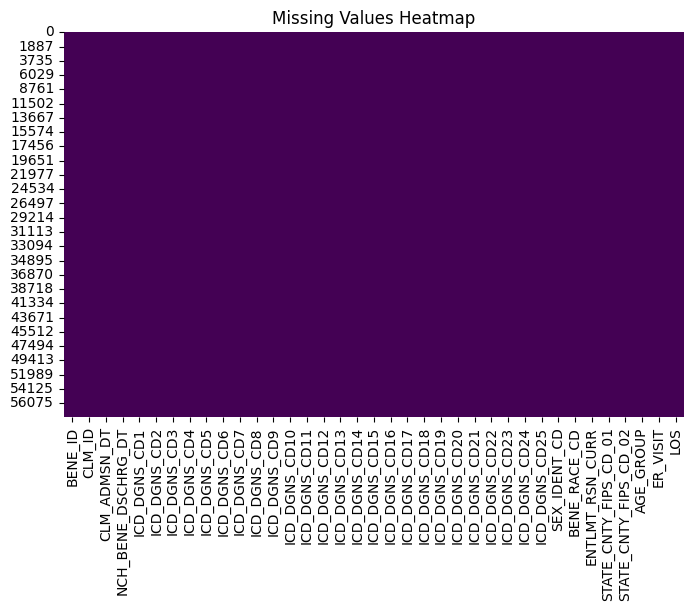

In [634]:
# Count of Missing Values
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.heatmap(merged_df.isnull(), cmap="viridis", cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

There is no mising values in the target variable ER_VISIT and Length of stay(LOS) variable. So, we can proceed with the analysis.

In [ ]:
# Categorical Distribution (AGE_GROUP, SEX_IDENT_CD, etc.)

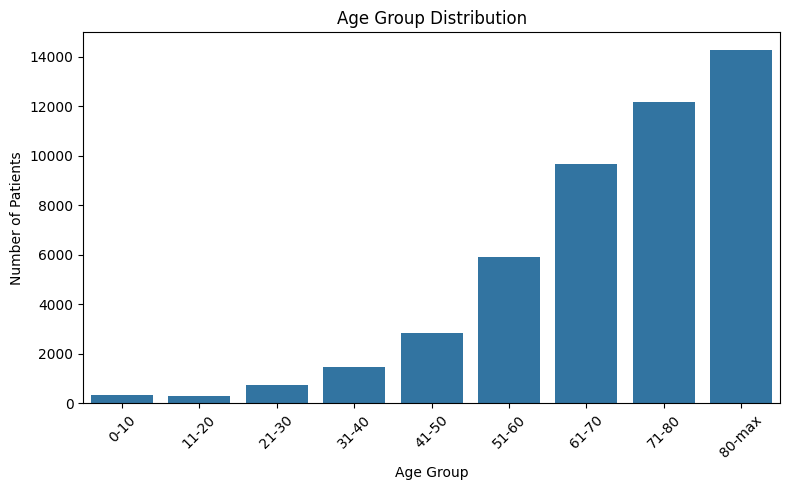

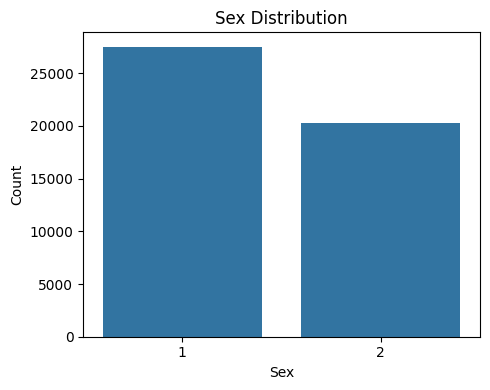

In [635]:
# Age group plot 
plt.figure(figsize=(8, 5))
sns.countplot(
    data=merged_df,
    x='AGE_GROUP',
    order=['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','80-max']
)
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sex distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=merged_df, x='SEX_IDENT_CD')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


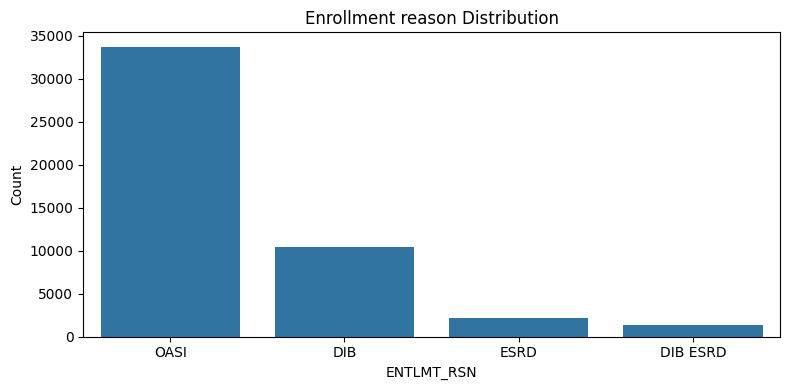

In [636]:
# Enrollment reason code distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=merged_df, x='ENTLMT_RSN_CURR')
plt.title('Enrollment reason Distribution')
plt.xlabel('ENTLMT_RSN')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# ENTLMT_RSN_CURR: Current Reason for Entitlement Code
0 = Old age and survivor’s insurance (OASI)
1 = Disability insurance benefits (DIB)
2 = End-stage renal disease (ESRD)
3 = Both DIB and ESRD


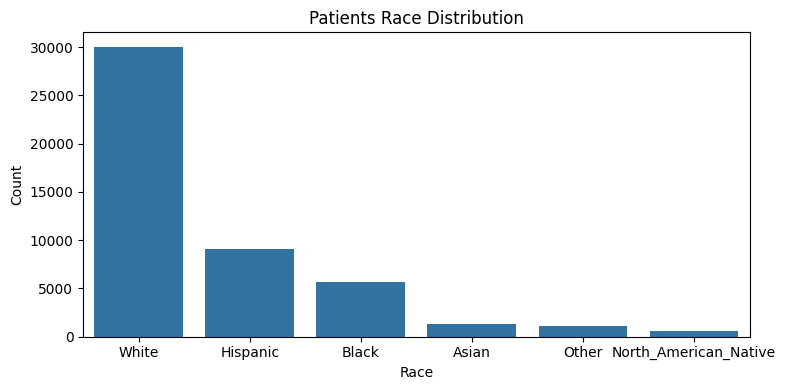

In [639]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get ordered list of races by count
race_order = merged_df['BENE_RACE_CD'].value_counts().index

# Plot
plt.figure(figsize=(8, 4))
sns.countplot(data=merged_df, x='BENE_RACE_CD', order=race_order)
plt.title('Patients Race Distribution')
plt.xlabel('Race')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


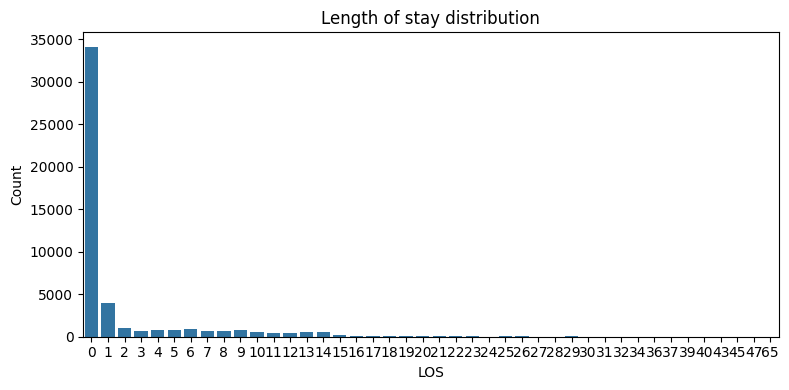

In [641]:
# LOS distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=merged_df, x='LOS')
plt.title('Length of stay distribution')
plt.xlabel('LOS')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
#merged_df['REV_CNTR'].unique()
#merged_df['BENE_RACE_CD'].unique()
#merged_df['ER_VISIT_FLAG'].unique()
#merged_df['PRNCPAL_DGNS_CD'].unique()
#merged_df['PRNCPAL_DGNS_CD'].value_counts()
#merged_df['CLM_ID'].value_counts()
merged_df['BENE_ID'].value_counts()
#merged_df['AGE_AT_END_REF_YR'].unique()
merged_df['SEX_IDENT_CD'].unique()
#merged_df['CLM_FAC_TYPE_CD'].unique()
#merged_df['REV_CNTR'].unique()
#merged_df['CLM_SRVC_CLSFCTN_TYPE_CD'].unique()
merged_df['BENE_RACE_CD'].unique()
merged_df.dtypes

In [644]:
#merged_df['LOS'].unique()
merged_df_encoded['LOS'].unique()

array([ 0,  1, 10, 11,  2,  3,  4, 14,  5,  9,  8,  6,  7, 26, 16, 23, 13,
       12, 20, 36, 45, 17, 15, 25, 18, 21, 22, 30, 28, 32, 19, 29, 24, 37,
       43, 40, 27, 34, 47, 39, 31, 65])

In [ ]:
merged_df.dtypes

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Encode categorical variables
df_plot = merged_df[['LOS', 'AGE_GROUP', 'SEX_IDENT_CD', 'BENE_RACE_CD','ENTLMT_RSN_CURR','ER_VISIT']].copy()
df_plot['AGE_GROUP'] = df_plot['AGE_GROUP'].astype('category').cat.codes
df_plot['SEX_IDENT_CD'] = df_plot['SEX_IDENT_CD'].astype('category').cat.codes
df_plot['BENE_RACE_CD'] = df_plot['BENE_RACE_CD'].astype('category').cat.codes

df_plot['ENTLMT_RSN_CURR'] = df_plot['ENTLMT_RSN_CURR'].astype('category').cat.codes
df_plot['ER_VISIT'] = df_plot['ER_VISIT'].astype(int)

# Step 3: Plot
sns.pairplot(df_plot, diag_kind='kde', hue='ER_VISIT')
plt.suptitle("Pair Plot of Selected Features", y=1.02)
plt.show()

In [646]:
df_plot.head()

LOS  AGE_GROUP  SEX_IDENT_CD  BENE_RACE_CD  ENTLMT_RSN_CURR  ER_VISIT
0    0          2             0             0                1         1
1    0          3             1             0                1         1
2    1          3             1             0                1         0
3    0          2             1             0                1         1
4    0          2             1             0                1         1

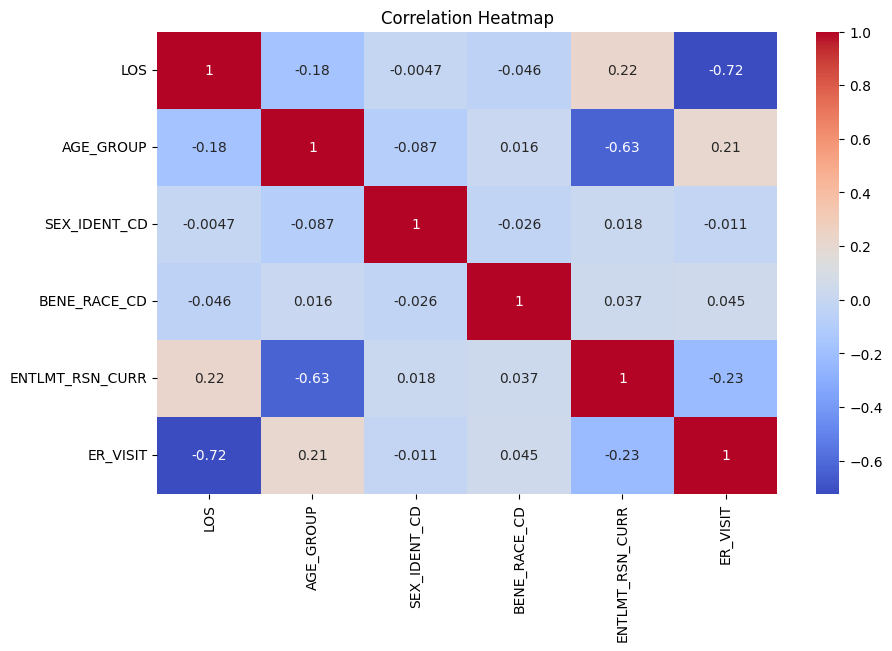

In [647]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_plot.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\2673994342.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = merged_df.groupby(['AGE_GROUP', 'ER_VISIT']).size().reset_index(name='counts')
C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\2673994342.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


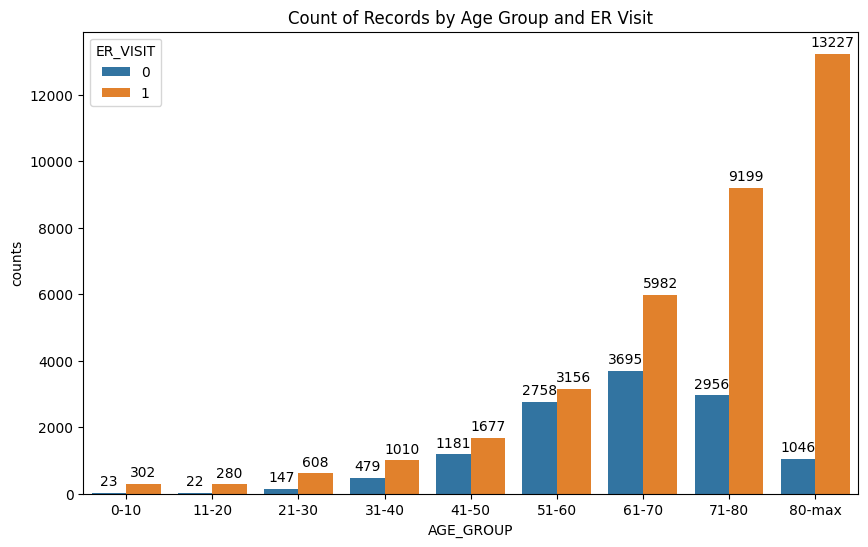

In [649]:
# Step 1: Aggregate counts
df_counts = merged_df.groupby(['AGE_GROUP', 'ER_VISIT']).size().reset_index(name='counts')

# Step 2: Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='AGE_GROUP',
    y='counts',
    hue='ER_VISIT',
    data=df_counts,
    ci=None
)
plt.title('Count of Records by Age Group and ER Visit')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.show()


C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\1428197323.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


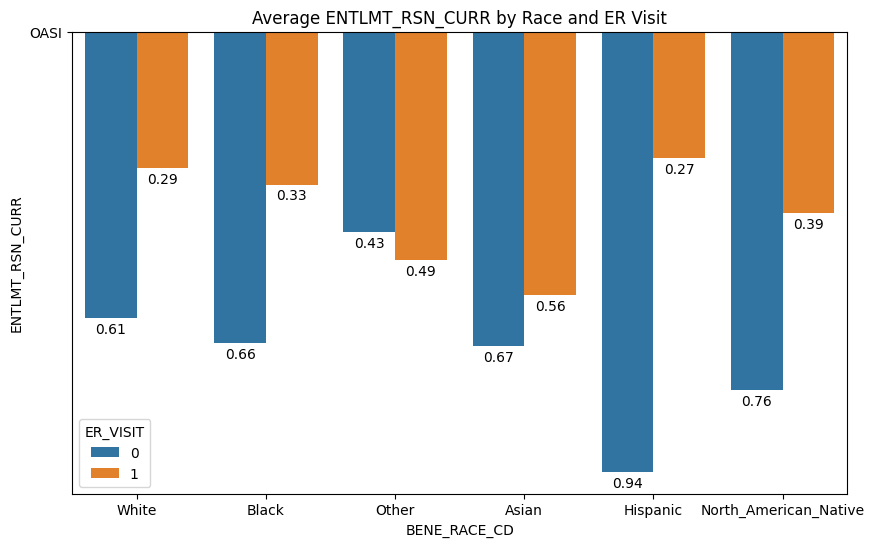

In [652]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='BENE_RACE_CD',
    y='ENTLMT_RSN_CURR',
    hue='ER_VISIT',
    data=merged_df,
    ci=None
)
plt.title('Average ENTLMT_RSN_CURR by Race and ER Visit')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.show()


In [ ]:
# Make multiple scatter plots for each valible

C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\3674399897.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_icd_los.values, y=top_icd_los.index, palette='viridis')


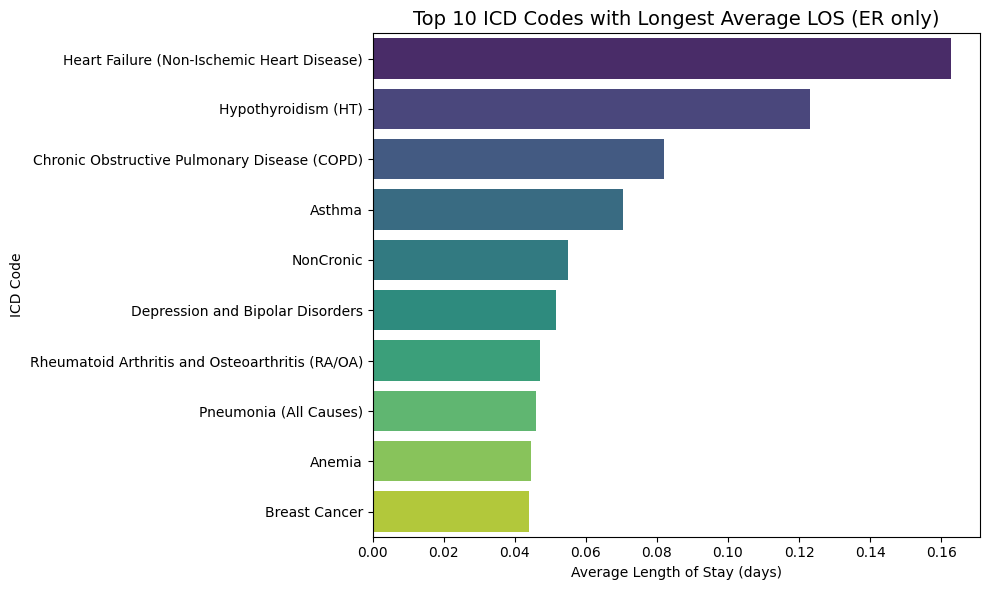

In [653]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Filter only patients who visited ER and have valid LOS
df_er = merged_df[(merged_df['ER_VISIT'] == 1) & (merged_df['LOS'].notnull())]

# Step 2: Melt ICD diagnosis columns into long format
icd_cols = [col for col in df_er.columns if col.startswith('ICD_DGNS_CD')]
df_long = df_er.melt(id_vars=['LOS'], value_vars=icd_cols, 
                     var_name='ICD_Column', value_name='ICD_Code')

# Step 3: Remove missing and non-chronic codes
df_long = df_long.dropna(subset=['ICD_Code'])
df_long = df_long[df_long['ICD_Code'] != 'ICD_NonCronic']  # if stored as string label

# Step 4: Group by ICD code and compute average LOS
avg_los_by_icd = df_long.groupby('ICD_Code')['LOS'].mean().sort_values(ascending=False)

# Step 5: Plot top 10 ICD codes with highest avg LOS
top_icd_los = avg_los_by_icd.head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_icd_los.values, y=top_icd_los.index, palette='viridis')
plt.title('Top 10 ICD Codes with Longest Average LOS (ER only)', fontsize=14)
plt.xlabel('Average Length of Stay (days)')
plt.ylabel('ICD Code')
plt.tight_layout()
plt.show()


Question: Which ICD conditions are most frequently observed in patients who go to the ER vs Non ER?

# Keep this one 
#This is only for ER patients

C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\3433181914.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=icd_counts.values, y=icd_counts.index, palette='magma')


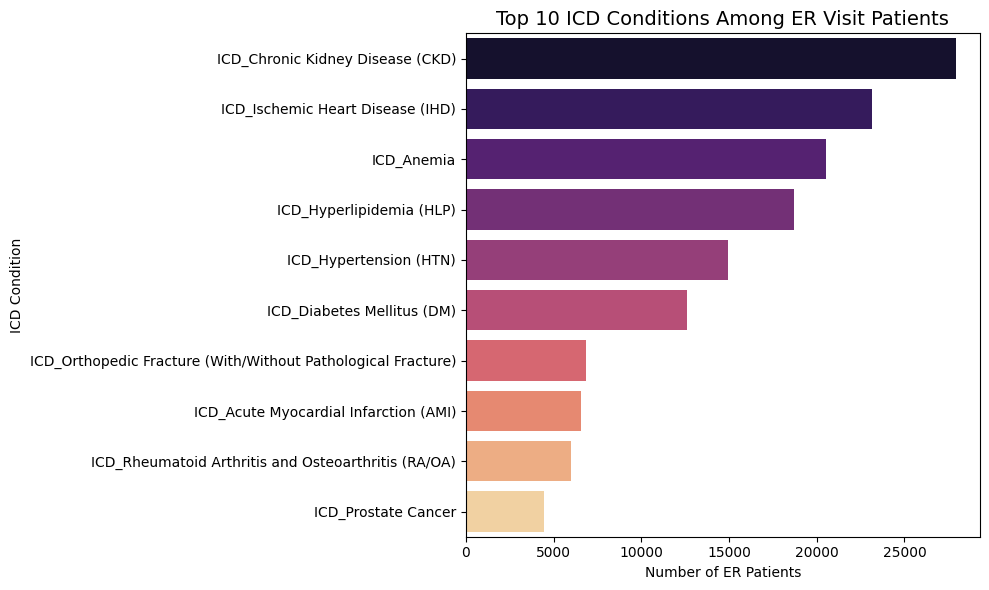

In [654]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Filter only ER visits
df_er = merged_df_encoded[merged_df_encoded['ER_VISIT'] == 1]

# Step 2: Get all ICD one-hot columns
icd_cols = [col for col in df_er.columns if col.startswith('ICD_')]

# Step 3: Sum across all ICD columns for ER patients
icd_counts = df_er[icd_cols].sum().sort_values(ascending=False).head(10)

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=icd_counts.values, y=icd_counts.index, palette='magma')
plt.title('Top 10 ICD Conditions Among ER Visit Patients', fontsize=14)
plt.xlabel('Number of ER Patients')
plt.ylabel('ICD Condition')
plt.tight_layout()
plt.show()


C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\936041761.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=icd_counts.values, y=icd_counts.index, palette='magma')


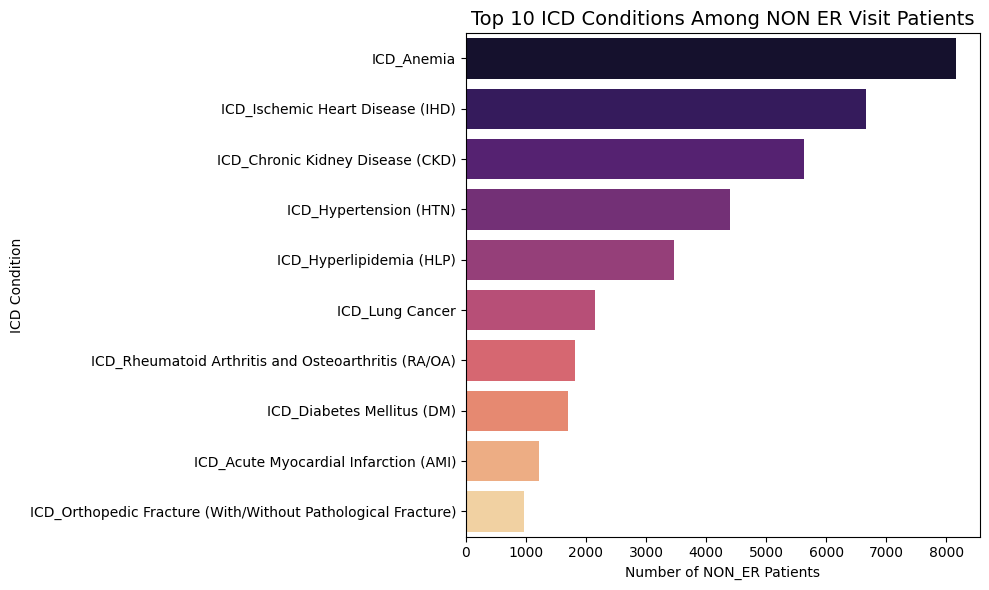

In [655]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Filter only ER visits
df_noner = merged_df_encoded[merged_df_encoded['ER_VISIT'] == 0]

# Step 2: Get all ICD one-hot columns
icd_cols = [col for col in df_noner.columns if col.startswith('ICD_')]

# Step 3: Sum across all ICD columns for ER patients
icd_counts = df_noner[icd_cols].sum().sort_values(ascending=False).head(10)

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=icd_counts.values, y=icd_counts.index, palette='magma')
plt.title('Top 10 ICD Conditions Among NON ER Visit Patients', fontsize=14)
plt.xlabel('Number of NON_ER Patients')
plt.ylabel('ICD Condition')
plt.tight_layout()
plt.show()

# Keep this 
# This is in all patient ER and Non ER

C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\1488979249.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_icd.values, y=top_icd.index, palette='magma')


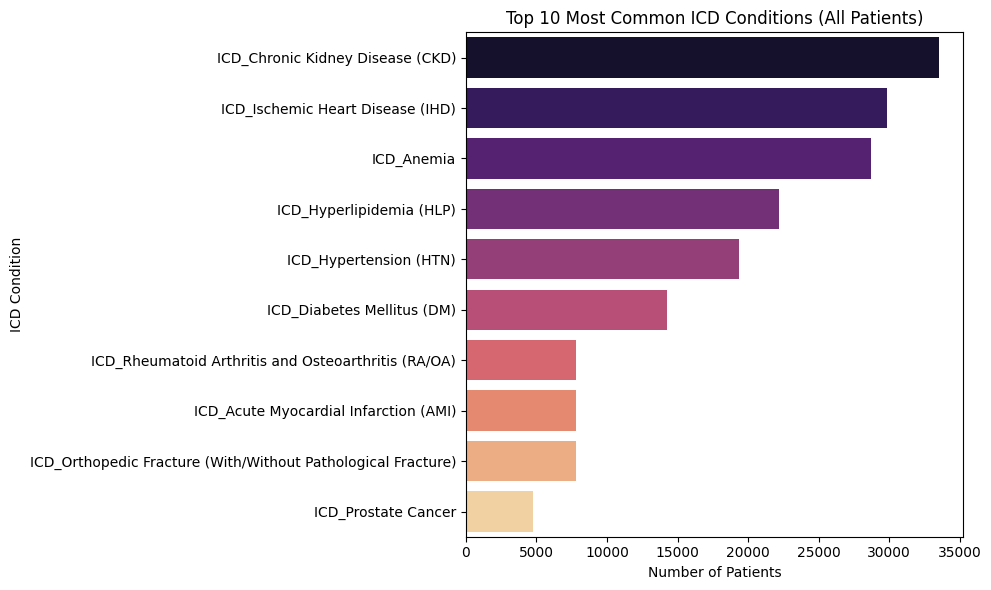

In [566]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Identify ICD columns (one-hot encoded)
icd_cols = [col for col in merged_df_encoded.columns if col.startswith('ICD_')]

# Step 2: Sum all occurrences of each ICD across all patients
icd_totals = merged_df_encoded[icd_cols].sum().sort_values(ascending=False)

# Step 3: Take top 10 most common ICDs
top_icd = icd_totals.head(10)

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_icd.values, y=top_icd.index, palette='magma')
plt.title('Top 10 Most Common ICD Conditions (All Patients)', fontsize=12)
plt.xlabel('Number of Patients')
plt.ylabel('ICD Condition')
plt.tight_layout()
plt.show()


In [ ]:
# THis is for ER and non ER patients

C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\4067478849.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icd_counts_top['Visit_Type'] = icd_counts_top['ER_VISIT'].map({0: 'Non-ER', 1: 'ER'})


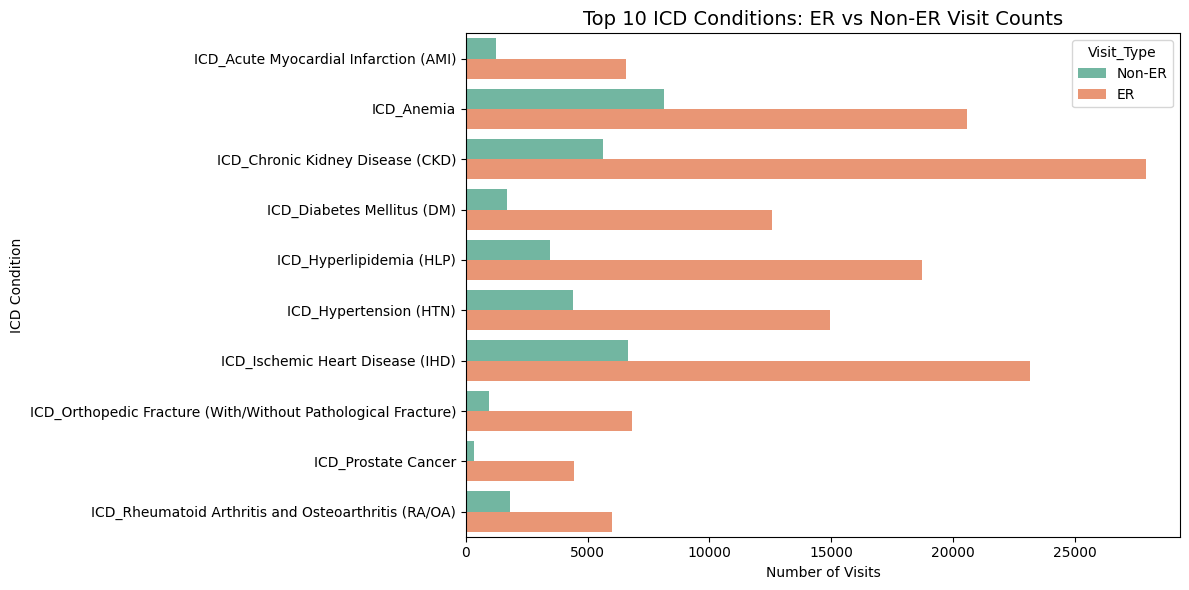

In [656]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Select ICD columns (binary encoded)
icd_cols = [col for col in merged_df_encoded.columns if col.startswith('ICD_')]

# Step 2: Melt data into long format
df_long = merged_df_encoded.melt(
    id_vars=['ER_VISIT'], 
    value_vars=icd_cols, 
    var_name='ICD_Condition', 
    value_name='Has_Condition'
)

# Step 3: Keep only rows where the ICD condition is present (value = 1)
df_long = df_long[df_long['Has_Condition'] == 1]

# Step 4: Group by ICD condition and ER_VISIT (0 = non-ER, 1 = ER)
icd_counts = df_long.groupby(['ICD_Condition', 'ER_VISIT']).size().reset_index(name='Count')

# Step 5: Get top 10 ICDs overall
top_icds = icd_counts.groupby('ICD_Condition')['Count'].sum().nlargest(10).index
icd_counts_top = icd_counts[icd_counts['ICD_Condition'].isin(top_icds)]

# Step 6: Replace ER_VISIT values with labels for better readability
icd_counts_top['Visit_Type'] = icd_counts_top['ER_VISIT'].map({0: 'Non-ER', 1: 'ER'})

# Step 7: Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=icd_counts_top, 
    x='Count', 
    y='ICD_Condition', 
    hue='Visit_Type', 
    palette='Set2'
)
plt.title('Top 10 ICD Conditions: ER vs Non-ER Visit Counts', fontsize=14)
plt.xlabel('Number of Visits')
plt.ylabel('ICD Condition')
plt.tight_layout()
plt.show()



In [657]:
merged_df_encoded.dtypes

BENE_ID                                                                 object
CLM_ID                                                                  object
CLM_ADMSN_DT                                                    datetime64[ns]
NCH_BENE_DSCHRG_DT                                              datetime64[ns]
SEX_IDENT_CD                                                          category
BENE_RACE_CD                                                          category
ENTLMT_RSN_CURR                                                       category
STATE_CNTY_FIPS_CD_01                                                   object
STATE_CNTY_FIPS_CD_02                                                   object
AGE_GROUP                                                             category
ER_VISIT                                                                 int64
LOS                                                                      int64
ADMIT_MONTH                                         

In [ ]:
df_plot.head
merged_df['LOS'].unique()
merged_df.shapes

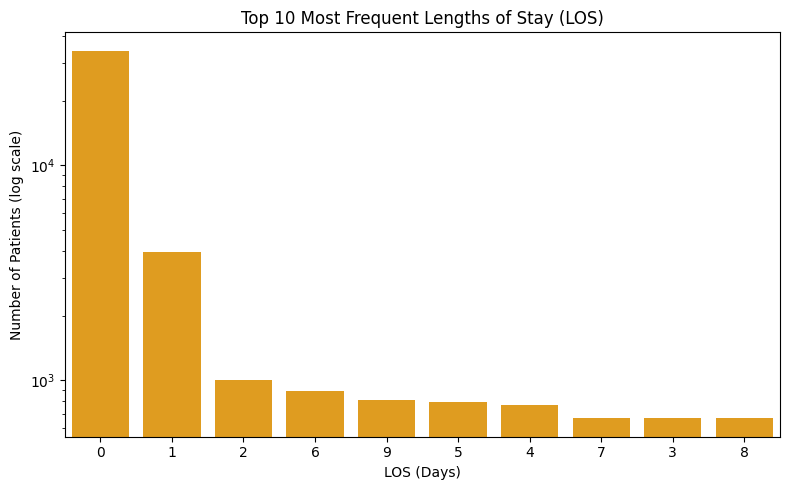

In [658]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get top 10 most frequent LOS values
top_10_los = merged_df['LOS'].value_counts().nlargest(10).index

# Filter data for those LOS values
filtered_df = merged_df[merged_df['LOS'].isin(top_10_los)]

plt.figure(figsize=(8, 5))
sns.countplot(x='LOS', data=filtered_df, order=top_10_los, color='orange')

plt.yscale('log')  # Apply log scale to y-axis

plt.title("Top 10 Most Frequent Lengths of Stay (LOS)")
plt.xlabel("LOS (Days)")
plt.ylabel("Number of Patients (log scale)")
plt.tight_layout()
plt.show()


In [ ]:
#LOS Over Time 
#Shows how the average length of stay is changing over time.



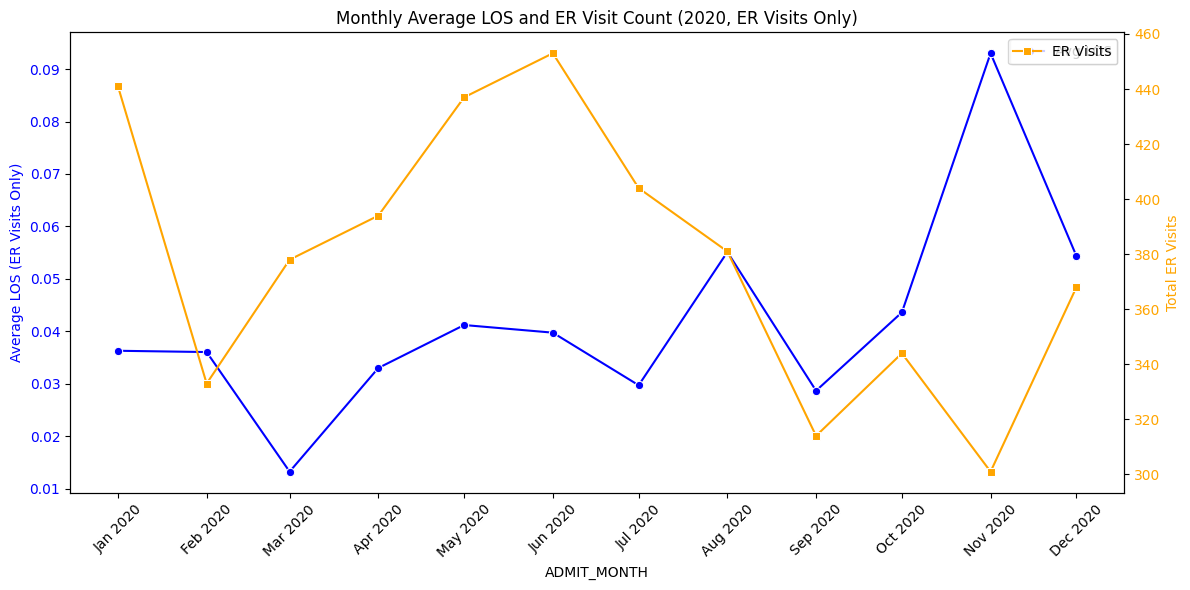

In [270]:
# Ensure ER_VISIT is treated as integer
merged_df['ER_VISIT'] = merged_df['ER_VISIT'].astype(int)

# Filter to 2020 AND ER visits only
df_2020_er = merged_df[
    (merged_df['CLM_ADMSN_DT'].dt.year == 2020) & 
    (merged_df['ER_VISIT'] == 1)
].copy()

# Create monthly column
df_2020_er['ADMIT_MONTH'] = df_2020_er['CLM_ADMSN_DT'].dt.to_period('M').dt.to_timestamp()

# Group by month: Average LOS and total ER visit count
monthly_stats = df_2020_er.groupby('ADMIT_MONTH').agg(
    avg_los=('LOS', 'mean'),
    er_visits=('ER_VISIT', 'count')  # since all are 1s, sum or count are same
).reset_index()

# Plot
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(12, 6))

# Avg LOS
sns.lineplot(data=monthly_stats, x='ADMIT_MONTH', y='avg_los', ax=ax1, marker='o', label='Avg LOS', color='blue')
ax1.set_ylabel('Average LOS (ER Visits Only)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# ER Visit Count
ax2 = ax1.twinx()
sns.lineplot(data=monthly_stats, x='ADMIT_MONTH', y='er_visits', ax=ax2, marker='s', label='ER Visits', color='orange')
ax2.set_ylabel('Total ER Visits', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Monthly Average LOS and ER Visit Count (2020, ER Visits Only)')
fig.tight_layout()
plt.show()


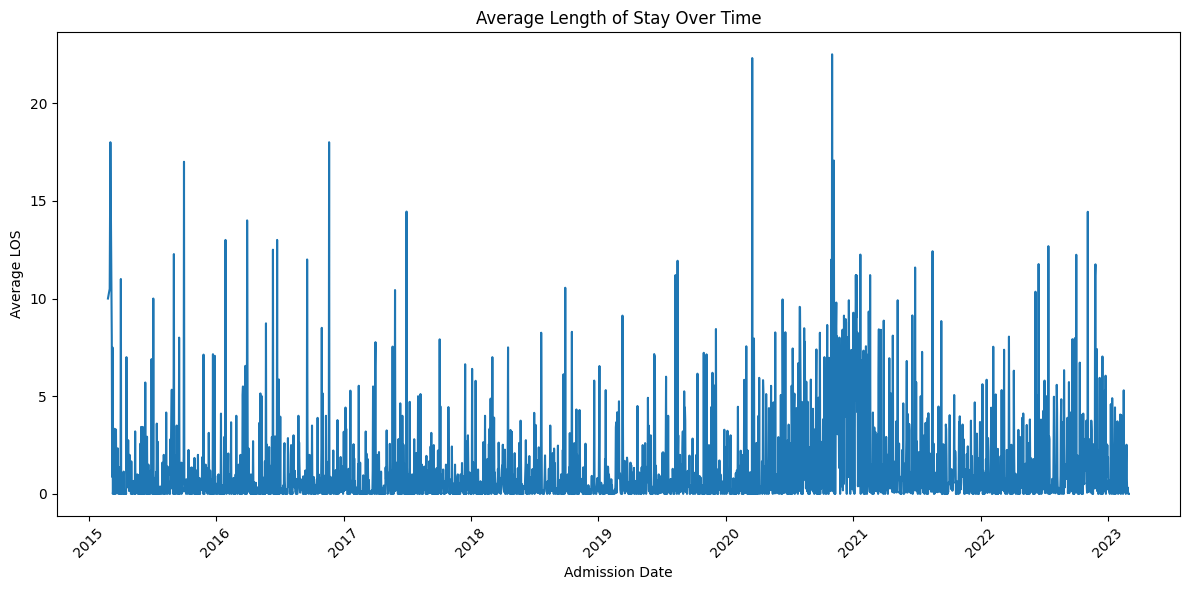

In [252]:
# Line chart
# Group by admission date and compute average LOS
df_line = merged_df.groupby('CLM_ADMSN_DT')['LOS'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='CLM_ADMSN_DT', y='LOS', data=df_line)
plt.title('Average Length of Stay Over Time')
plt.xlabel('Admission Date')
plt.ylabel('Average LOS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


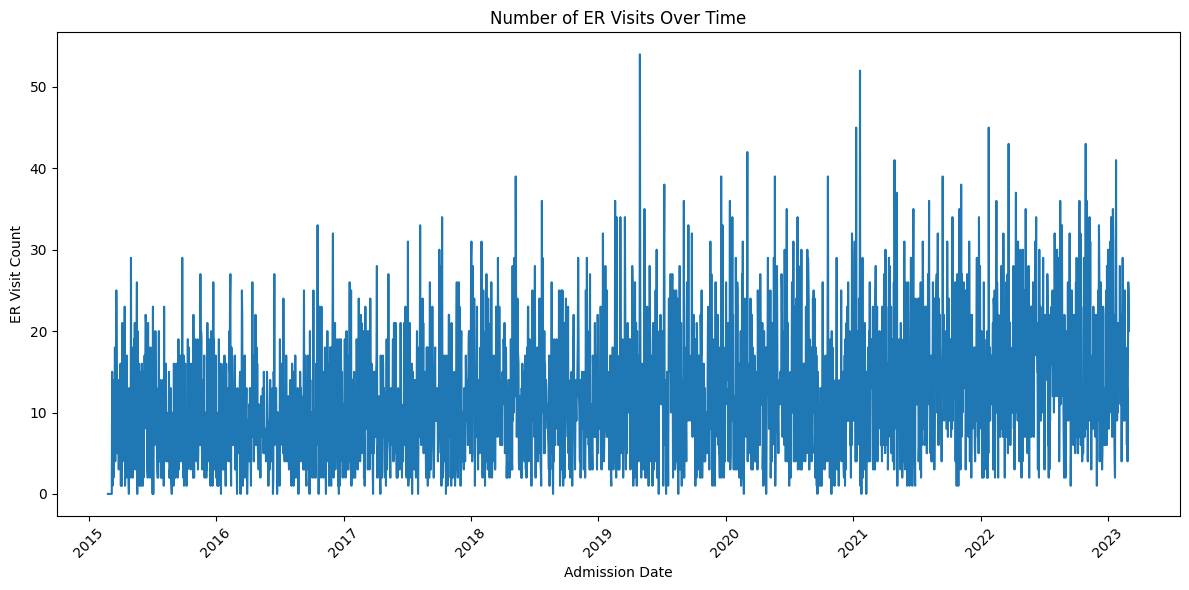

In [253]:
#Trend of ER Visits Over Time
df_er = merged_df.groupby('CLM_ADMSN_DT')['ER_VISIT'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='CLM_ADMSN_DT', y='ER_VISIT', data=df_er)
plt.title('Number of ER Visits Over Time')
plt.xlabel('Admission Date')
plt.ylabel('ER Visit Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


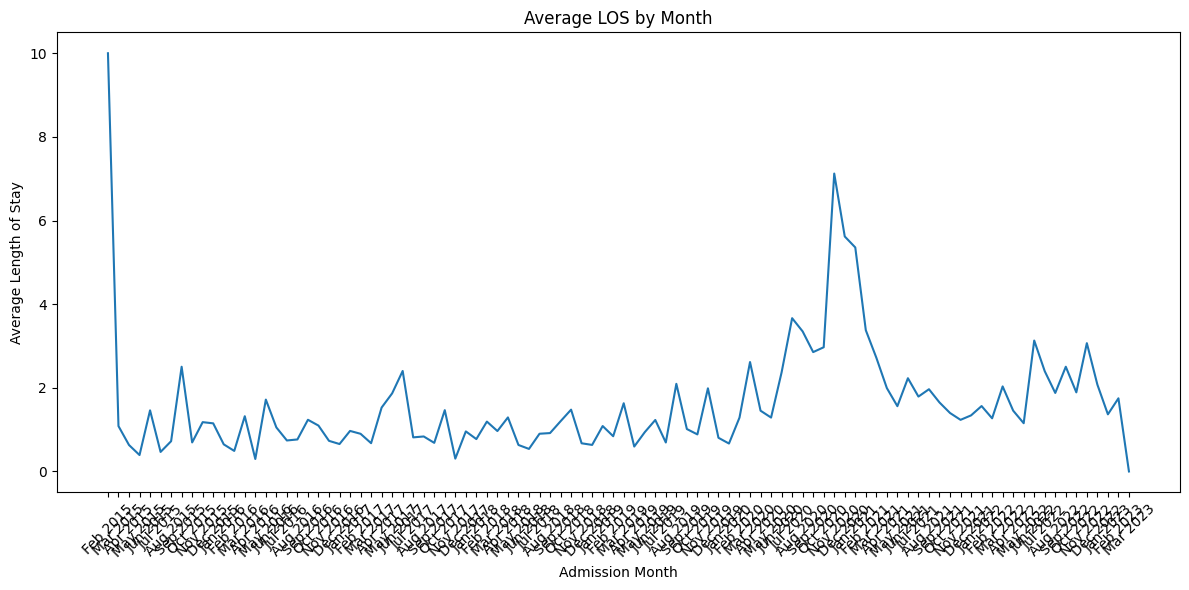

In [267]:
monthly_los['ADMIT_MONTH_STR'] = monthly_los['ADMIT_MONTH'].dt.strftime('%b %Y')

plt.figure(figsize=(12, 6))
sns.lineplot(x='ADMIT_MONTH_STR', y='LOS', data=monthly_los)
plt.title('Average LOS by Month')
plt.xlabel('Admission Month')
plt.ylabel('Average Length of Stay')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



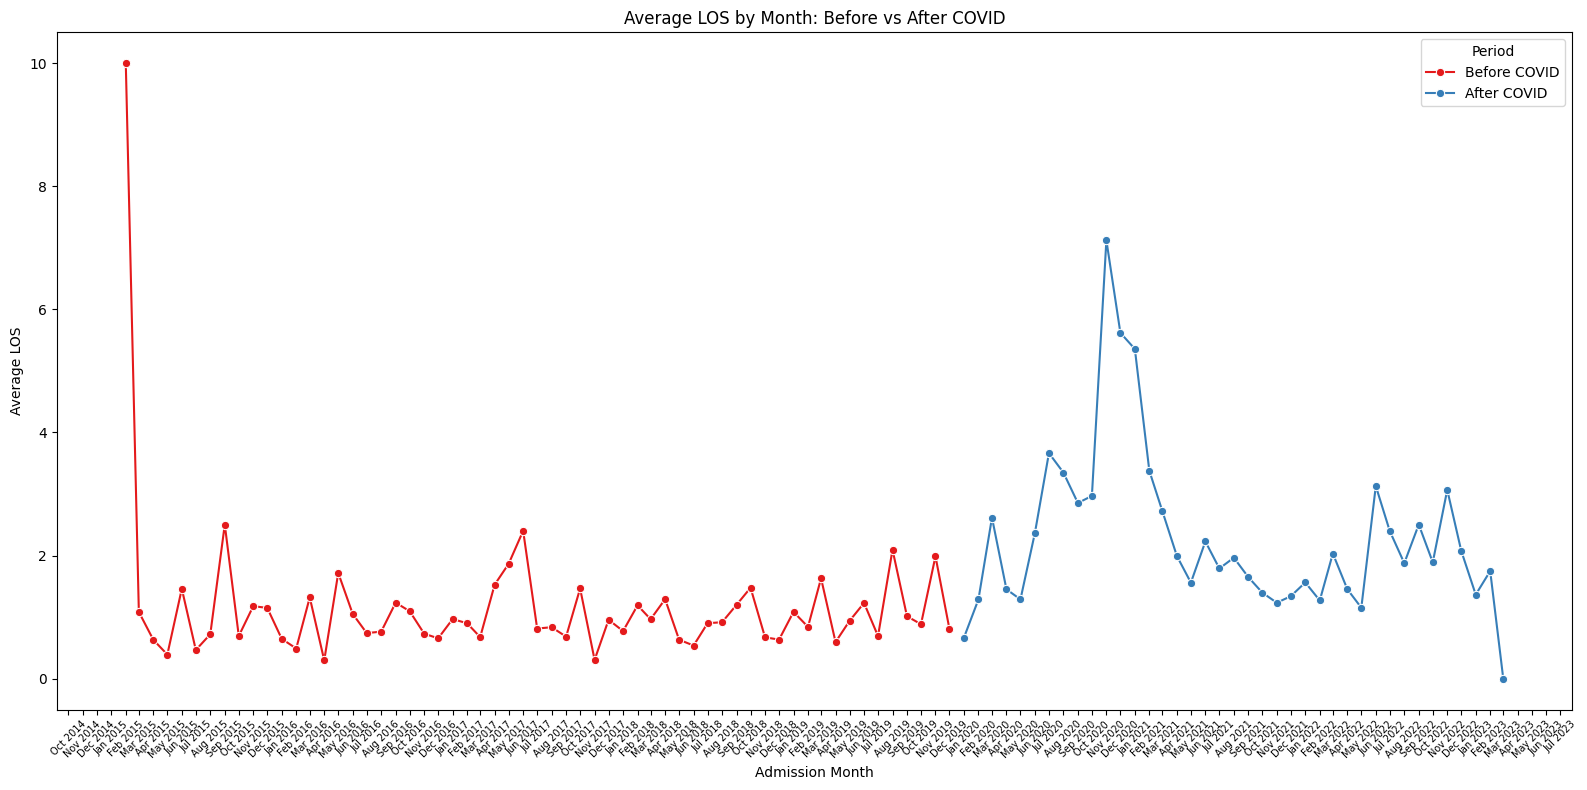

In [510]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure datetime format
monthly_los['ADMIT_MONTH'] = pd.to_datetime(monthly_los['ADMIT_MONTH'])

# Add period label
monthly_los['Period'] = monthly_los['ADMIT_MONTH'].apply(
    lambda x: 'Before COVID' if x.year < 2020 else 'After COVID'
)

# Sort by date to ensure correct plotting
monthly_los = monthly_los.sort_values('ADMIT_MONTH')

# Plot
plt.figure(figsize=(16, 8))
sns.lineplot(x='ADMIT_MONTH', y='LOS', hue='Period', data=monthly_los, marker='o', palette='Set1')

# Title and labels
plt.title('Average LOS by Month: Before vs After COVID')
plt.xlabel('Admission Month')
plt.ylabel('Average LOS')

# Rotate and adjust font size for X-axis
plt.xticks(rotation=45, fontsize=7)  # Smaller font size
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Adjust legend and layout
plt.legend(title='Period')
plt.tight_layout()

plt.show()



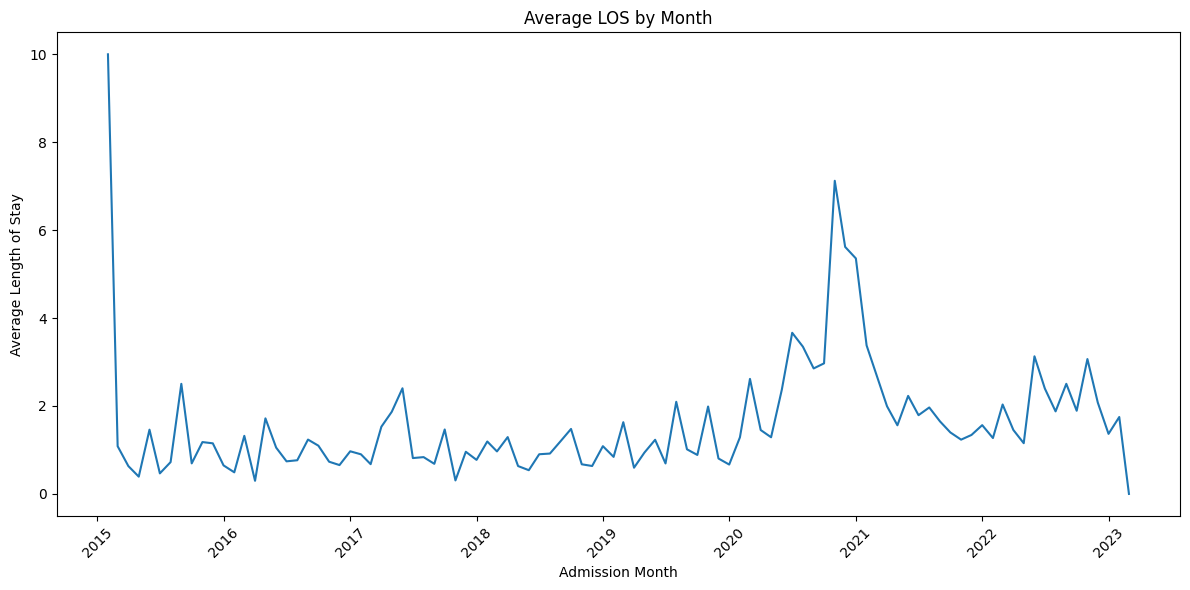

In [265]:
# Create a new column for admission month
merged_df['ADMIT_MONTH'] = merged_df['CLM_ADMSN_DT'].dt.to_period('M').dt.to_timestamp()

# Example: Average LOS by month
monthly_los = merged_df.groupby('ADMIT_MONTH')['LOS'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='ADMIT_MONTH', y='LOS', data=monthly_los)
plt.title('Average LOS by Month')
plt.xlabel('Admission Month')
plt.ylabel('Average Length of Stay')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


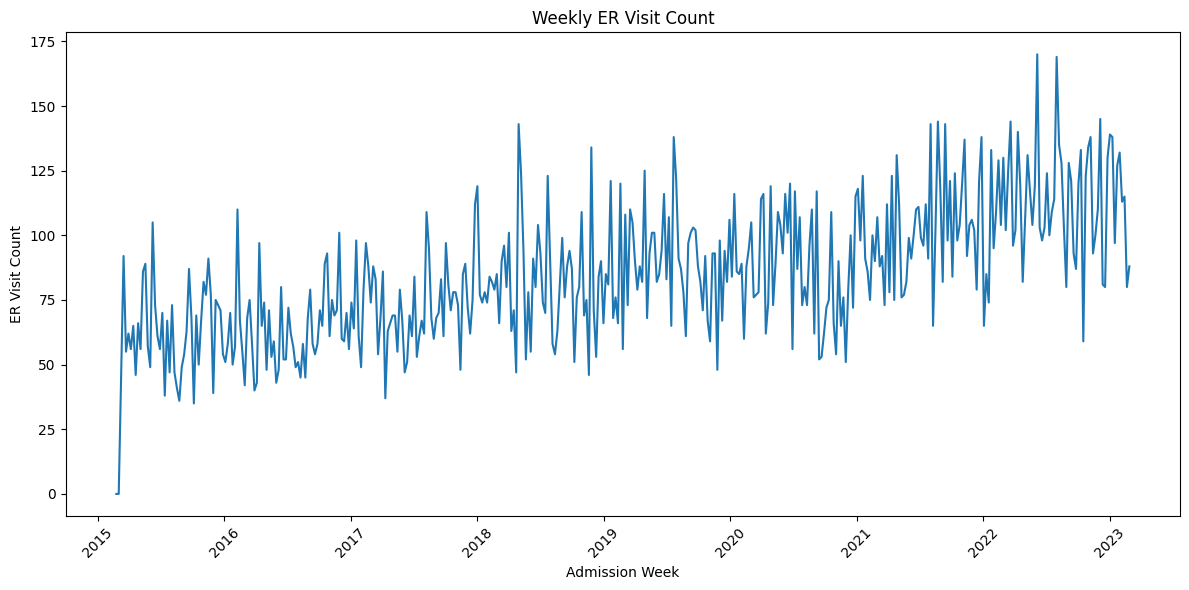

In [512]:
# Create a new column for admission week
merged_df['ADMIT_WEEK'] = merged_df['CLM_ADMSN_DT'].dt.to_period('W').dt.start_time

# Example: ER Visit counts by week
weekly_er = merged_df.groupby('ADMIT_WEEK')['ER_VISIT'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='ADMIT_WEEK', y='ER_VISIT', data=weekly_er)
plt.title('Weekly ER Visit Count')
plt.xlabel('Admission Week')
plt.ylabel('ER Visit Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\727338273.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DAY_TYPE', y='ER_VISIT', data=er_visits_daytype, palette='Set2')


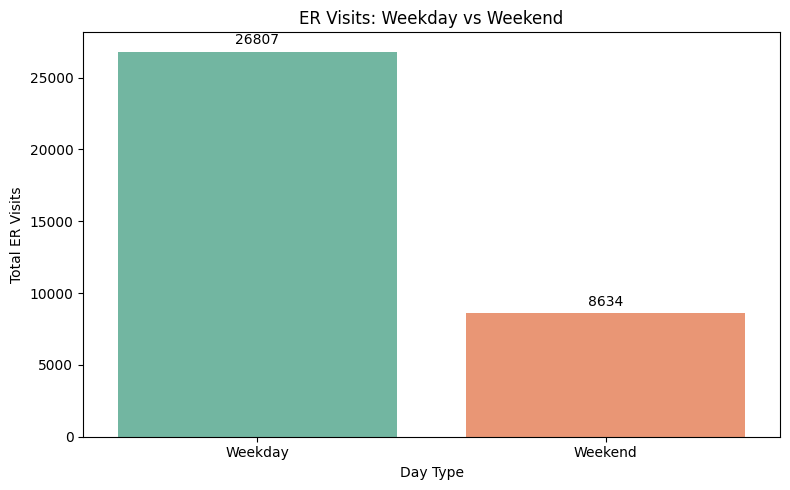

In [513]:
# Step 1: Create a column for day of week (0=Monday, 6=Sunday)
merged_df['ADMIT_DAY'] = merged_df['CLM_ADMSN_DT'].dt.dayofweek

# Step 2: Classify as Weekday or Weekend
merged_df['DAY_TYPE'] = merged_df['ADMIT_DAY'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Step 3: Aggregate ER visits by day type
er_visits_daytype = merged_df.groupby('DAY_TYPE')['ER_VISIT'].sum().reset_index()

# Step 4: Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='DAY_TYPE', y='ER_VISIT', data=er_visits_daytype, palette='Set2')

# Add labels
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', padding=3)

plt.title('ER Visits: Weekday vs Weekend')
plt.xlabel('Day Type')
plt.ylabel('Total ER Visits')
plt.tight_layout()
plt.show()


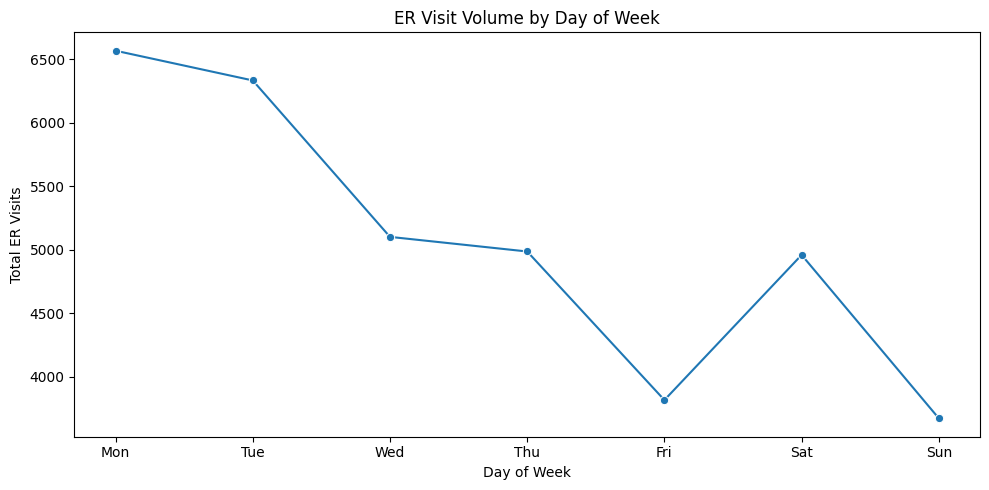

In [514]:
# Group by day of week (0=Monday, ..., 6=Sunday)
daily_er = merged_df.groupby(merged_df['CLM_ADMSN_DT'].dt.dayofweek)['ER_VISIT'].sum().reset_index()
daily_er.columns = ['DayOfWeek', 'ER_VISIT']

plt.figure(figsize=(10, 5))
sns.lineplot(x='DayOfWeek', y='ER_VISIT', data=daily_er, marker='o')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('ER Visit Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total ER Visits')
plt.tight_layout()
plt.show()


This chart helps you see which days of the week tend to have more ER visits, which can be important for:
Hospital staffing
Emergency department planning
Understanding patient behavior

In [ ]:
# THis is code Keep it 

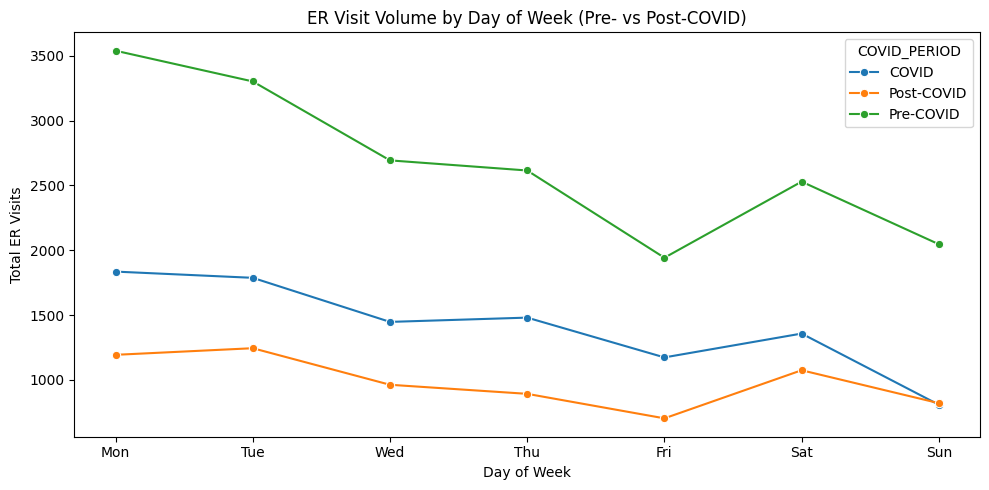

In [534]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add a new column to label pre/post COVID
merged_df['COVID_PERIOD'] = merged_df['CLM_ADMSN_DT'].apply(
    lambda x: 'Pre-COVID' if x.year < 2020 else ('Post-COVID' if x.year > 2021 else 'COVID')
)

# Group by day of week and COVID period
daily_er_covid = merged_df.groupby([
    merged_df['CLM_ADMSN_DT'].dt.dayofweek, 
    'COVID_PERIOD'
])['ER_VISIT'].sum().reset_index()

daily_er_covid.columns = ['DayOfWeek', 'COVID_PERIOD', 'ER_VISIT']

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_er_covid, x='DayOfWeek', y='ER_VISIT', hue='COVID_PERIOD', marker='o')

# Set day labels
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('ER Visit Volume by Day of Week (Pre- vs Post-COVID)')
plt.xlabel('Day of Week')
plt.ylabel('Total ER Visits')
plt.tight_layout()
plt.show()


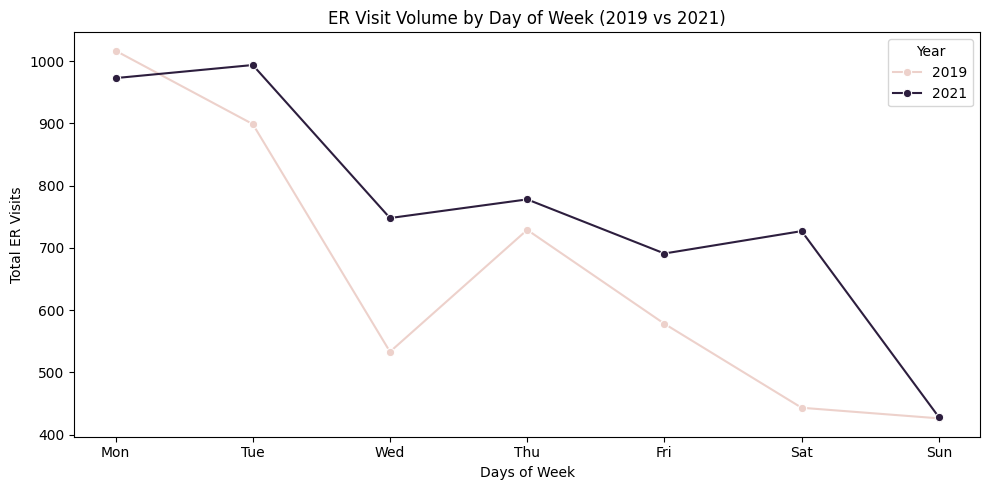

In [529]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only 2018 and 2020 data
df_filtered = merged_df[merged_df['CLM_ADMSN_DT'].dt.year.isin([2019, 2021])].copy()

# Add a column for year
df_filtered['Year'] = df_filtered['CLM_ADMSN_DT'].dt.year

# Group by day of week and year
daily_er_year = df_filtered.groupby([
    df_filtered['CLM_ADMSN_DT'].dt.dayofweek,
    'Year'
])['ER_VISIT'].sum().reset_index()

daily_er_year.columns = ['DayOfWeek', 'Year', 'ER_VISIT']

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_er_year, x='DayOfWeek', y='ER_VISIT', hue='Year', marker='o')

# Set day labels
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('ER Visit Volume by Day of Week (2019 vs 2021)')
plt.xlabel('Days of Week')
plt.ylabel('Total ER Visits')
plt.tight_layout()
plt.show()


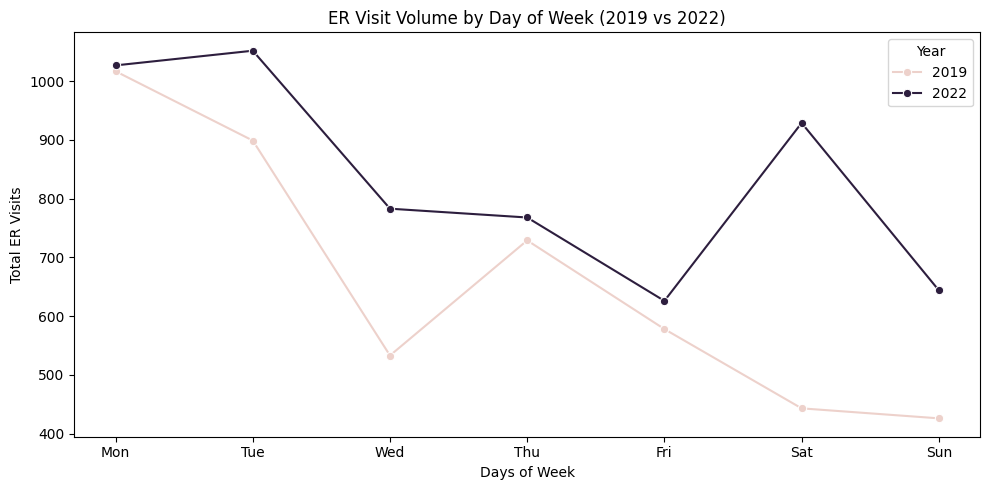

In [528]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only 2018 and 2020 data
df_filtered = merged_df[merged_df['CLM_ADMSN_DT'].dt.year.isin([2019, 2022])].copy()

# Add a column for year
df_filtered['Year'] = df_filtered['CLM_ADMSN_DT'].dt.year

# Group by day of week and year
daily_er_year = df_filtered.groupby([
    df_filtered['CLM_ADMSN_DT'].dt.dayofweek,
    'Year'
])['ER_VISIT'].sum().reset_index()

daily_er_year.columns = ['DayOfWeek', 'Year', 'ER_VISIT']

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_er_year, x='DayOfWeek', y='ER_VISIT', hue='Year', marker='o')

# Set day labels
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('ER Visit Volume by Day of Week (2019 vs 2022)')
plt.xlabel('Days of Week')
plt.ylabel('Total ER Visits')
plt.tight_layout()
plt.show()

In [519]:
daily_er.head(7)

DayOfWeek  ER_VISIT
0          0      6567
1          1      6333
2          2      5102
3          3      4987
4          4      3818
5          5      4960
6          6      3674

In [259]:
merged_df.dtypes

BENE_ID                          object
CLM_ID                           object
CLM_ADMSN_DT             datetime64[ns]
NCH_BENE_DSCHRG_DT       datetime64[ns]
ICD_DGNS_CD1                     object
ICD_DGNS_CD2                     object
ICD_DGNS_CD3                     object
ICD_DGNS_CD4                     object
ICD_DGNS_CD5                     object
ICD_DGNS_CD6                     object
ICD_DGNS_CD7                     object
ICD_DGNS_CD8                     object
ICD_DGNS_CD9                     object
ICD_DGNS_CD10                    object
ICD_DGNS_CD11                    object
ICD_DGNS_CD12                    object
ICD_DGNS_CD13                    object
ICD_DGNS_CD14                    object
ICD_DGNS_CD15                    object
ICD_DGNS_CD16                    object
ICD_DGNS_CD17                    object
ICD_DGNS_CD18                    object
ICD_DGNS_CD19                    object
ICD_DGNS_CD20                    object
ICD_DGNS_CD21                    object


In [ ]:
merged_df['ADMIT_MONTH'] = merged_df['CLM_ADMSN_DT'].dt.to_period('M').dt.to_timestamp()


# Prepare data for modeling
# Add dummies for categorical variables

In [659]:
# Step 1: Get all ICD columns
icd_cols = [col for col in merged_df.columns if col.startswith('ICD_DGNS_CD')]


In [660]:
# Step 2: One-hot encode all 25 columns and concatenate
encoded_icd_df = pd.get_dummies(merged_df[icd_cols].stack(), prefix='ICD').groupby(level=0).max()
encoded_icd_df.head()


ICD_Acute Myocardial Infarction (AMI)  ICD_Alzheimer's Disease (AD)  \
0                                  False                         False   
1                                  False                         False   
2                                  False                         False   
3                                  False                         False   
4                                  False                         False   

   ICD_Anemia  ICD_Asthma  ICD_Atrial Fibrillation and Flutter  \
0        True       False                                False   
1       False       False                                False   
2       False       False                                False   
3       False       False                                False   
4       False       False                                False   

   ICD_Breast Cancer  ICD_Chronic Kidney Disease (CKD)  \
0              False                             False   
1               True                             False   
2               True                             False   
3              False                             False   
4              False                             False   

   ICD_Chronic Obstructive Pulmonary Disease (COPD)  ICD_Colorectal Cancer  \
0                                             False                  False   
1                                             False                  False   
2                                             False                  False   
3                                             False                  False   
4                                             False                  False   

   ICD_Depression and Bipolar Disorders  ...  ICD_Hypertension (HTN)  \
0                                 False  ...                   False   
1                                 False  ...                   False   
2                                 False  ...                   False   
3                                 False  ...                   False   
4                                 False  ...                   False   

   ICD_Hypothyroidism (HT)  ICD_Ischemic Heart Disease (IHD)  ICD_Lung Cancer  \
0                    False                             False            False   
1                    False                             False            False   
2                    False                             False            False   
3                    False                             False            False   
4                    False                             False            False   

   ICD_No Abnormality Detected (NAD)  ICD_NonCronic  \
0                              False           True   
1                              False           True   
2                              False           True   
3                              False           True   
4                              False           True   

   ICD_Orthopedic Fracture (With/Without Pathological Fracture)  \
0                                              False              
1                                              False              
2                                              False              
3                                              False              
4                                              False              

   ICD_Pneumonia (All Causes)  ICD_Prostate Cancer  \
0                       False                False   
1                       False                False   
2                       False                False   
3                       False                False   
4                       False                False   

   ICD_Rheumatoid Arthritis and Osteoarthritis (RA/OA)  
0                                              False    
1                                              False    
2                                              False    
3                                              False    
4                                              False    

[5 rows x 23 columns]

In [661]:
# Step 3: Add encoded ICDs to main df
merged_df_encoded = pd.concat([merged_df, encoded_icd_df], axis=1)

merged_df.head()

BENE_ID          CLM_ID CLM_ADMSN_DT NCH_BENE_DSCHRG_DT  \
0  10000010254618  10000930037831   2015-03-25         2015-03-25   
1  10000010254653  10000930038030   2015-09-24         2015-09-24   
2  10000010254653  10000930038031   2017-05-09         2017-05-10   
3  10000010254656  10000930038162   2017-01-14         2017-01-14   
4  10000010254656  10000930038162   2017-01-14         2017-01-14   

  ICD_DGNS_CD1 ICD_DGNS_CD2          ICD_DGNS_CD3 ICD_DGNS_CD4  \
0    NonCronic    NonCronic  Hyperlipidemia (HLP)    NonCronic   
1    NonCronic    NonCronic         Breast Cancer    NonCronic   
2    NonCronic    NonCronic         Breast Cancer    NonCronic   
3    NonCronic    NonCronic             NonCronic    NonCronic   
4    NonCronic    NonCronic             NonCronic    NonCronic   

             ICD_DGNS_CD5 ICD_DGNS_CD6  ... ICD_DGNS_CD24 ICD_DGNS_CD25  \
0  Diabetes Mellitus (DM)       Anemia  ...     NonCronic     NonCronic   
1               NonCronic    NonCronic  ...     NonCronic     NonCronic   
2               NonCronic    NonCronic  ...     NonCronic     NonCronic   
3               NonCronic    NonCronic  ...     NonCronic     NonCronic   
4               NonCronic    NonCronic  ...     NonCronic     NonCronic   

  SEX_IDENT_CD BENE_RACE_CD ENTLMT_RSN_CURR STATE_CNTY_FIPS_CD_01  \
0            1        White             DIB                  1101   
1            2        White             DIB                  1081   
2            2        White             DIB                  1081   
3            2        White             DIB                  1073   
4            2        White             DIB                  1073   

  STATE_CNTY_FIPS_CD_02 AGE_GROUP ER_VISIT LOS  
0                  1101     21-30        1   0  
1                  1081     31-40        1   0  
2                  1081     31-40        0   1  
3                  1073     21-30        1   0  
4                  1073     21-30        1   0  

[5 rows x 37 columns]

In [662]:
merged_df_encoded.head()

BENE_ID          CLM_ID CLM_ADMSN_DT NCH_BENE_DSCHRG_DT  \
0  10000010254618  10000930037831   2015-03-25         2015-03-25   
1  10000010254653  10000930038030   2015-09-24         2015-09-24   
2  10000010254653  10000930038031   2017-05-09         2017-05-10   
3  10000010254656  10000930038162   2017-01-14         2017-01-14   
4  10000010254656  10000930038162   2017-01-14         2017-01-14   

  ICD_DGNS_CD1 ICD_DGNS_CD2          ICD_DGNS_CD3 ICD_DGNS_CD4  \
0    NonCronic    NonCronic  Hyperlipidemia (HLP)    NonCronic   
1    NonCronic    NonCronic         Breast Cancer    NonCronic   
2    NonCronic    NonCronic         Breast Cancer    NonCronic   
3    NonCronic    NonCronic             NonCronic    NonCronic   
4    NonCronic    NonCronic             NonCronic    NonCronic   

             ICD_DGNS_CD5 ICD_DGNS_CD6  ... ICD_Hypertension (HTN)  \
0  Diabetes Mellitus (DM)       Anemia  ...                  False   
1               NonCronic    NonCronic  ...                  False   
2               NonCronic    NonCronic  ...                  False   
3               NonCronic    NonCronic  ...                  False   
4               NonCronic    NonCronic  ...                  False   

  ICD_Hypothyroidism (HT) ICD_Ischemic Heart Disease (IHD) ICD_Lung Cancer  \
0                   False                            False           False   
1                   False                            False           False   
2                   False                            False           False   
3                   False                            False           False   
4                   False                            False           False   

  ICD_No Abnormality Detected (NAD) ICD_NonCronic  \
0                             False          True   
1                             False          True   
2                             False          True   
3                             False          True   
4                             False          True   

  ICD_Orthopedic Fracture (With/Without Pathological Fracture)  \
0                                              False             
1                                              False             
2                                              False             
3                                              False             
4                                              False             

  ICD_Pneumonia (All Causes) ICD_Prostate Cancer  \
0                      False               False   
1                      False               False   
2                      False               False   
3                      False               False   
4                      False               False   

  ICD_Rheumatoid Arthritis and Osteoarthritis (RA/OA)  
0                                              False   
1                                              False   
2                                              False   
3                                              False   
4                                              False   

[5 rows x 60 columns]

In [ ]:
merged_df_encoded.columns.tolist()

In [664]:
icd_cols = [f'ICD_DGNS_CD{i}' for i in range(1, 26)]


In [665]:
# Drop those columns only if they exist
icd_cols = [col for col in icd_cols if col in merged_df_encoded.columns]
merged_df_encoded.drop(columns=icd_cols, inplace=True)


In [667]:
merged_df_encoded.head()

BENE_ID          CLM_ID CLM_ADMSN_DT NCH_BENE_DSCHRG_DT  \
0  10000010254618  10000930037831   2015-03-25         2015-03-25   
1  10000010254653  10000930038030   2015-09-24         2015-09-24   
2  10000010254653  10000930038031   2017-05-09         2017-05-10   
3  10000010254656  10000930038162   2017-01-14         2017-01-14   
4  10000010254656  10000930038162   2017-01-14         2017-01-14   

  SEX_IDENT_CD BENE_RACE_CD ENTLMT_RSN_CURR STATE_CNTY_FIPS_CD_01  \
0            1        White             DIB                  1101   
1            2        White             DIB                  1081   
2            2        White             DIB                  1081   
3            2        White             DIB                  1073   
4            2        White             DIB                  1073   

  STATE_CNTY_FIPS_CD_02 AGE_GROUP  ...  ICD_Hypertension (HTN)  \
0                  1101     21-30  ...                   False   
1                  1081     31-40  ...                   False   
2                  1081     31-40  ...                   False   
3                  1073     21-30  ...                   False   
4                  1073     21-30  ...                   False   

   ICD_Hypothyroidism (HT)  ICD_Ischemic Heart Disease (IHD)  ICD_Lung Cancer  \
0                    False                             False            False   
1                    False                             False            False   
2                    False                             False            False   
3                    False                             False            False   
4                    False                             False            False   

   ICD_No Abnormality Detected (NAD)  ICD_NonCronic  \
0                              False           True   
1                              False           True   
2                              False           True   
3                              False           True   
4                              False           True   

   ICD_Orthopedic Fracture (With/Without Pathological Fracture)  \
0                                              False              
1                                              False              
2                                              False              
3                                              False              
4                                              False              

   ICD_Pneumonia (All Causes)  ICD_Prostate Cancer  \
0                       False                False   
1                       False                False   
2                       False                False   
3                       False                False   
4                       False                False   

   ICD_Rheumatoid Arthritis and Osteoarthritis (RA/OA)  
0                                              False    
1                                              False    
2                                              False    
3                                              False    
4                                              False    

[5 rows x 35 columns]

In [ ]:
merged_df_encoded.dtypes

In [669]:
#merged_df_encoded = merged_df_encoded.drop(columns=['ICD_NonCronic'])
# Drop  ICD_NonCronic column
merged_df_encoded = merged_df_encoded.drop('ICD_NonCronic', axis=1, errors='ignore')

In [ ]:
merged_df_encoded.columns.tolist()
#merged_df_encoded.shape

In [671]:
# Show duplicate columns
dupes = merged_df_encoded.columns[merged_df_encoded.columns.duplicated()]
print("Duplicate columns:\n", dupes)


Duplicate columns:
 Index([], dtype='object')


In [ ]:
# drop the duplicate columns
#merged_df_encoded = merged_df_encoded.loc[:, ~merged_df_encoded.columns.duplicated()]


In [672]:
# Convert booolean to int
bool_cols = merged_df_encoded.select_dtypes(include='bool').columns
merged_df_encoded[bool_cols] = merged_df_encoded[bool_cols].astype(int)


In [673]:
# Check data again
merged_df_encoded.head()

BENE_ID          CLM_ID CLM_ADMSN_DT NCH_BENE_DSCHRG_DT  \
0  10000010254618  10000930037831   2015-03-25         2015-03-25   
1  10000010254653  10000930038030   2015-09-24         2015-09-24   
2  10000010254653  10000930038031   2017-05-09         2017-05-10   
3  10000010254656  10000930038162   2017-01-14         2017-01-14   
4  10000010254656  10000930038162   2017-01-14         2017-01-14   

  SEX_IDENT_CD BENE_RACE_CD ENTLMT_RSN_CURR STATE_CNTY_FIPS_CD_01  \
0            1        White             DIB                  1101   
1            2        White             DIB                  1081   
2            2        White             DIB                  1081   
3            2        White             DIB                  1073   
4            2        White             DIB                  1073   

  STATE_CNTY_FIPS_CD_02 AGE_GROUP  ...  ICD_Hyperlipidemia (HLP)  \
0                  1101     21-30  ...                         1   
1                  1081     31-40  ...                         0   
2                  1081     31-40  ...                         0   
3                  1073     21-30  ...                         0   
4                  1073     21-30  ...                         0   

   ICD_Hypertension (HTN)  ICD_Hypothyroidism (HT)  \
0                       0                        0   
1                       0                        0   
2                       0                        0   
3                       0                        0   
4                       0                        0   

   ICD_Ischemic Heart Disease (IHD)  ICD_Lung Cancer  \
0                                 0                0   
1                                 0                0   
2                                 0                0   
3                                 0                0   
4                                 0                0   

   ICD_No Abnormality Detected (NAD)  \
0                                  0   
1                                  0   
2                                  0   
3                                  0   
4                                  0   

   ICD_Orthopedic Fracture (With/Without Pathological Fracture)  \
0                                                  0              
1                                                  0              
2                                                  0              
3                                                  0              
4                                                  0              

   ICD_Pneumonia (All Causes)  ICD_Prostate Cancer  \
0                           0                    0   
1                           0                    0   
2                           0                    0   
3                           0                    0   
4                           0                    0   

   ICD_Rheumatoid Arthritis and Osteoarthritis (RA/OA)  
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

[5 rows x 34 columns]

In [ ]:
merged_df_encoded.dtypes
merged_df_encoded.columns.tolist()
merged_df_encoded.dtypes

In [ ]:
# merged_df_encoded is encoded for all ICD coed and ER visit  and raeady for Modeling
#merged_df_encoded.to_csv('Cleaned_merged_df_encoded.csv', index=False)

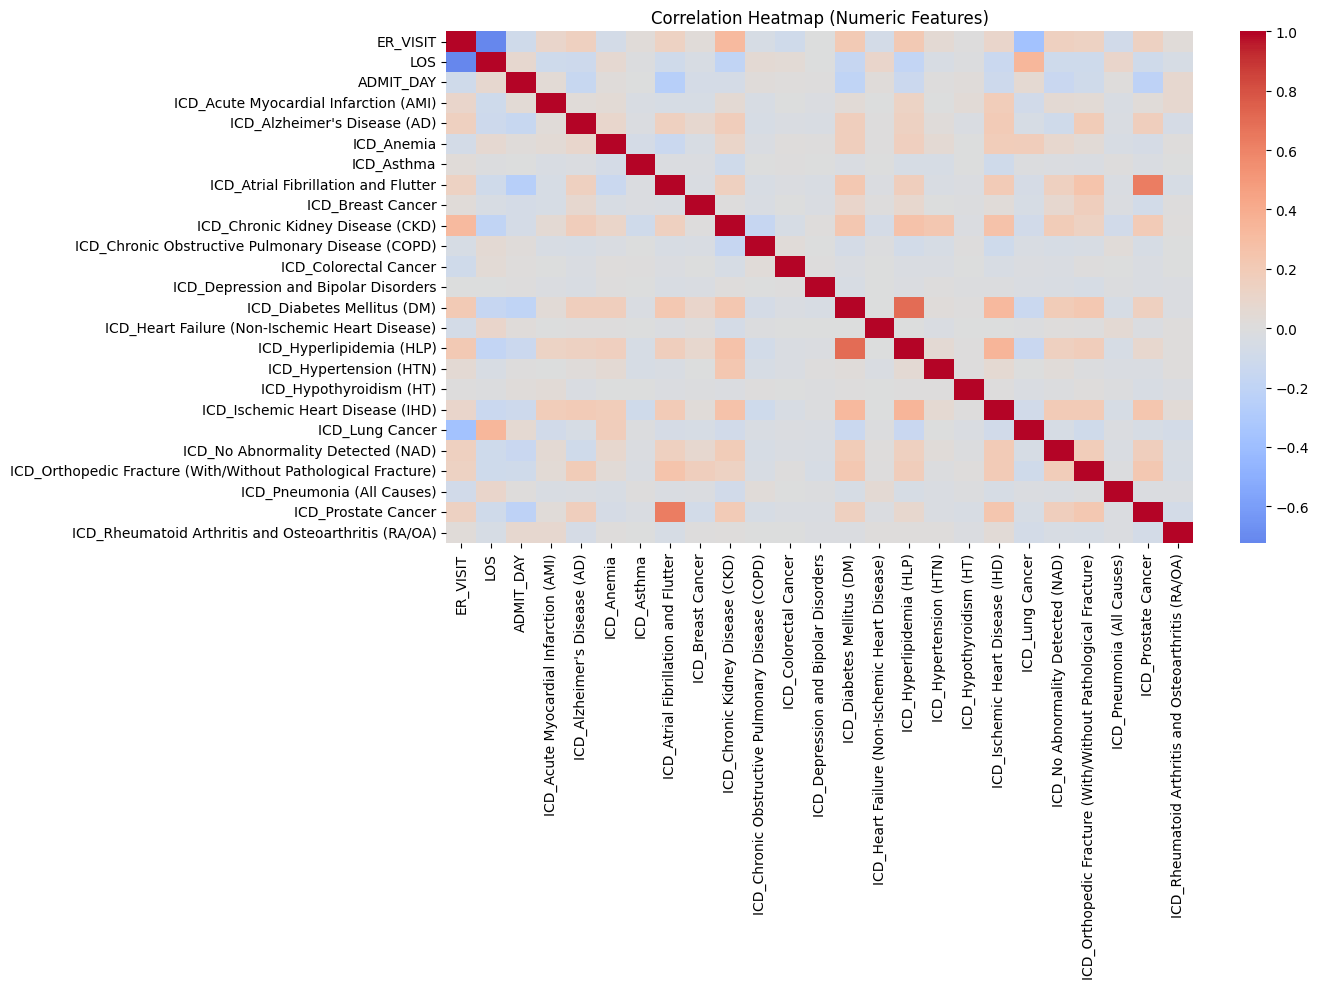

In [550]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: Select only numeric columns for correlation
numeric_df = merged_df_encoded.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()


<Axes: >

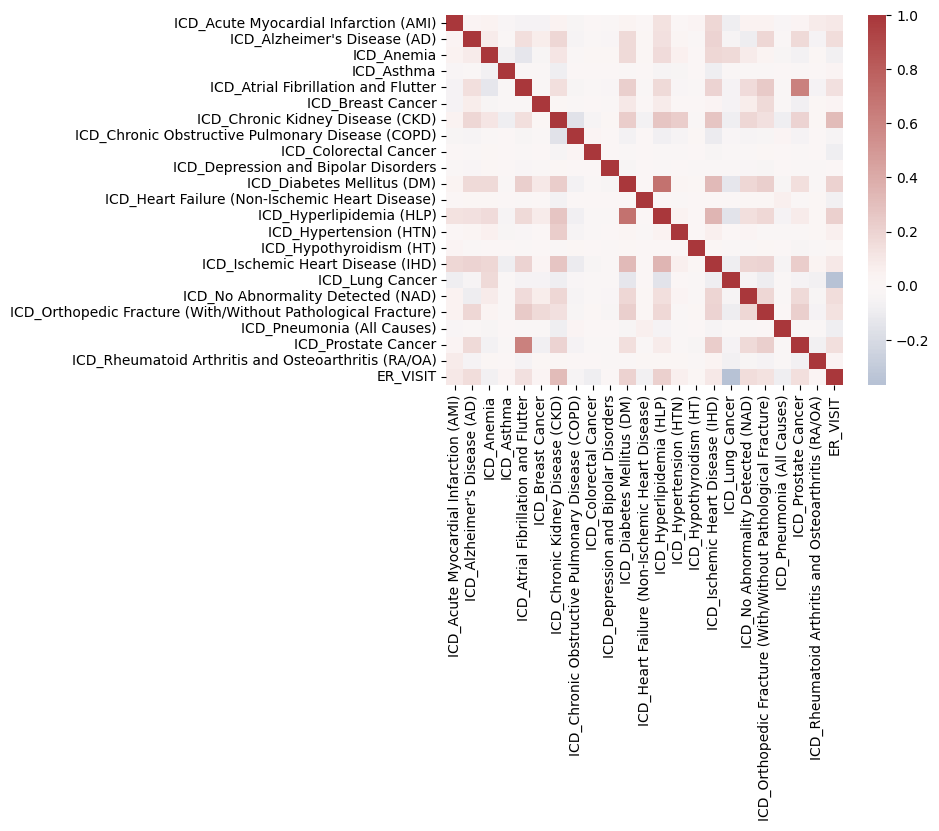

In [283]:
icd_cols = [col for col in merged_df_encoded.columns if col.startswith("ICD_")]
heatmap_df = merged_df_encoded[icd_cols + ['ER_VISIT']]
sns.heatmap(heatmap_df.corr(), cmap='vlag', center=0)


In [284]:
# filter data to show only for ER visit patients
merged_df_encoded_er_only= merged_df_encoded[merged_df_encoded.ER_VISIT == 1]
merged_df_encoded_er_only['ER_VISIT'].value_counts()
merged_df_encoded_er_only.head()
merged_df_encoded_er_only.shape

(35441, 38)

C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\3261071814.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')


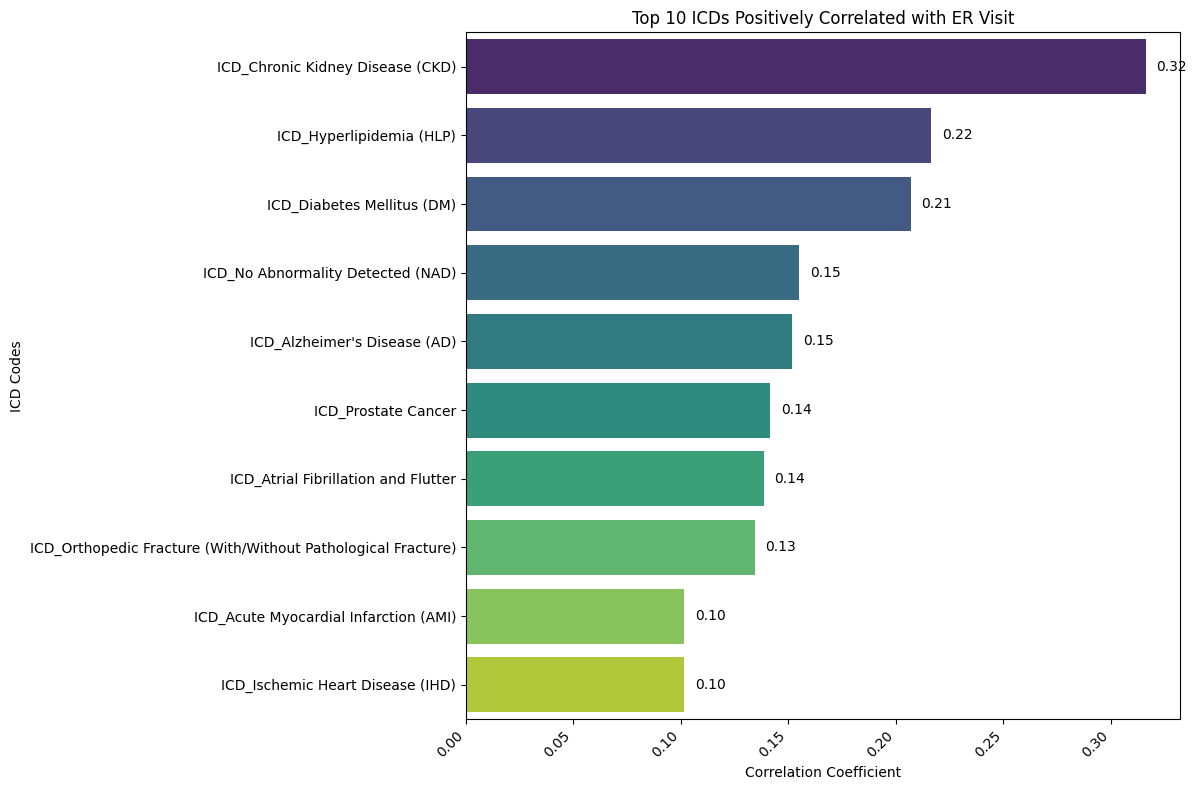

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select ICD columns
icd_cols = [col for col in merged_df_encoded.columns if col.startswith('ICD_')]

# Compute correlation with ER_VISIT
correlations = merged_df_encoded[icd_cols + ['ER_VISIT']].corr()['ER_VISIT'].drop('ER_VISIT')
correlations = correlations.sort_values(ascending=False)

# Plot top 10 positively correlated ICD codes
top_n = 10
top_corr = correlations.head(top_n)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')

# Add correlation values to bars
for i, val in enumerate(top_corr.values):
    ax.text(val + 0.005, i, f"{val:.2f}", va='center')

plt.title("Top 10 ICDs Positively Correlated with ER Visit")
plt.xlabel("Correlation Coefficient")
plt.ylabel("ICD Codes", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


# Interpret the result from above analysis

Chronic Kidney Disease (ICD_ckd) – Highest correlation (0.316), indicating patients with CKD are significantly more likely to use the ER.

Hyperlipidemia (ICD_hlp) – Correlation of 0.216 suggests moderately increased ER risk.

Diabetes Mellitus (ICD_dm) – A correlation of 0.207 shows that diabetes is a strong contributor to ER visits.

Neurocognitive and Anxiety Disorders (ICD_nad) – Mental health conditions have a moderate correlation (0.155).

Alzheimer’s Disease (ICD_ad) – With a correlation of 0.152, ER use is higher among patients with Alzheimer’s.

Prostate Cancer (ICD_prostate_ca) – Cancer diagnoses are also related to more ER utilization (0.142).

Atrial Fibrillation / Flutter (ICD_afib_flutter) – Strong cardiovascular conditions increase ER risk (0.139).

Osteoporotic Fractures (ICD_or_with_without_pathological_fx) – Bone fractures have a notable correlation (0.134).

Acute Myocardial Infarction (ICD_ami) – ER use is naturally high here due to the acute nature (0.102).

Ischemic Heart Disease (ICD_ihd) – Chronic heart disease still drives increased ER visits (0.101)

# which insurance eligibility groups are most represented in ER usage?
Which entitlement reason codes (e.g., disability, age, ESRD) are most commonly associated with ER visits.

How many ER visits occurred for each entitlement type.

Comparative frequency of ER use by insurance eligibility reason.


C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\2322573141.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=entlmt_counts.index, y=entlmt_counts.values, palette='Set2')


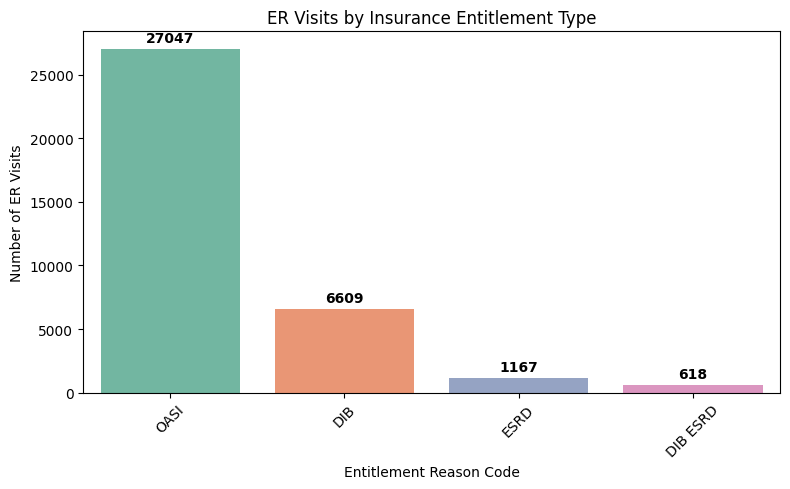

In [286]:
# Filter only ER visits
er_only = merged_df_encoded[merged_df_encoded['ER_VISIT'] == 1]

# Count ER visits per entitlement reason code
entlmt_counts = er_only['ENTLMT_RSN_CURR'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=entlmt_counts.index, y=entlmt_counts.values, palette='Set2')

plt.title("ER Visits by Insurance Entitlement Type")
plt.xlabel("Entitlement Reason Code")
plt.ylabel("Number of ER Visits")
plt.xticks(rotation=45)

# Add count labels on bars
for i, v in enumerate(entlmt_counts.values):
    ax.text(i, v + max(entlmt_counts.values)*0.01, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# ER visits by age group and gender

C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\2022265836.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  demographics = er_only.groupby(['AGE_GROUP', 'SEX_IDENT_CD'])['ER_VISIT'].count().unstack()


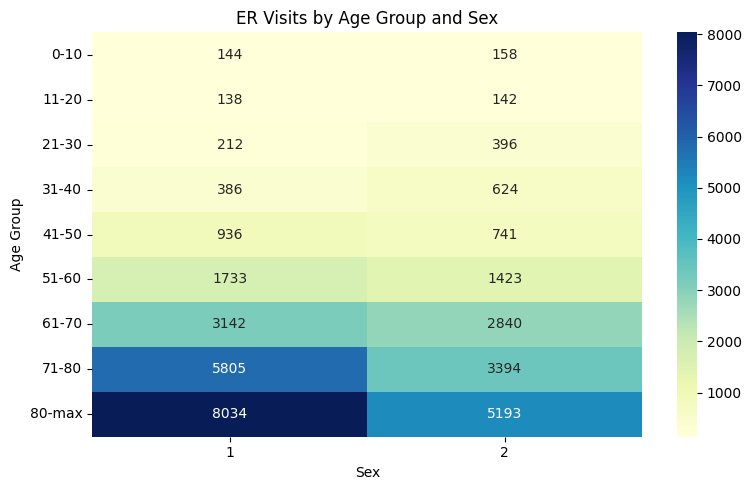

In [549]:
# Filter ER visits
er_only = merged_df_encoded[merged_df_encoded['ER_VISIT'] == 1]

# Group by AGE_GROUP and SEX
demographics = er_only.groupby(['AGE_GROUP', 'SEX_IDENT_CD'])['ER_VISIT'].count().unstack()

# Plot heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.heatmap(demographics, annot=True, fmt='d', cmap='YlGnBu')
plt.title("ER Visits by Age Group and Sex")
plt.xlabel("Sex")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()



In [288]:
entlmt_counts

ENTLMT_RSN_CURR
OASI        27047
DIB          6609
ESRD         1167
DIB ESRD      618
Name: count, dtype: int64

In [289]:
merged_df_encoded['ER_VISIT'].value_counts()

ER_VISIT
1    35441
0    12307
Name: count, dtype: int64

C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\4196614058.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_icd_counts.values, y=top_icd_counts.index, palette='Set2')


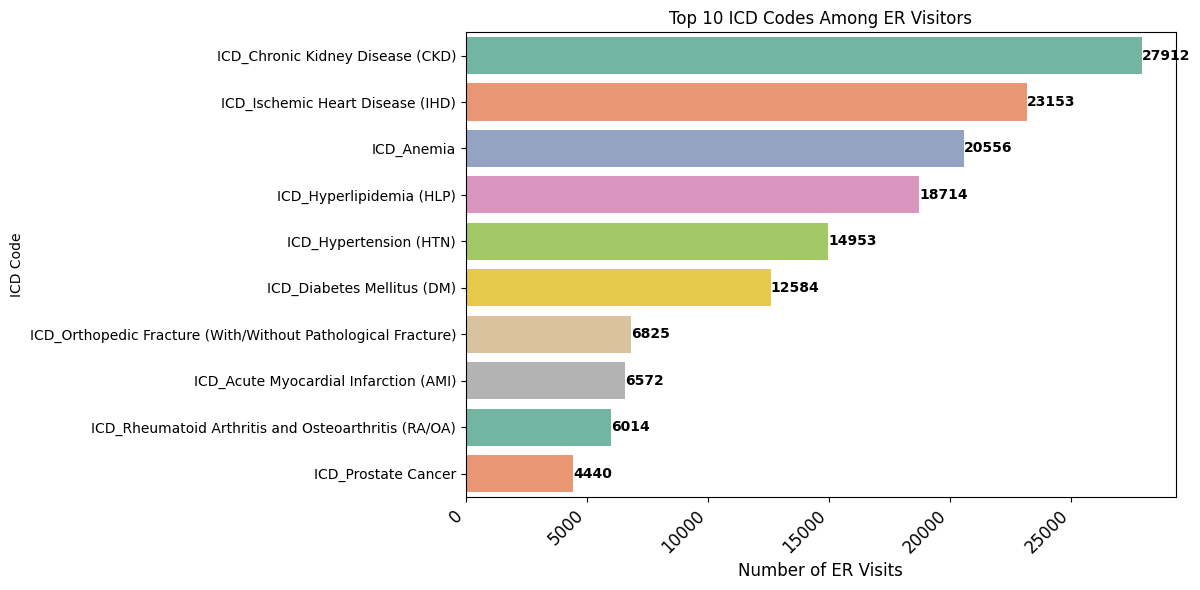

In [291]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get ICD columns
icd_cols = [col for col in merged_df_encoded.columns if col.startswith("ICD_")]

# Filter only ER visits
er_only = merged_df_encoded[merged_df_encoded['ER_VISIT'] == 1]

# Count ER visits per ICD code
icd_counts = er_only[icd_cols].sum().sort_values(ascending=False)

# Take top 10 most common ICDs among ER visitors
top_icd_counts = icd_counts.head(10)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_icd_counts.values, y=top_icd_counts.index, palette='Set2')
plt.title("Top 10 ICD Codes Among ER Visitors")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel("Number of ER Visits", fontsize=12)
plt.ylabel("ICD Code", fontsize=10)

# Add value labels on bars
for i, v in enumerate(top_icd_counts.values):
    ax.text(v + 1, i, str(int(v)), va='center', fontweight='bold', fontsize=10, color='black', ha='left')

plt.tight_layout()
plt.show()



In [695]:
merged_df_encoded.to_csv('merged_df_encoded', index=False)

In [ ]:
# Adding extra categorical variable Age group,ENTLMT_RSN_CURR and Sex in the model 


In [675]:
df_encoded_all = pd.get_dummies(merged_df_encoded, columns=['AGE_GROUP', 'SEX_IDENT_CD','ENTLMT_RSN_CURR'], drop_first=True)
df_encoded_all.head()

BENE_ID          CLM_ID CLM_ADMSN_DT NCH_BENE_DSCHRG_DT  \
0  10000010254618  10000930037831   2015-03-25         2015-03-25   
1  10000010254653  10000930038030   2015-09-24         2015-09-24   
2  10000010254653  10000930038031   2017-05-09         2017-05-10   
3  10000010254656  10000930038162   2017-01-14         2017-01-14   
4  10000010254656  10000930038162   2017-01-14         2017-01-14   

  BENE_RACE_CD STATE_CNTY_FIPS_CD_01 STATE_CNTY_FIPS_CD_02  ER_VISIT  LOS  \
0        White                  1101                  1101         1    0   
1        White                  1081                  1081         1    0   
2        White                  1081                  1081         0    1   
3        White                  1073                  1073         1    0   
4        White                  1073                  1073         1    0   

   ICD_Acute Myocardial Infarction (AMI)  ...  AGE_GROUP_31-40  \
0                                      0  ...            False   
1                                      0  ...             True   
2                                      0  ...             True   
3                                      0  ...            False   
4                                      0  ...            False   

   AGE_GROUP_41-50  AGE_GROUP_51-60  AGE_GROUP_61-70  AGE_GROUP_71-80  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   AGE_GROUP_80-max  SEX_IDENT_CD_2  ENTLMT_RSN_CURR_DIB  \
0             False           False                 True   
1             False            True                 True   
2             False            True                 True   
3             False            True                 True   
4             False            True                 True   

   ENTLMT_RSN_CURR_ESRD  ENTLMT_RSN_CURR_DIB ESRD  
0                 False                     False  
1                 False                     False  
2                 False                     False  
3                 False                     False  
4                 False                     False  

[5 rows x 43 columns]

In [676]:
# Convert booolean to int
bool_cols = df_encoded_all.select_dtypes(include='bool').columns
df_encoded_all[bool_cols] = df_encoded_all[bool_cols].astype(int)

In [ ]:
df_encoded_all.head()
df_encoded_all.columns.tolist()
df_encoded_all.shape
df_encoded_all.dtypes

In [680]:
df_encoded_all.to_csv('df_encoded_all.csv', index=False)

In [681]:
# ICD columns
icd_cols = [col for col in df_encoded_all.columns if col.startswith("ICD_")]

# New categorical columns (all AGE_GROUP_* and SEX_IDENT_CD_*)
extra_cols = [col for col in df_encoded_all.columns if col.startswith("AGE_GROUP_") or col.startswith("SEX_IDENT_CD_") or col.startswith("ENTLMT_RSN_CURR_")]

# Combine them
feature_cols = icd_cols + extra_cols


In [686]:
# Or 
# Only AGE_GROUP columns
age_group_cols = [col for col in df_encoded_all.columns if col.startswith("AGE_GROUP_")]
# Only SEX_IDENT_CD columns
SEX_IDENT_CD_cols = [col for col in df_encoded_all.columns if col.startswith("SEX_IDENT_CD_")]
# Only ENTLMT_RSN_CURR_ columns
ENTLMT_RSN_CURR__cols = [col for col in df_encoded_all.columns if col.startswith("ENTLMT_RSN_CURR_")]


# Combine them
feature_cols_age_group = icd_cols + age_group_cols
feature_cols_SEX = icd_cols + SEX_IDENT_CD_cols
feature_cols_ENTLMT_RSN = icd_cols + ENTLMT_RSN_CURR__cols

In [ ]:
age_group_cols

In [ ]:
# Till here Not using

In [ ]:
# Start here again 
# Seasonality / Trends
#Analyze how ER visits vary across time — by year, month, Week and season.

In [ ]:
# Length of Stay(LOS)

In [689]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator  # Add this import

def plot_er_vs_los(df, condition_col, year=2020):
    filtered_df = df[
        (df['ADMIT_MONTH'].dt.year == year) &
        (df['ER_VISIT'] == 1) &
        (df[condition_col] == 1)
    ].copy()

    monthly_stats = filtered_df.groupby('ADMIT_MONTH').agg(
        avg_los=('LOS', 'mean'),
        er_visits=('ER_VISIT', 'count')
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot average LOS
    sns.lineplot(data=monthly_stats, x='ADMIT_MONTH', y='avg_los',
                 ax=ax1, marker='o', color='blue', label='Avg LOS')
    ax1.set_ylabel('Average LOS', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Plot ER visits on secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(data=monthly_stats, x='ADMIT_MONTH', y='er_visits',
                 ax=ax2, marker='s', color='orange', label='ER Visits')
    ax2.set_ylabel('ER Visit Count', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # Force integer ticks

    # Format X-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)

    # Title
    condition_label = condition_col.replace('ICD_', '').replace('(', '').replace(')', '')
    plt.title(f'Monthly ER Visits and LOS for {condition_label} ({year})')

    fig.tight_layout()
    plt.show()


In [ ]:
plot_er_vs_los(filtered_df, 'ICD_Chronic Kidney Disease (CKD)', year=2020)


In [ ]:
#ER Visits vs. Average LOS
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_er_vs_los(df, condition_col, year=2020):
    filtered_df = df[
        (df['ADMIT_MONTH'].dt.year == year) &
        (df['ER_VISIT'] == 1) &
        (df[condition_col] == 1)
    ].copy()

    monthly_stats = filtered_df.groupby('ADMIT_MONTH').agg(
        avg_los=('LOS', 'mean'),
        er_visits=('ER_VISIT', 'count')
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # LOS
    sns.lineplot(data=monthly_stats, x='ADMIT_MONTH', y='avg_los',
                 ax=ax1, marker='o', color='blue', label='Avg LOS')
    ax1.set_ylabel('Average LOS', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # ER visits on secondary axis
    ax2 = ax1.twinx()
    sns.lineplot(data=monthly_stats, x='ADMIT_MONTH', y='er_visits',
                 ax=ax2, marker='s', color='orange', label='ER Visits')
    ax2.set_ylabel('ER Visit Count', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    condition_label = condition_col.replace('ICD_', '').replace('(', '').replace(')', '')
    plt.title(f'Monthly ER Visits and LOS for {condition_label} ({year})')
    fig.tight_layout()
    plt.show()
plot_er_vs_los(merged_df_encoded, 'ICD_Chronic Kidney Disease (CKD)', year=2020)

In [ ]:
plot_er_vs_los(merged_df_encoded, 'ICD_Chronic Kidney Disease (CKD)', year=2020)
#plot_er_vs_total_admissions(merged_df_encoded, 'ICD_Chronic Kidney Disease (CKD)', year=2020)


In [496]:
#ER Visits vs. Total Admissions
def plot_er_vs_total_admissions(df, condition_col, year=2020):
    filtered_df_er = df[
        (df['ADMIT_MONTH'].dt.year == year) &
        (df['ER_VISIT'] == 1) &
        (df[condition_col] == 1)
    ].copy()

    filtered_df_total = df[
        (df['ADMIT_MONTH'].dt.year == year) &
        (df[condition_col] == 1)
    ].copy()

    monthly_stats_er = filtered_df_er.groupby('ADMIT_MONTH').agg(
        er_visits=('ER_VISIT', 'count')
    ).reset_index()

    monthly_stats_total = filtered_df_total.groupby('ADMIT_MONTH').agg(
        total_admissions=('ER_VISIT', 'count')
    ).reset_index()

    monthly_stats = pd.merge(monthly_stats_er, monthly_stats_total, on='ADMIT_MONTH', how='left')

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # ER visits
    sns.lineplot(data=monthly_stats, x='ADMIT_MONTH', y='er_visits',
                 ax=ax1, marker='s', color='orange', label='ER Visits')
    ax1.set_ylabel('ER Visit Count', color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')

    # Total admissions on secondary axis
    ax2 = ax1.twinx()
    sns.lineplot(data=monthly_stats, x='ADMIT_MONTH', y='total_admissions',
                 ax=ax2, marker='^', color='green', label='Total Admissions')
    ax2.set_ylabel('Total Admissions', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    condition_label = condition_col.replace('ICD_', '').replace('(', '').replace(')', '')
    plt.title(f'Monthly ER Visits and Total Admissions for {condition_label} ({year})')
    fig.tight_layout()
    plt.show()


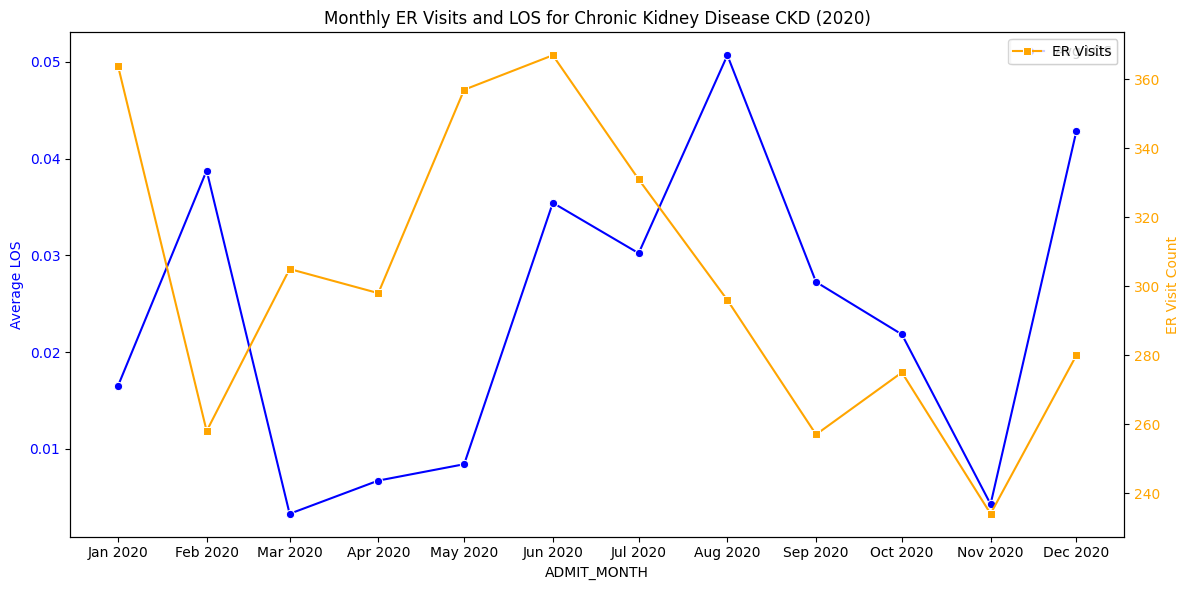

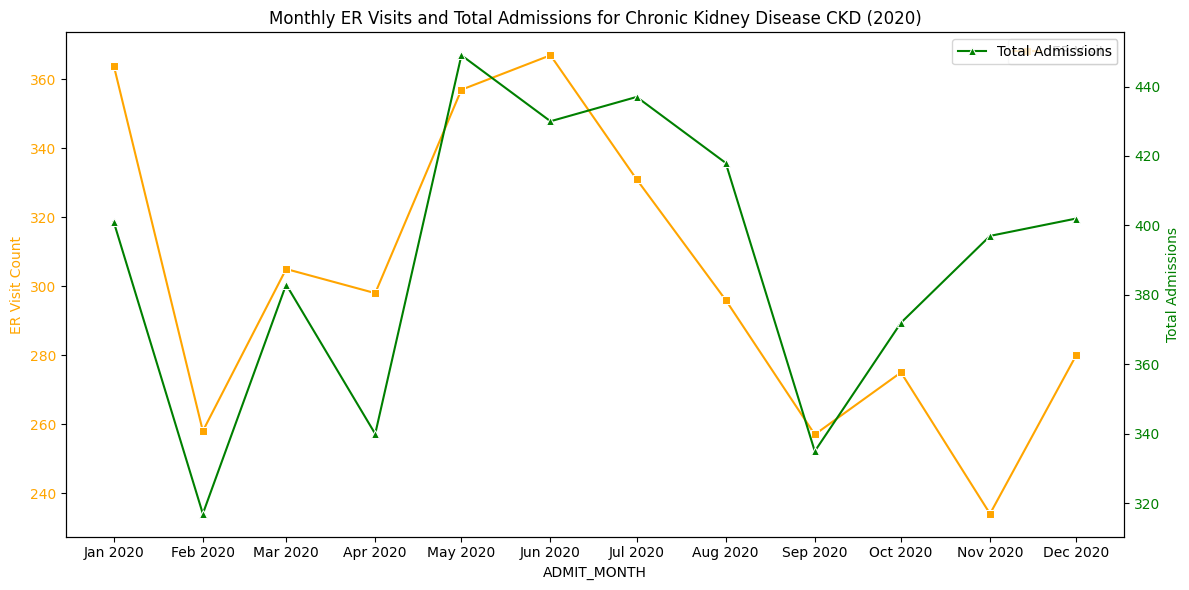

In [492]:
plot_er_vs_los(merged_df_encoded, 'ICD_Chronic Kidney Disease (CKD)', year=2020)
plot_er_vs_total_admissions(merged_df_encoded, 'ICD_Chronic Kidney Disease (CKD)', year=2020)


In [483]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_monthly_er_stats_by_condition(df, condition_col, year=2020):
    """
    Plots average LOS and ER visit count per month for a specific ICD condition and year.
    
    Parameters:
        df (DataFrame): Encoded claims DataFrame.
        condition_col (str): Name of ICD condition column (e.g. 'ICD_Diabetes Mellitus (DM)').
        year (int): Year to filter (default = 2020).
    """
    # Filter ER visits for specified year and condition
    filtered_df = df[
        (df['ADMIT_MONTH'].dt.year == year) &
        (df['ER_VISIT'] == 1) &
        (df[condition_col] == 1)
    ].copy()

    # Monthly aggregation
    monthly_stats = filtered_df.groupby('ADMIT_MONTH').agg(
        avg_los=('LOS', 'mean'),
        er_visits=('ER_VISIT', 'count')
    ).reset_index()

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Avg LOS
    sns.lineplot(data=monthly_stats, x='ADMIT_MONTH', y='avg_los',
                 ax=ax1, marker='o', color='blue', label='Avg LOS')
    ax1.set_ylabel('Average LOS', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # X-axis formatting
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)

    # ER Visit Count on secondary axis
    ax2 = ax1.twinx()
    sns.lineplot(data=monthly_stats, x='ADMIT_MONTH', y='er_visits',
                 ax=ax2, marker='s', color='orange', label='ER Visits')
    ax2.set_ylabel('ER Visit Count', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Title
    condition_label = condition_col.replace('ICD_', '').replace('(', '').replace(')', '')
    plt.title(f'Monthly ER Visits and LOS for {condition_label} Patients ({year})')

    fig.tight_layout()
    plt.show()


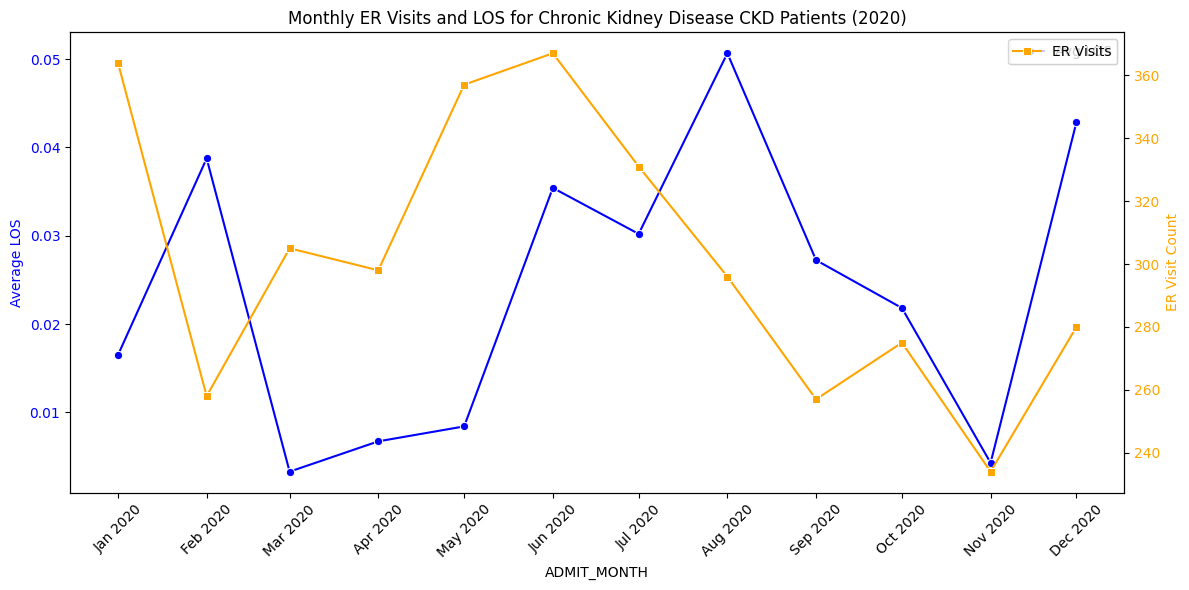

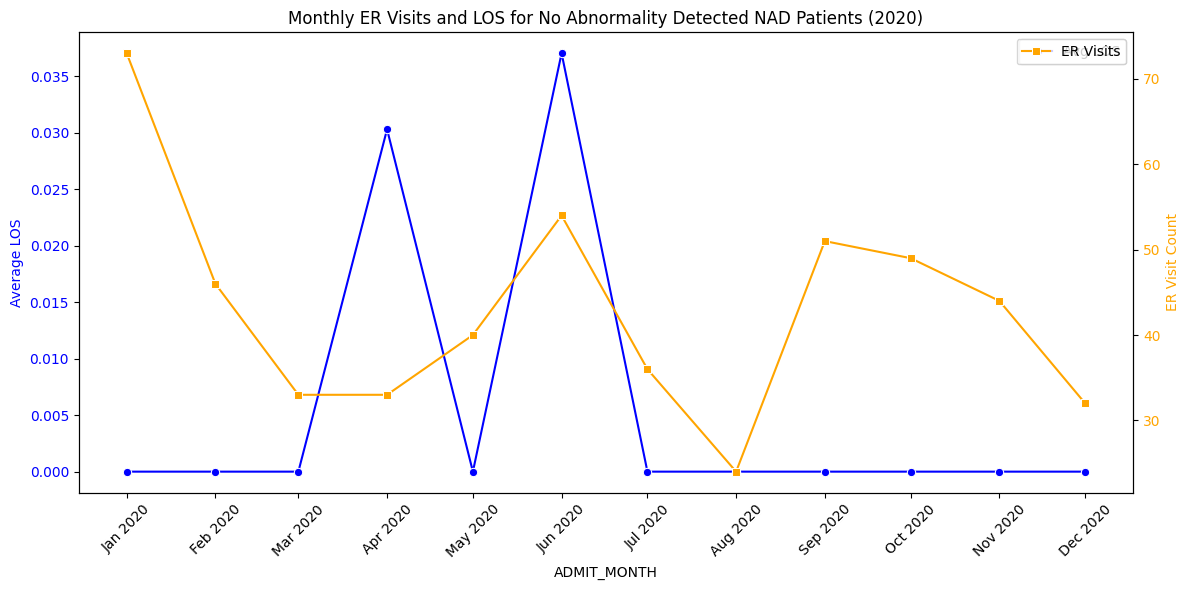

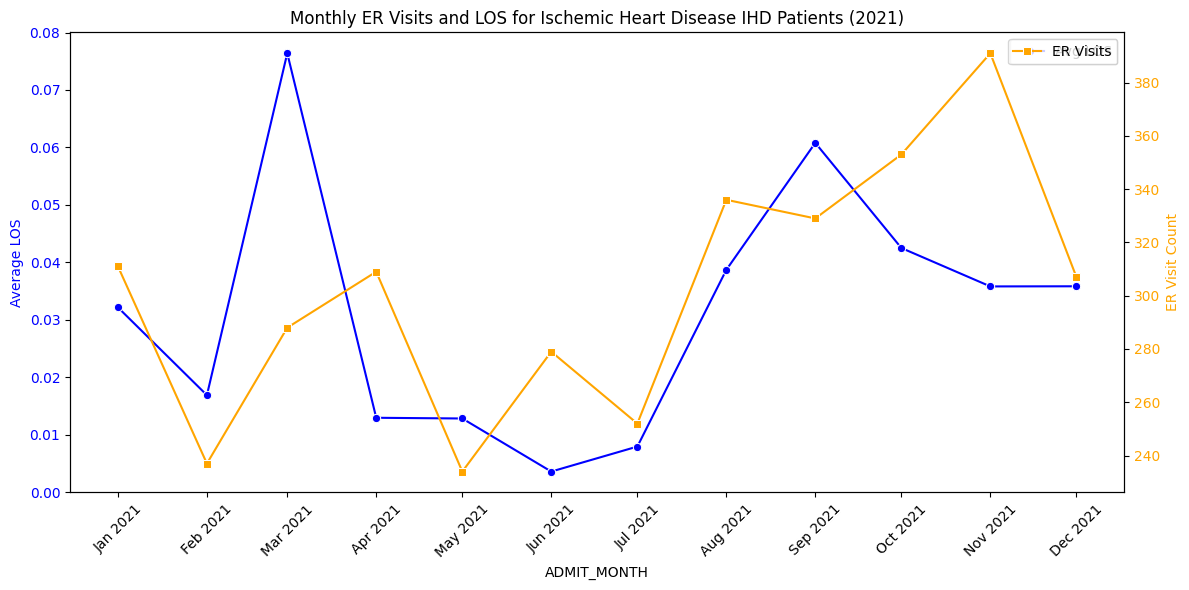

In [486]:
plot_monthly_er_stats_by_condition(merged_df_encoded, 'ICD_Chronic Kidney Disease (CKD)')
plot_monthly_er_stats_by_condition(merged_df_encoded, 'ICD_No Abnormality Detected (NAD)')
plot_monthly_er_stats_by_condition(merged_df_encoded, 'ICD_Ischemic Heart Disease (IHD)', year=2021)


In [487]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_monthly_er_stats_by_condition_with_admissions(df, condition_col, year=2020):
    """
    Plots average LOS, ER visit count, and total admissions per month for a specific ICD condition and year.
    
    Parameters:
        df (DataFrame): Encoded claims DataFrame.
        condition_col (str): Name of ICD condition column (e.g. 'ICD_Diabetes Mellitus (DM)').
        year (int): Year to filter (default = 2020).
    """
    # Filter for ER visits and the specific condition
    filtered_df_er = df[
        (df['ADMIT_MONTH'].dt.year == year) &
        (df['ER_VISIT'] == 1) &
        (df[condition_col] == 1)
    ].copy()

    # Filter for total admissions for the condition (irrespective of ER visits)
    filtered_df_total = df[
        (df['ADMIT_MONTH'].dt.year == year) &
        (df[condition_col] == 1)
    ].copy()

    # Monthly aggregation for ER visits
    monthly_stats_er = filtered_df_er.groupby('ADMIT_MONTH').agg(
        avg_los=('LOS', 'mean'),
        er_visits=('ER_VISIT', 'count')
    ).reset_index()

    # Monthly aggregation for total admissions (for the condition)
    monthly_stats_total = filtered_df_total.groupby('ADMIT_MONTH').agg(
        total_admissions=('ER_VISIT', 'count')
    ).reset_index()

    # Merge both ER stats and total admissions stats
    monthly_stats = pd.merge(monthly_stats_er, monthly_stats_total, on='ADMIT_MONTH', how='left')

    # Plotting
    fig, ax1 = plt.subplots(figsize=(12, 6))

  
    # X-axis formatting
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)

    # ER Visit Count (Line 2)
    ax2 = ax1.twinx()
    sns.lineplot(data=monthly_stats, x='ADMIT_MONTH', y='er_visits', ax=ax2, marker='s', color='orange', label='ER Visits')
    ax2.set_ylabel('ER Visit Count', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Total Admissions (Line 3, secondary Y-axis)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis to avoid overlap
    sns.lineplot(data=monthly_stats, x='ADMIT_MONTH', y='total_admissions', ax=ax3, marker='^', color='green', label='Total Admissions')
    ax3.set_ylabel('Total Admissions', color='green')
    ax3.tick_params(axis='y', labelcolor='green')

    # Title
    condition_label = condition_col.replace('ICD_', '').replace('(', '').replace(')', '')
    plt.title(f'Monthly ER Visits, LOS, and Total Admissions for {condition_label} Patients ({year})')

    fig.tight_layout()
    plt.show()


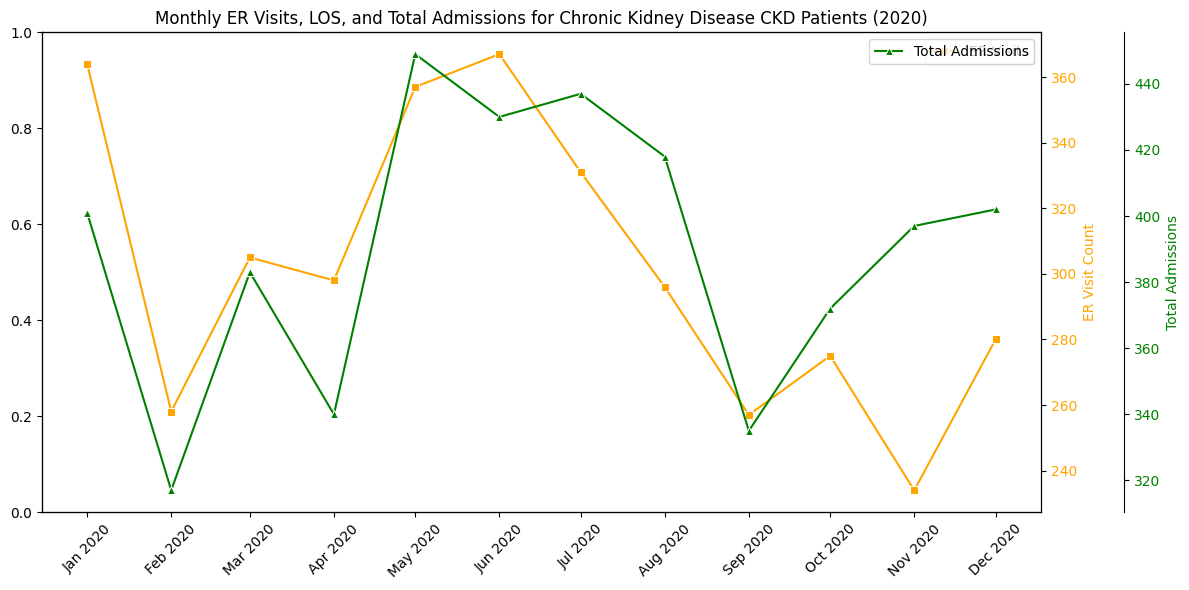

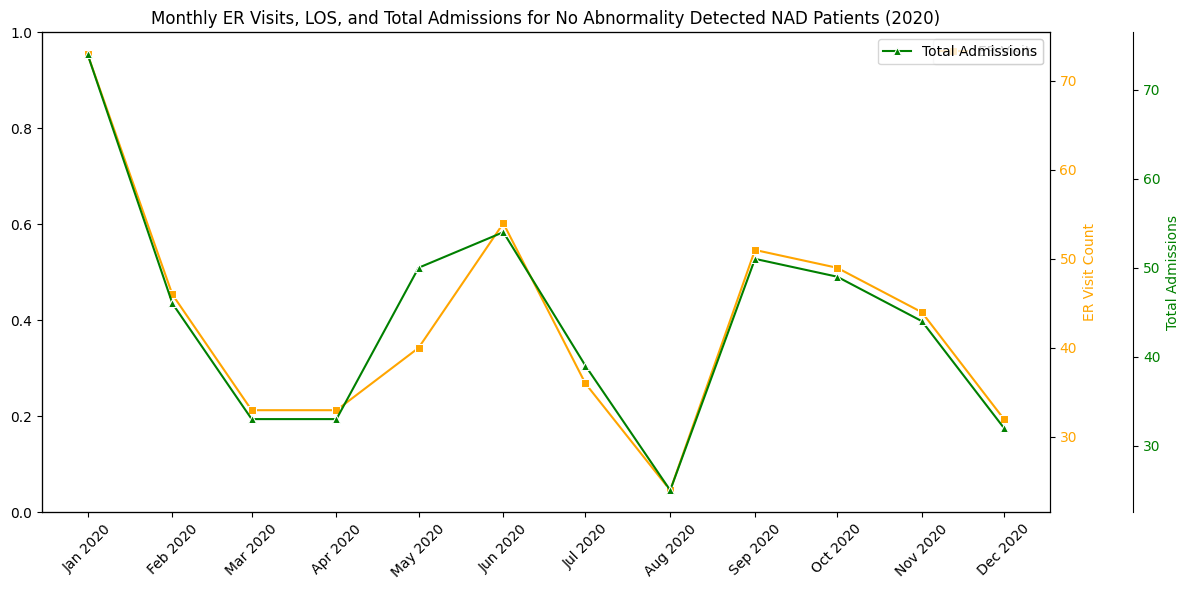

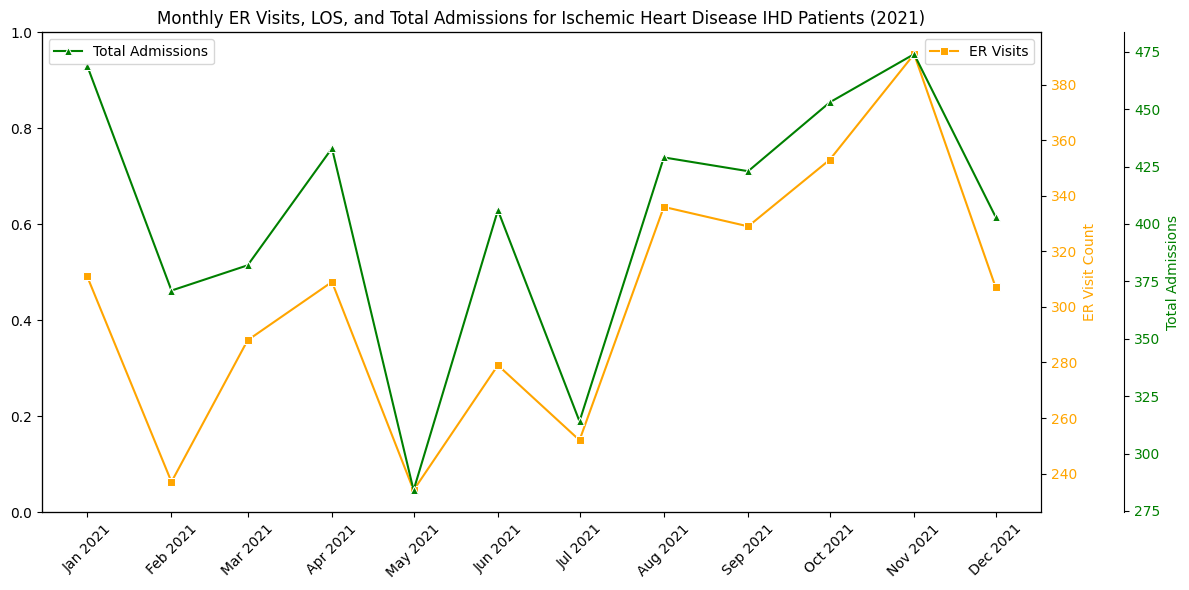

In [488]:
plot_monthly_er_stats_by_condition_with_admissions(merged_df_encoded, 'ICD_Chronic Kidney Disease (CKD)')
plot_monthly_er_stats_by_condition_with_admissions(merged_df_encoded, 'ICD_No Abnormality Detected (NAD)')
plot_monthly_er_stats_by_condition_with_admissions(merged_df_encoded, 'ICD_Ischemic Heart Disease (IHD)', year=2021)



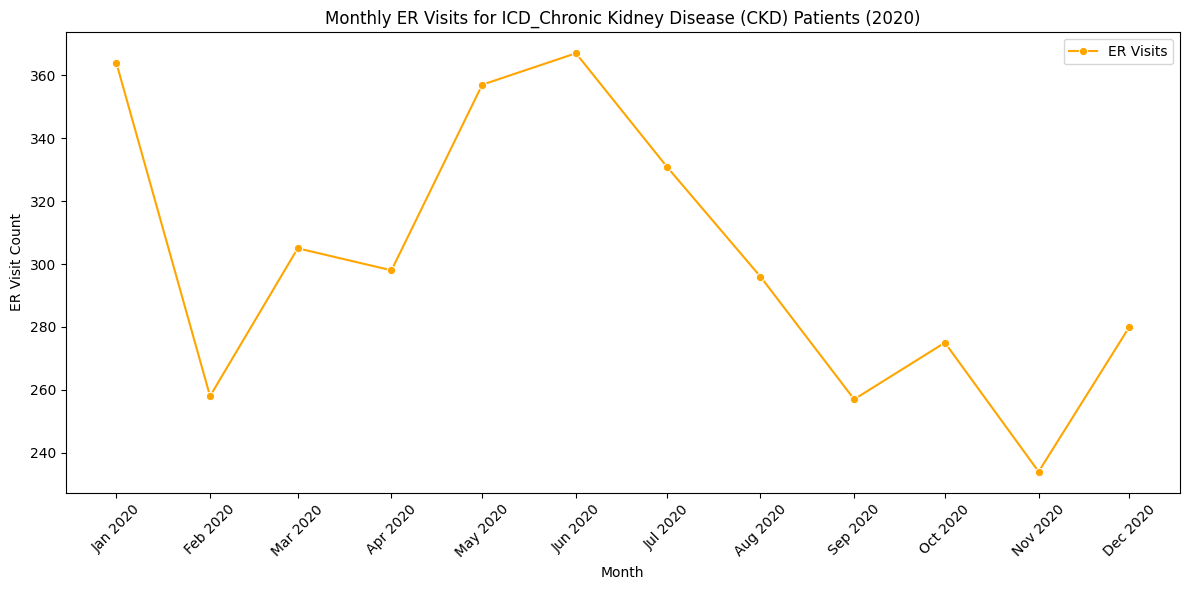

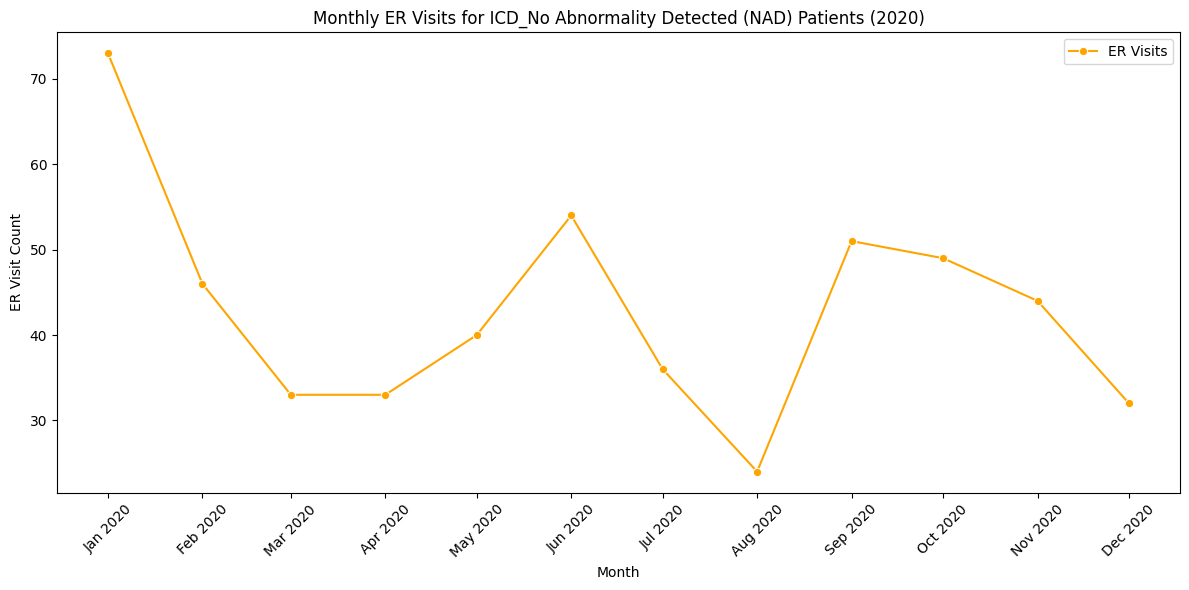

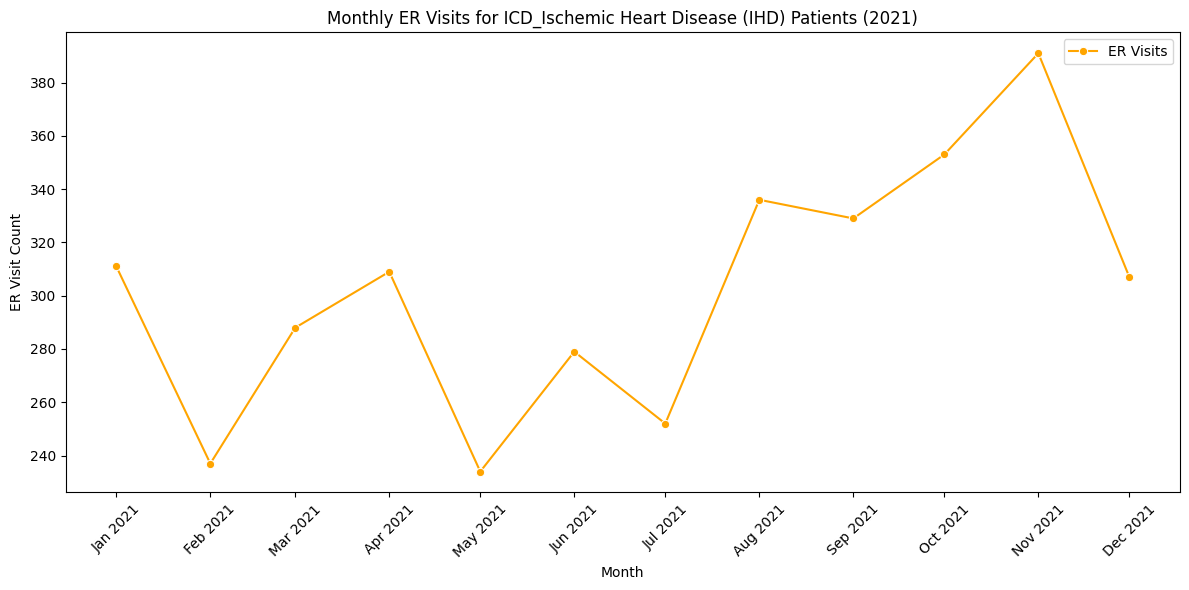

In [431]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_monthly_er_visits_by_condition(df, condition_col, year=2020):
    """
    Plots monthly ER visit count for a specific ICD condition and year.
    
    Parameters:
        df (DataFrame): Encoded claims DataFrame.
        condition_col (str): Name of ICD condition column (e.g. 'ICD_Diabetes Mellitus (DM)').
        year (int): Year to filter (default = 2020).
    """
    # Filter for ER visits and the specific condition
    filtered_df_er = df[
        (df['ADMIT_MONTH'].dt.year == year) &
        (df['ER_VISIT'] == 1) &
        (df[condition_col] == 1)
    ].copy()

    # Monthly aggregation for ER visits
    monthly_stats_er = filtered_df_er.groupby('ADMIT_MONTH').agg(
        er_visits=('ER_VISIT', 'count')
    ).reset_index()

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=monthly_stats_er, x='ADMIT_MONTH', y='er_visits', marker='o', color='orange', label='ER Visits')
    
    # Formatting the plot
    plt.title(f'Monthly ER Visits for {condition_col} Patients ({year})')
    plt.xlabel('Month')
    plt.ylabel('ER Visit Count')
    plt.xticks(rotation=45)
    
    # Format X-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    plt.tight_layout()
    plt.show()

# Example usage for different conditions
plot_monthly_er_visits_by_condition(merged_df_encoded, 'ICD_Chronic Kidney Disease (CKD)')
plot_monthly_er_visits_by_condition(merged_df_encoded, 'ICD_No Abnormality Detected (NAD)', year=2020)
plot_monthly_er_visits_by_condition(merged_df_encoded, 'ICD_Ischemic Heart Disease (IHD)', year=2021)



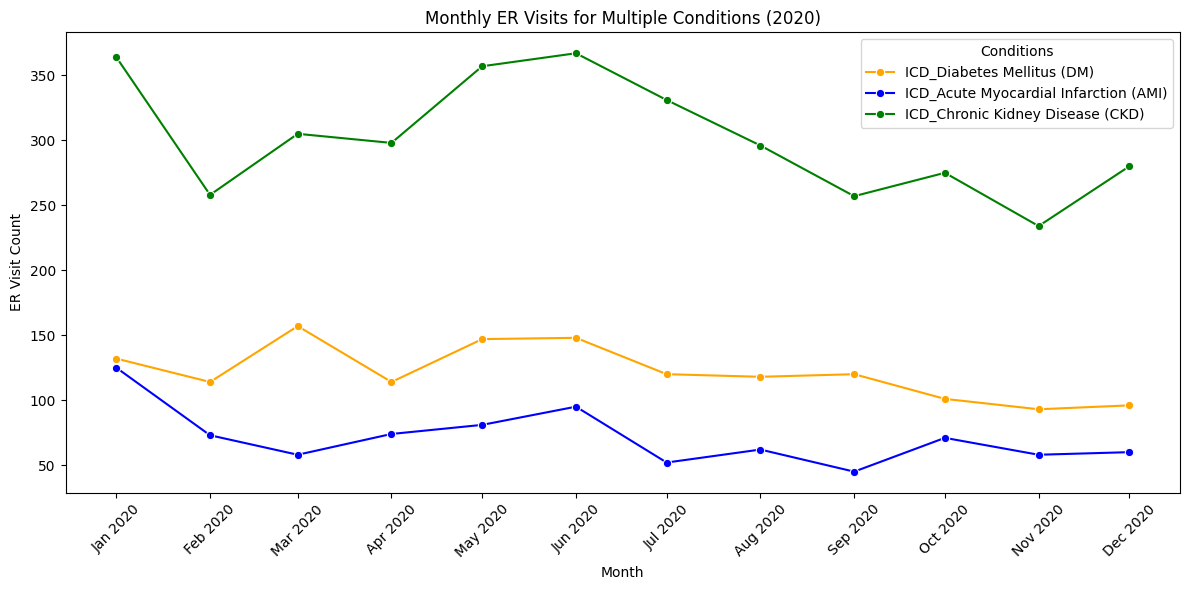

In [381]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_multiple_conditions_er_visits(df, conditions, year=2020):
    """
    Plots monthly ER visit counts for multiple ICD conditions in a single graph.
    
    Parameters:
        df (DataFrame): Encoded claims DataFrame.
        conditions (list): List of ICD condition columns (e.g. ['ICD_Diabetes Mellitus (DM)', 'ICD_COPD']).
        year (int): Year to filter (default = 2020).
    """
    plt.figure(figsize=(12, 6))
    
    # Define colors for each condition
    colors = ['orange', 'blue', 'green']
    
    # Loop through the conditions and plot each one
    for i, condition_col in enumerate(conditions):
        # Filter for ER visits and the specific condition
        filtered_df_er = df[
            (df['ADMIT_MONTH'].dt.year == year) &
            (df['ER_VISIT'] == 1) &
            (df[condition_col] == 1)
        ].copy()

        # Monthly aggregation for ER visits
        monthly_stats_er = filtered_df_er.groupby('ADMIT_MONTH').agg(
            er_visits=('ER_VISIT', 'count')
        ).reset_index()

        # Plot ER visit count
        sns.lineplot(data=monthly_stats_er, x='ADMIT_MONTH', y='er_visits', marker='o', label=condition_col, color=colors[i])

    # Formatting the plot
    plt.title(f'Monthly ER Visits for Multiple Conditions ({year})')
    plt.xlabel('Month')
    plt.ylabel('ER Visit Count')
    plt.xticks(rotation=45)
    
    # Format X-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    # Display legend
    plt.legend(title='Conditions')
    
    # Layout adjustment
    plt.tight_layout()
    plt.show()

# Example usage for multiple conditions
conditions = ['ICD_Diabetes Mellitus (DM)', 'ICD_Acute Myocardial Infarction (AMI)', 'ICD_Chronic Kidney Disease (CKD)']
plot_multiple_conditions_er_visits(merged_df_encoded, conditions, year=2020)


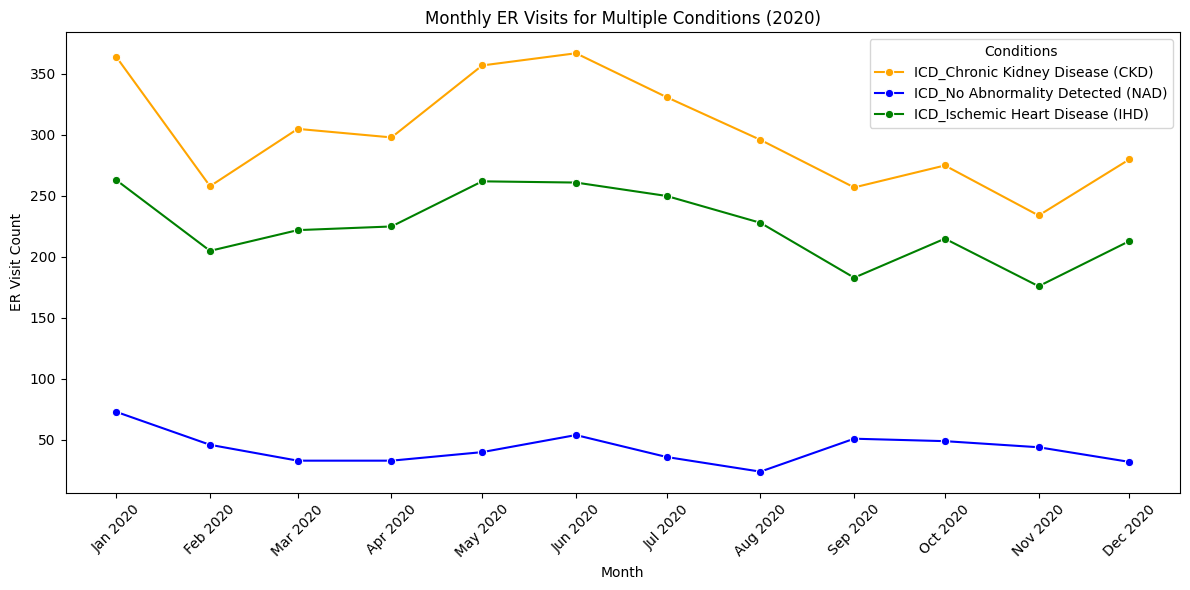

In [462]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_multiple_conditions_er_visits(df, conditions, year=2020):
    plt.figure(figsize=(12, 6))

    # Define colors for each condition (extend if more conditions are passed)
    colors = ['orange', 'blue', 'green', 'red', 'purple', 'cyan', 'brown']

    # Loop through the conditions and plot each one
    for i, condition_col in enumerate(conditions):
        # Filter for ER visits and the specific condition
        filtered_df_er = df[
            (df['ADMIT_MONTH'].dt.year == year) &
            (df['ER_VISIT'] == 1) &
            (df[condition_col] == 1)
        ].copy()

        # Monthly aggregation for ER visits
        monthly_stats_er = filtered_df_er.groupby('ADMIT_MONTH').agg(
            er_visits=('ER_VISIT', 'count')
        ).reset_index()

        # Plot ER visit count
        sns.lineplot(data=monthly_stats_er, x='ADMIT_MONTH', y='er_visits', marker='o',
                     label=condition_col, color=colors[i % len(colors)])

    # Formatting the plot
    plt.title(f'Monthly ER Visits for Multiple Conditions ({year})')
    plt.xlabel('Month')
    plt.ylabel('ER Visit Count')
    plt.xticks(rotation=45)

    # Format X-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    # Display legend
    plt.legend(title='Conditions')

    # Layout adjustment
    plt.tight_layout()
    plt.show()

# Example usage
conditions = ['ICD_Chronic Kidney Disease (CKD)', 'ICD_No Abnormality Detected (NAD)', 'ICD_Ischemic Heart Disease (IHD)']
plot_multiple_conditions_er_visits(merged_df_encoded, conditions, year=2020)



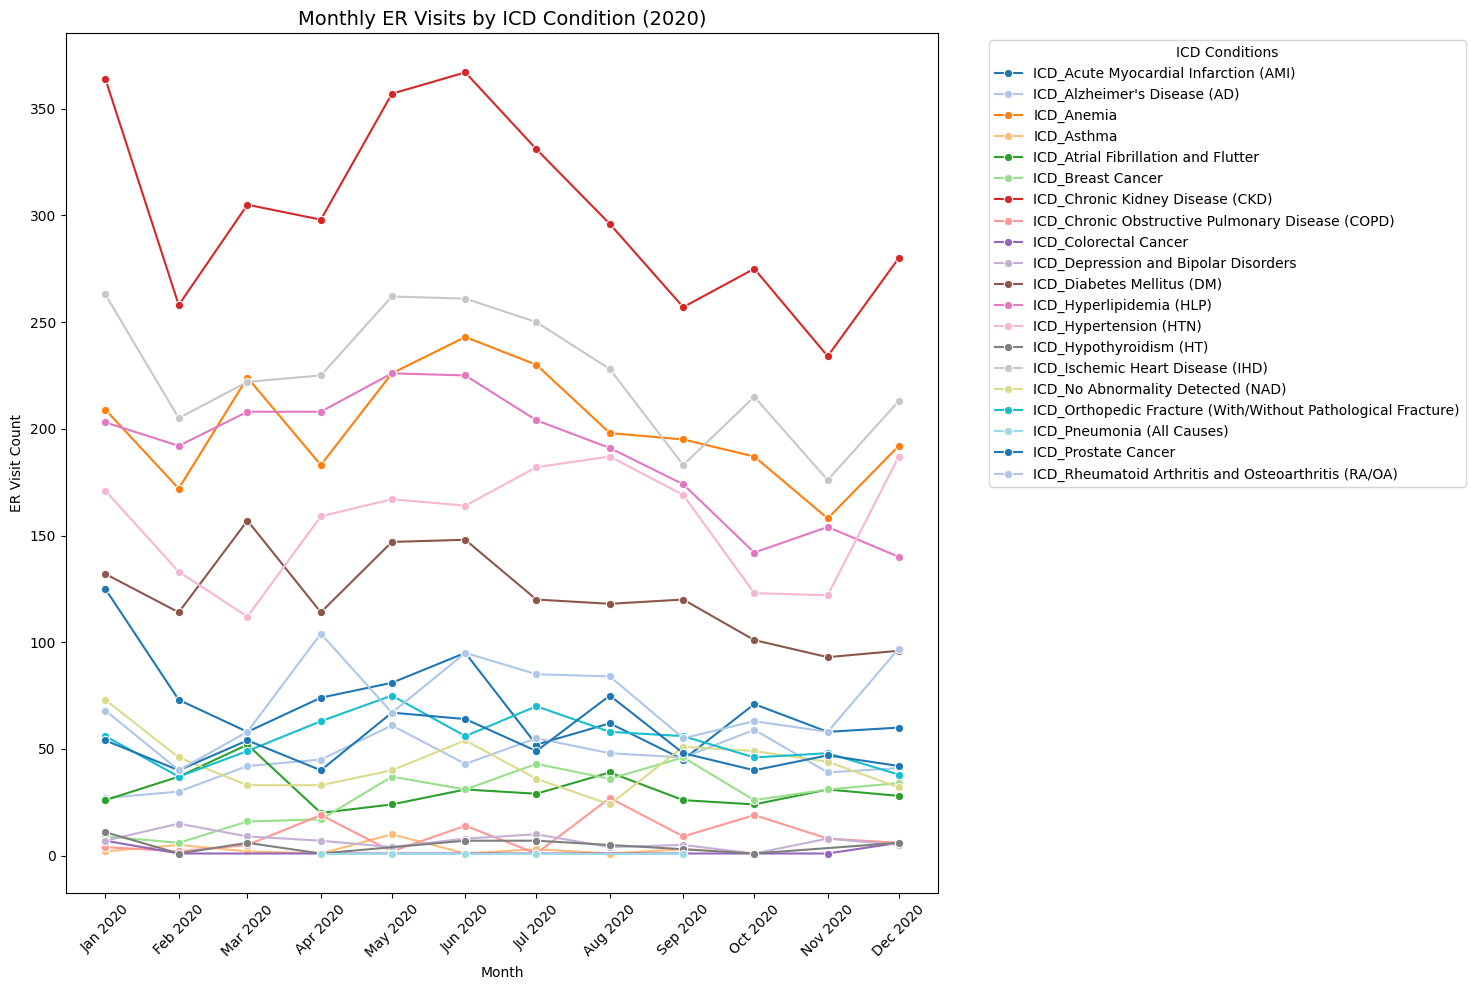

In [463]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_all_icd_conditions_er_visits(df, year=2020):
    # Get all ICD columns
    icd_cols = [col for col in df.columns if col.startswith('ICD_')]

    plt.figure(figsize=(15, 10))

    # Define color palette
    colors = sns.color_palette('tab20', len(icd_cols))

    for i, condition_col in enumerate(icd_cols):
        # Filter for ER visits in the given year where the condition is present
        filtered_df_er = df[
            (df['ADMIT_MONTH'].dt.year == year) &
            (df['ER_VISIT'] == 1) &
            (df[condition_col] == 1)
        ]

        # Monthly aggregation
        monthly_stats_er = filtered_df_er.groupby('ADMIT_MONTH').agg(
            er_visits=('ER_VISIT', 'count')
        ).reset_index()

        # Plot line if condition has any visits
        if not monthly_stats_er.empty:
            sns.lineplot(data=monthly_stats_er, x='ADMIT_MONTH', y='er_visits', 
                         label=condition_col, color=colors[i % len(colors)], marker='o')

    # Formatting
    plt.title(f'Monthly ER Visits by ICD Condition ({year})', fontsize=14)
    plt.xlabel('Month')
    plt.ylabel('ER Visit Count')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.legend(title='ICD Conditions', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_all_icd_conditions_er_visits(merged_df_encoded, year=2020)


In [ ]:
plot_monthly_er_stats_by_condition(merged_df_encoded, 'ICD_Chronic Kidney Disease (CKD)')
plot_monthly_er_stats_by_condition(merged_df_encoded, 'ICD_No Abnormality Detected (NAD)')
plot_monthly_er_stats_by_condition(merged_df_encoded, 'ICD_Ischemic Heart Disease (IHD)', year=2021)

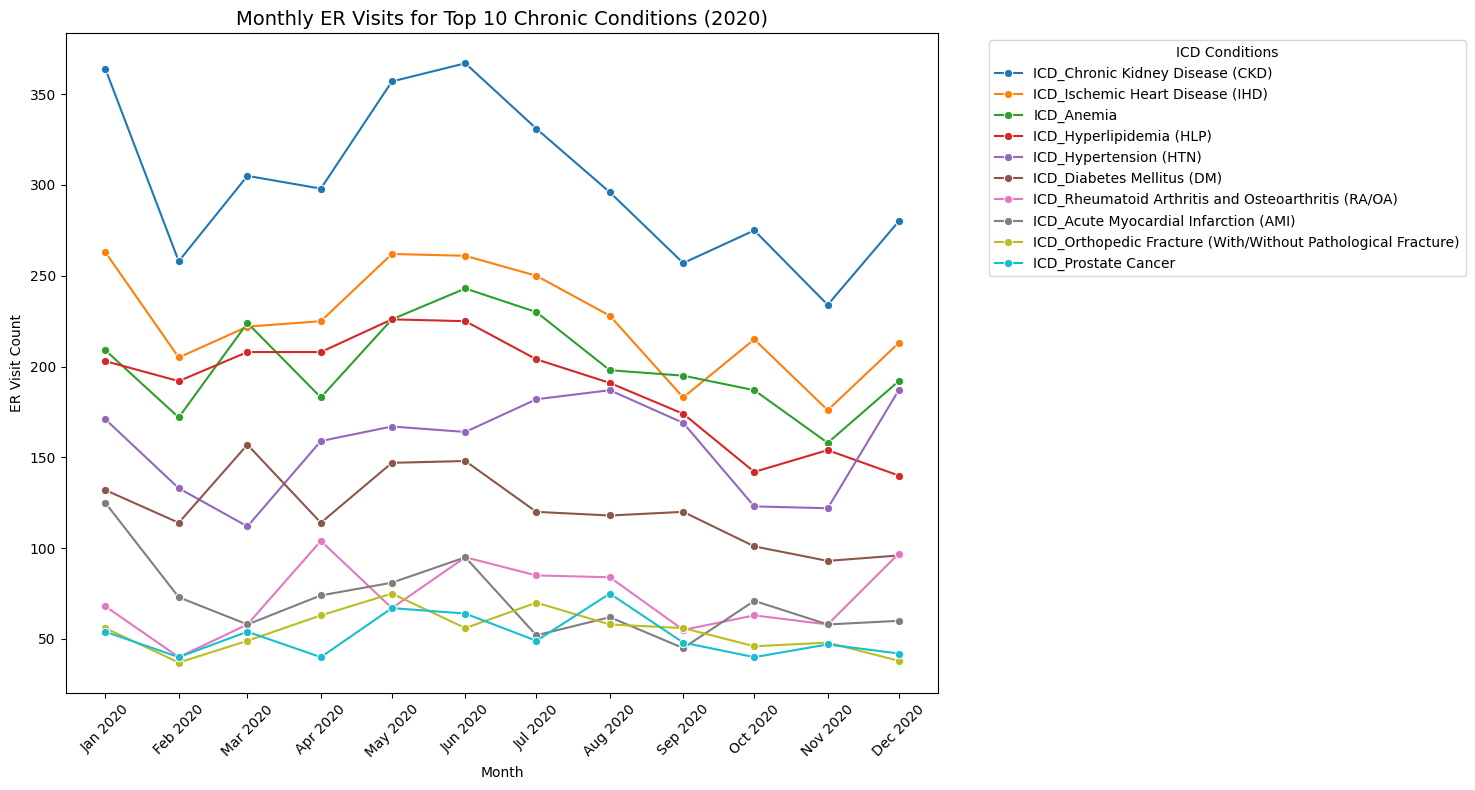

In [555]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_all_icd_conditions_er_visits(df, year=2020):
    # Get all ICD columns
    icd_cols = [col for col in df.columns if col.startswith('ICD_')]
    
    # Get top 10 ICDs by count
    top_icds = df[icd_cols].sum().sort_values(ascending=False).head(10).index.tolist()

    plt.figure(figsize=(15, 8))

    # Define color palette
    colors = sns.color_palette('tab10', len(top_icds))

    for i, condition_col in enumerate(top_icds):
        # Filter for ER visits in the given year where the condition is present
        filtered_df_er = df[
            (df['ADMIT_MONTH'].dt.year == year) &
            (df['ER_VISIT'] == 1) &
            (df[condition_col] == 1)
        ]

        # Monthly aggregation
        monthly_stats_er = filtered_df_er.groupby('ADMIT_MONTH').agg(
            er_visits=('ER_VISIT', 'count')
        ).reset_index()

        # Plot line if condition has any visits
        if not monthly_stats_er.empty:
            sns.lineplot(data=monthly_stats_er, x='ADMIT_MONTH', y='er_visits', 
                         label=condition_col, color=colors[i % len(colors)], marker='o')

    # Formatting
    plt.title(f'Monthly ER Visits for Top 10 Chronic Conditions ({year})', fontsize=14)
    plt.xlabel('Month')
    plt.ylabel('ER Visit Count')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
   # plt.legend(title='ICD Conditions', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend(title='ICD Conditions', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_all_icd_conditions_er_visits(merged_df_encoded, year=2020)


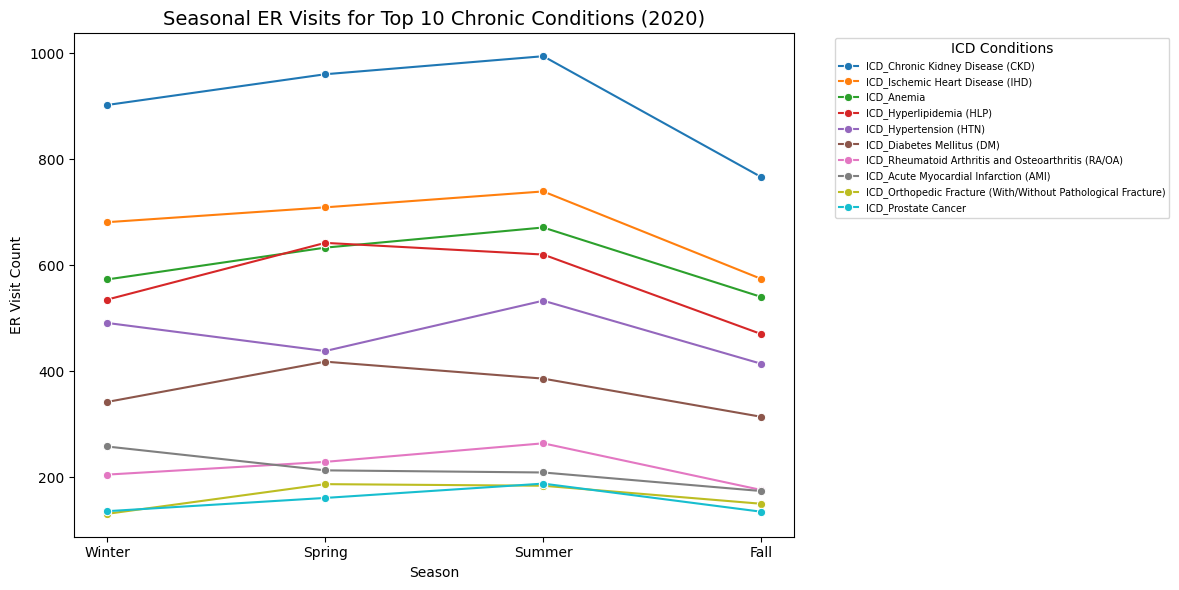

In [480]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

def plot_seasonal_icd_conditions_er_visits(df, year=2020):
    # Ensure ADMIT_MONTH is datetime
    df['ADMIT_MONTH'] = pd.to_datetime(df['ADMIT_MONTH'])

    # Get ICD columns
    icd_cols = [col for col in df.columns if col.startswith('ICD_')]
    
    # Get top 10 ICDs by frequency
    top_icds = df[icd_cols].sum().sort_values(ascending=False).head(10).index.tolist()

    # Add season column
    df['SEASON'] = df['ADMIT_MONTH'].dt.month.apply(get_season)

    plt.figure(figsize=(12, 6))

    colors = sns.color_palette('tab10', len(top_icds))

    for i, condition_col in enumerate(top_icds):
        # Filter ER visits for the year and the condition
        filtered_df = df[
            (df['ADMIT_MONTH'].dt.year == year) &
            (df['ER_VISIT'] == 1) &
            (df[condition_col] == 1)
        ]

        # Group by season
        seasonal_stats = filtered_df.groupby('SEASON').agg(
            er_visits=('ER_VISIT', 'count')
        ).reindex(['Winter', 'Spring', 'Summer', 'Fall']).reset_index()

        # Plot
        sns.lineplot(data=seasonal_stats, x='SEASON', y='er_visits',
                     label=condition_col, color=colors[i % len(colors)], marker='o')

    # Formatting
    plt.title(f'Seasonal ER Visits for Top 10 Chronic Conditions ({year})', fontsize=14)
    plt.xlabel('Season')
    plt.ylabel('ER Visit Count')
    plt.legend(title='ICD Conditions', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
    plt.tight_layout()
    plt.show()

# Example usage
plot_seasonal_icd_conditions_er_visits(merged_df_encoded, year=2020)


In [482]:
filtered_df
df

NameError: name 'df' is not defined

In [475]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

def compare_seasonal_er_visits_pre_post_covid(df, year_before=2019, year_after=2020):
    df['ADMIT_MONTH'] = pd.to_datetime(df['ADMIT_MONTH'])
    df['SEASON'] = df['ADMIT_MONTH'].dt.month.apply(get_season)

    icd_cols = [col for col in df.columns if col.startswith('ICD_')]
    top_icds = df[icd_cols].sum().sort_values(ascending=False).head(5).index.tolist()  # top 5 for clarity

    for icd in top_icds:
        plt.figure(figsize=(10, 5))

        for year, label in zip([year_before, year_after], ['Pre-COVID', 'Post-COVID']):
            filtered = df[
                (df['ADMIT_MONTH'].dt.year == year) &
                (df['ER_VISIT'] == 1) &
                (df[icd] == 1)
            ]
            seasonal_stats = filtered.groupby('SEASON')['ER_VISIT'].count().reindex(['Winter', 'Spring', 'Summer', 'Fall'])

            sns.lineplot(x=seasonal_stats.index, y=seasonal_stats.values,
                         label=f'{label} ({year})', marker='o')

        plt.title(f"Seasonal ER Visits for {icd.replace('ICD_', '')}")
        plt.xlabel("Season")
        plt.ylabel("ER Visit Count")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [ ]:
compare_seasonal_er_visits_pre_post_covid(merged_df_encoded, year_before=2019, year_after=2020)


In [553]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

def plot_seasonal_er_visits_all_icds(df, year_before=2019, year_after=2020):
    df['ADMIT_MONTH'] = pd.to_datetime(df['ADMIT_MONTH'])
    df['SEASON'] = df['ADMIT_MONTH'].dt.month.apply(get_season)

    icd_cols = [col for col in df.columns if col.startswith('ICD_')]
    top_icds = df[icd_cols].sum().sort_values(ascending=False).head(5).index.tolist()  # You can increase this number if needed

    # Prepare a combined DataFrame for plotting
    combined_data = []

    for year in [year_before, year_after]:
        for icd in top_icds:
            temp_df = df[
                (df['ADMIT_MONTH'].dt.year == year) &
                (df['ER_VISIT'] == 1) &
                (df[icd] == 1)
            ].copy()

            seasonal_counts = temp_df.groupby('SEASON')['ER_VISIT'].count().reindex(['Winter', 'Spring', 'Summer', 'Fall'])
            for season, count in seasonal_counts.items():
                combined_data.append({
                    'ICD': icd.replace('ICD_', ''),
                    'Season': season,
                    'ER_Visits': count,
                    'Year': str(year)
                })

    plot_df = pd.DataFrame(combined_data)

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=plot_df, x='Season', y='ER_Visits', hue='ICD', style='Year', markers=True, dashes=True)

    plt.title(f"Seasonal ER Visits Comparison: Pre vs Post COVID ({year_before} vs {year_after})", fontsize=14)
    plt.xlabel("Season")
    plt.ylabel("ER Visit Count")
    plt.legend(title='ICD Condition / Year', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()


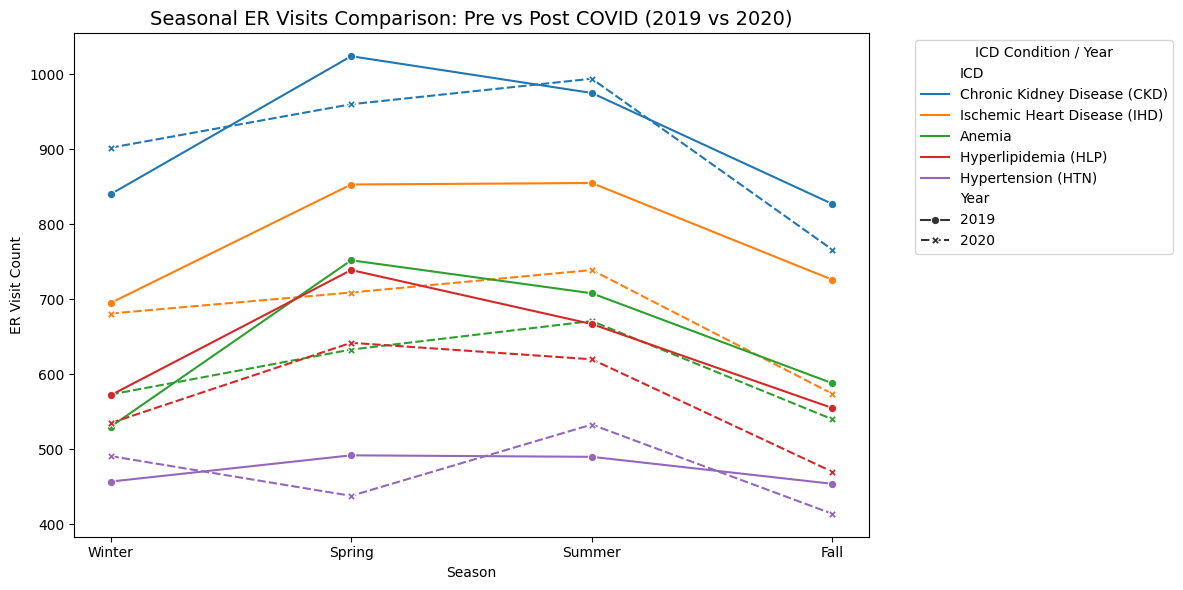

In [554]:
plot_seasonal_er_visits_all_icds(merged_df_encoded, year_before=2019, year_after=2020)


In [ ]:
# Not working

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get ICD columns
icd_cols = [col for col in merged_df_encoded.columns if col.startswith('ICD_')]

# 2. Correlation with ER_VISIT
correlations = merged_df_encoded[icd_cols + ['ER_VISIT']].corr()['ER_VISIT'].drop('ER_VISIT')

# 3. Get logistic regression coefficients and align with X_train features
# Ensure X_train has the same columns as the model coefficients
#model_coeffs = pd.Series(model_logis.coef_[0], index=X_train.columns)

# Extract and sort logistic regression coefficients
model_coeffs = pd.Series(model_logis.coef_[0], index=X.columns).sort_values(ascending=False)
# 4. Filter importance only for ICD features
icd_importance = model_coeffs[model_coeffs.index.isin(icd_cols)]

# 5. Combine correlation and importance into a DataFrame
combined_df = pd.DataFrame({
    'Correlation_with_ER': correlations,
    'Feature_Importance': icd_importance
}).dropna()

# 6. Sort by Feature Importance
combined_df = combined_df.sort_values(by='Feature_Importance', ascending=False)

# 7. Plot top 10 ICDs by feature importance
top_combined = combined_df.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_combined['Feature_Importance'], y=top_combined.index, palette='mako')
plt.title("Top 10 Chronic Conditions by Feature Importance (Logistic Regression)", fontsize=14)
plt.xlabel("Feature Importance (Coefficient)", fontsize=12)
plt.ylabel("ICD Condition", fontsize=12)
plt.tight_layout()
plt.show()

# Optional: Display table
print(top_combined.round(3))


In [449]:
print("Model coefficients length:", len(model_logis.coef_[0]))
print("Feature columns length:", len(X.columns))


Model coefficients length: 34
Feature columns length: 22


In [452]:
# Columns used to train the model
trained_features = set(X_train.columns)

# Columns currently being used
current_features = set(X.columns)

# What’s missing?
print("Missing columns:", trained_features - current_features)
print("Extra columns:", current_features - trained_features)




Missing columns: set()
Extra columns: set()


#H1: Patients with chronic conditions such as COPD, heart failure, or diabetes have a higher likelihood of ER visits.

In [694]:
import pandas as pd
import matplotlib.pyplot as plt
#COPD stands for Chronic Obstructive Pulmonary Disease. It is a chronic, progressive lung disease that makes it hard to breathe
# Define chronic conditions of interest
conditions = ['ICD_Chronic Kidney Disease (CKD)', 'ICD_Alzheimer's Disease(AD)', 'ICD_No Abnormality Detected (NAD)']
condition_labels = ['Kidney Disease', 'Alzheimer's Disease', 'No Abnormality Detectedbetes'] 

# Calculate ER visit rates for each condition
er_rates = []
for cond in conditions:
    subset = merged_df_encoded[merged_df_encoded[cond] == 1]
    rate = subset['ER_VISIT'].mean()  # mean of binary target = proportion of ER visits
    er_rates.append(rate)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(condition_labels, er_rates, color='skyblue')
plt.ylabel('Proportion of ER Visits')
plt.title('ER Visit Rates Among Patients With Chronic Conditions')
plt.ylim(0, 1)
for i, v in enumerate(er_rates):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


SyntaxError: unterminated string literal (detected at line 5) (977358710.py, line 5)

H2: Older age groups (75+) are more likely to visit the ER compared to younger age groups (31–64)

C:\Users\sarad\AppData\Local\Temp\ipykernel_11148\636798746.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  er_rate = merged_df_encoded.groupby('AGE_GROUP')['ER_VISIT'] \
C:\Users\sarad\AppData\Local\Temp\ipykernel_11148\636798746.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  er_count = merged_df_encoded.groupby('AGE_GROUP')['ER_VISIT'] \


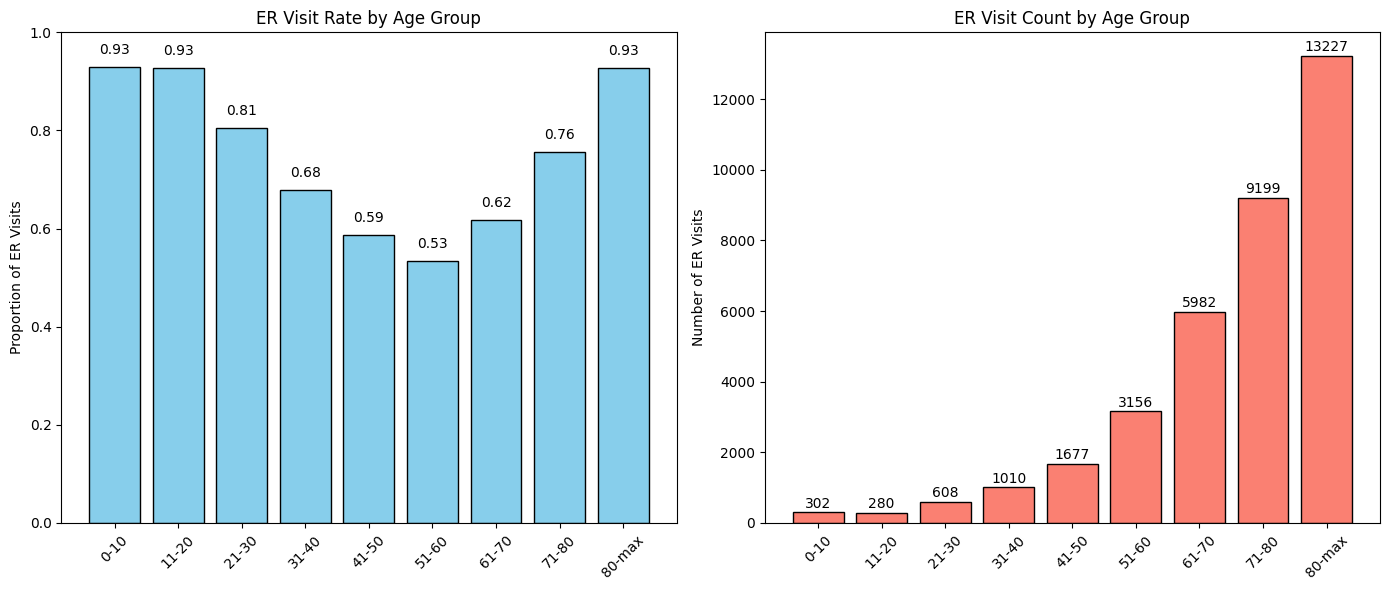

In [1259]:
import matplotlib.pyplot as plt

# Ensure AGE_GROUP is ordered correctly
age_order = merged_df_encoded['AGE_GROUP'].cat.categories

# 1. ER Visit Rate by Age Group
er_rate = merged_df_encoded.groupby('AGE_GROUP')['ER_VISIT'] \
.mean() \
.reindex(age_order)

# 2. ER Visit Count by Age Group
er_count = merged_df_encoded.groupby('AGE_GROUP')['ER_VISIT'] \
.sum() \
.reindex(age_order)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# a) Proportion plot
bars1 = axes[0].bar(age_order, er_rate, color='skyblue', edgecolor='black')
axes[0].set_title('ER Visit Rate by Age Group')
axes[0].set_ylabel('Proportion of ER Visits')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=45)

# Add numbers on top of bars
for bar in bars1:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

# b) Count plot
bars2 = axes[1].bar(age_order, er_count, color='salmon', edgecolor='black')
axes[1].set_title('ER Visit Count by Age Group')
axes[1].set_ylabel('Number of ER Visits')
axes[1].tick_params(axis='x', rotation=45)

# Add numbers on top of bars
for bar in bars2:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 50, round(yval, 0), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
H3: There is a significant association between sex and ER visit rates

C:\Users\sarad\AppData\Local\Temp\ipykernel_11148\61469017.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  er_rate_sex = merged_df_encoded.groupby('SEX_IDENT_CD')['ER_VISIT'] \


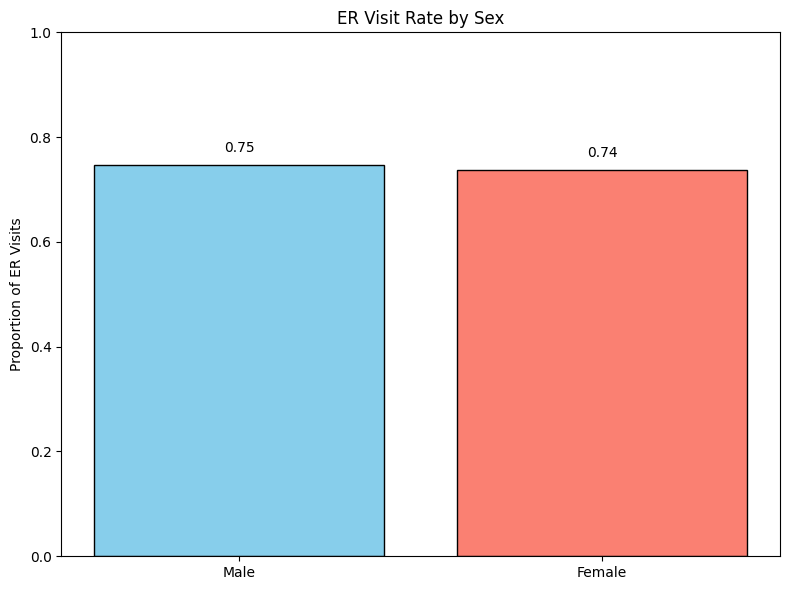

In [1260]:
import matplotlib.pyplot as plt

# Calculate ER Visit Rate by Sex
er_rate_sex = merged_df_encoded.groupby('SEX_IDENT_CD')['ER_VISIT'] \
.mean()

# Create a bar plot for ER Visit Rates by Sex
plt.figure(figsize=(8, 6))
bars = plt.bar(er_rate_sex.index, er_rate_sex.values, color=['skyblue', 'salmon'], edgecolor='black')

# Set plot title and labels
plt.title('ER Visit Rate by Sex')
plt.ylabel('Proportion of ER Visits')
plt.xticks([0, 1], ['Male', 'Female'])  # Assuming 0=Male, 1=Female for SEX_IDENT_CD
plt.ylim(0, 1)

# Add numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# How does the length of hospital stay relate to future ER visits?

C:\Users\sarad\AppData\Local\Temp\ipykernel_20332\688712936.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_icd_los.values, y=top_icd_los.index, palette='viridis')


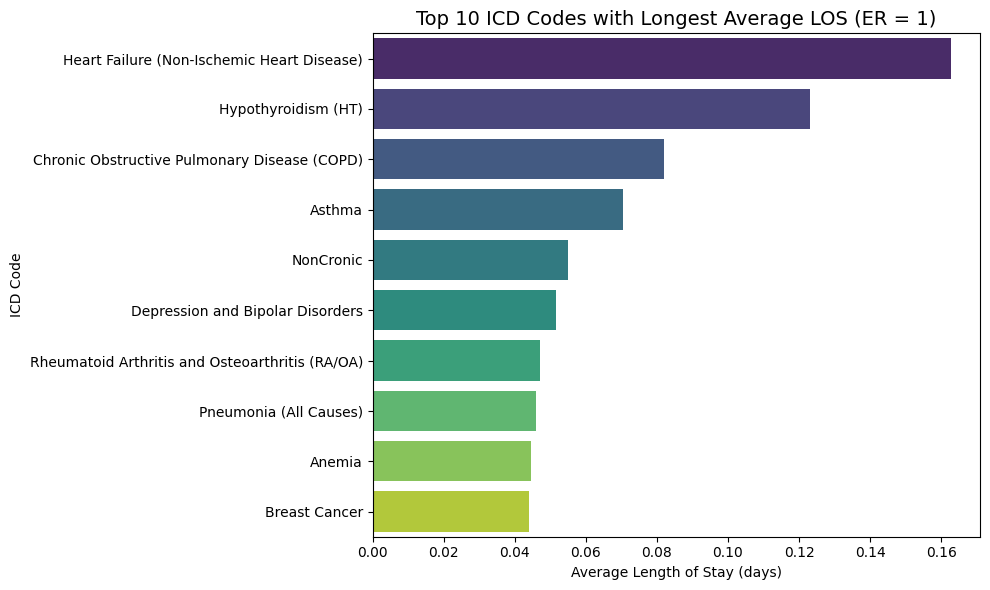

In [551]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Filter only patients who visited ER and have valid LOS
df_er = merged_df[(merged_df['ER_VISIT'] == 1) & (merged_df['LOS'].notnull())]

# Step 2: Melt ICD diagnosis columns into long format
icd_cols = [col for col in df_er.columns if col.startswith('ICD_DGNS_CD')]
df_long = df_er.melt(id_vars=['LOS'], value_vars=icd_cols, 
                     var_name='ICD_Column', value_name='ICD_Code')

# Step 3: Remove missing and non-chronic codes
df_long = df_long.dropna(subset=['ICD_Code'])
df_long = df_long[df_long['ICD_Code'] != 'ICD_NonCronic']  # if stored as string label

# Step 4: Group by ICD code and compute average LOS
avg_los_by_icd = df_long.groupby('ICD_Code')['LOS'].mean().sort_values(ascending=False)

# Step 5: Plot top 10 ICD codes with highest avg LOS
top_icd_los = avg_los_by_icd.head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_icd_los.values, y=top_icd_los.index, palette='viridis')
plt.title('Top 10 ICD Codes with Longest Average LOS (ER = 1)', fontsize=14)
plt.xlabel('Average Length of Stay (days)')
plt.ylabel('ICD Code')
plt.tight_layout()
plt.show()
